In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation
from statsmodels.stats.stattools import durbin_watson
from scipy import ndimage
import imageio

global for_gif
global images

In [2]:
def life_step(X):
    
    """Game of life step using generator expressions"""
    
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [3]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    global for_gif
    global images
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int) 
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    

    for_gif = X
    images = []
    
    # initialization function: plot the background of each frame
    
    def init():
        
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    
    def animate(i):
        
        global for_gif
        global images
        
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        
        for_gif = np.concatenate((for_gif, 10*X))
        im.figure.savefig("conway.png")
        images.append(imageio.imread("conway.png")) 
        
        return (im,)
    
    animate.X = X
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval)
    
    return display_animation(anim, default_mode=mode)    

In [4]:
def add_border(x, border = 3):
        
        offset = int((border - 1)/2)
        
        background = np.repeat(0, x.shape[0] *
                               x.shape[1] *
                               border *
                               border).reshape([x.shape[0] *
                                                border, x.shape[1] *
                                                border])
        background[x.shape[0] *
                   offset:-x.shape[0] *
                   offset, x.shape[1] *
                   offset:-x.shape[1] *
                   offset] = x
        
        return(background)

In [5]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

[ 8 99 37 27 28 29 30 31 33 34 35 36 38 24 39 40 41 42 43 45 46 47 48 25
 23 50 11  1  2  3  4  5  6  7  9 10 12 22 13 14 15 16 17 18 19 20 21 98
 49 51 86 76 77 78 79 80 81 82 83 84 85 87 74 88 89 90 91 92 93 94 95 96
 97 75 73 63 62 53 54 55 56 57 58 59 60 61  0 64 65 66 67 68 69 70 71 72
 52 32 44 26]
[8.36141218 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017 8.35985017
 8.35985017 8.35985017 8


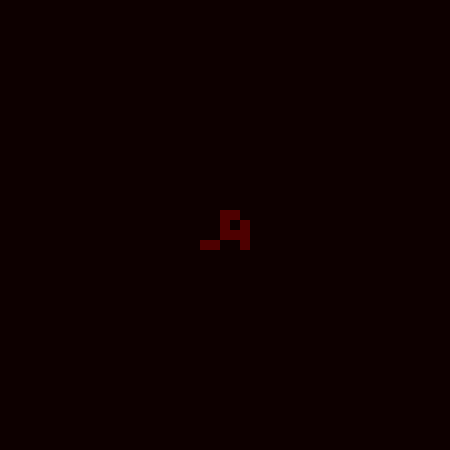
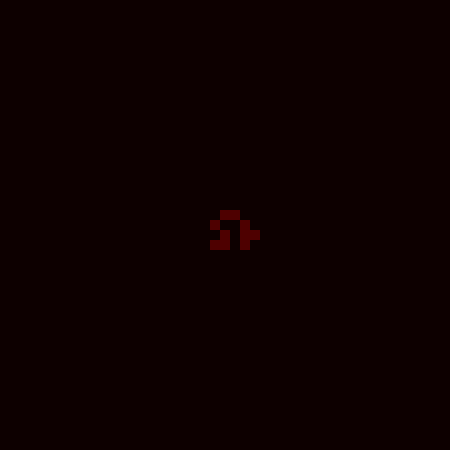
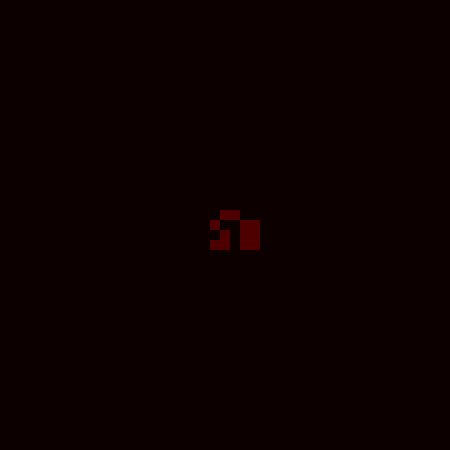
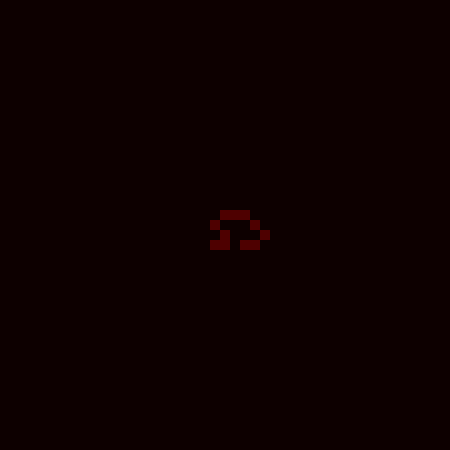
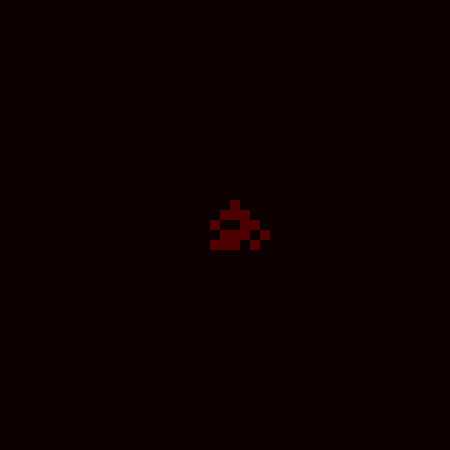
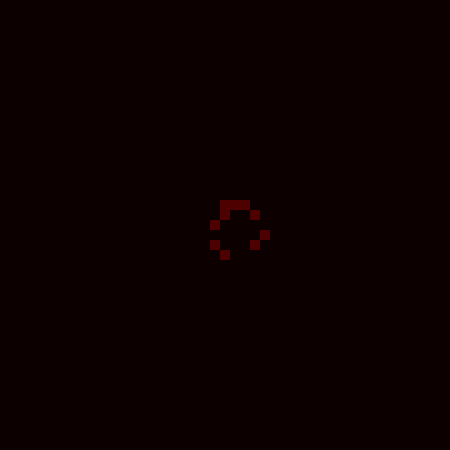
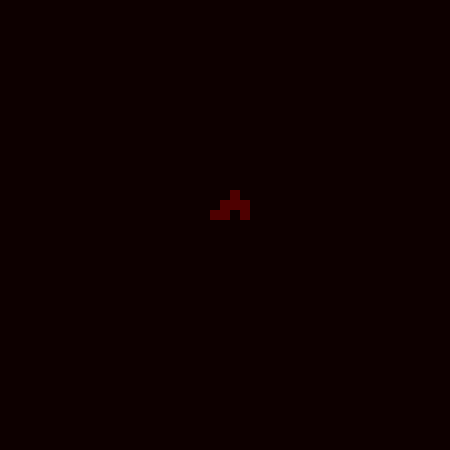
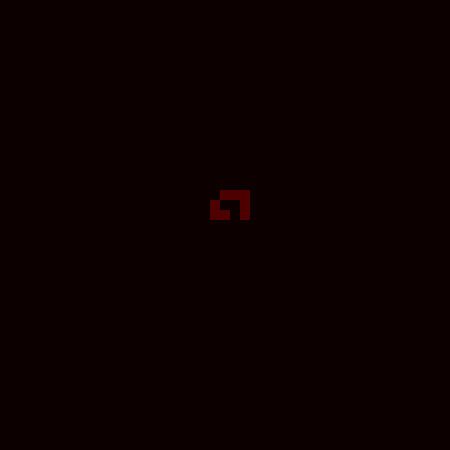
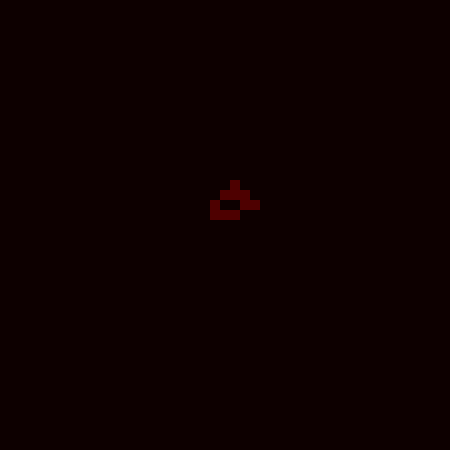
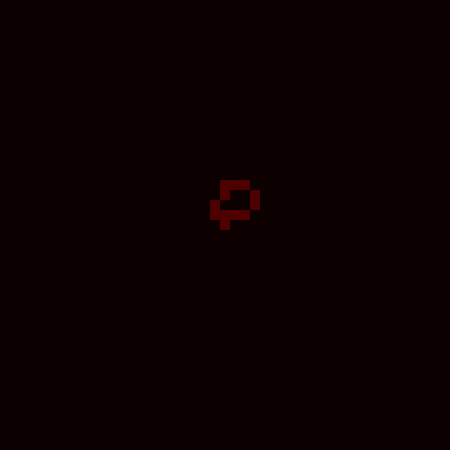
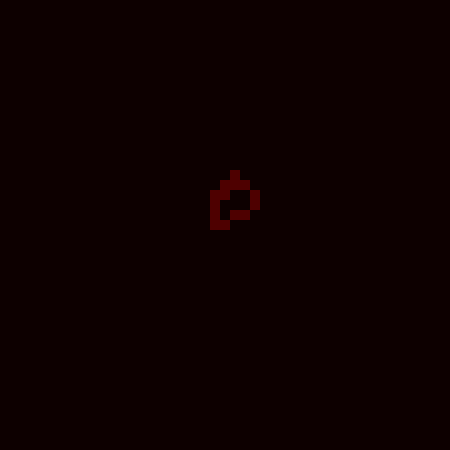
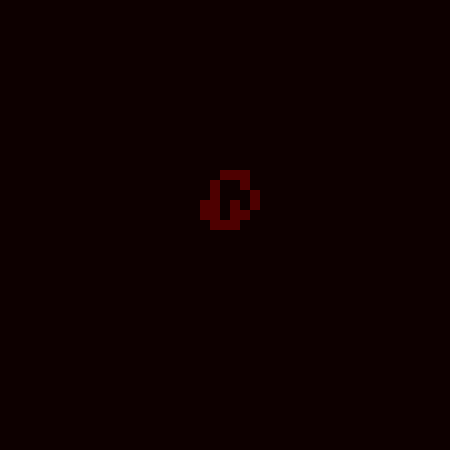
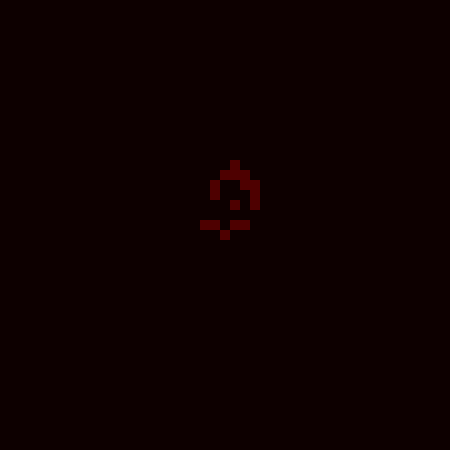
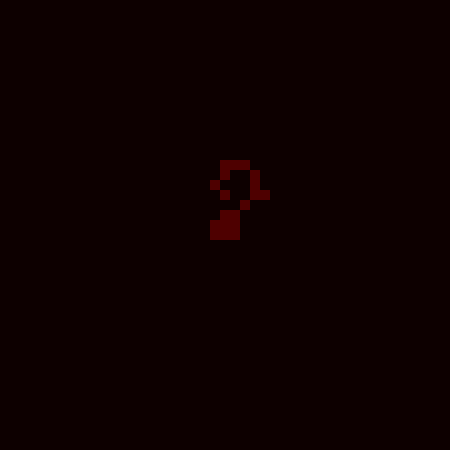
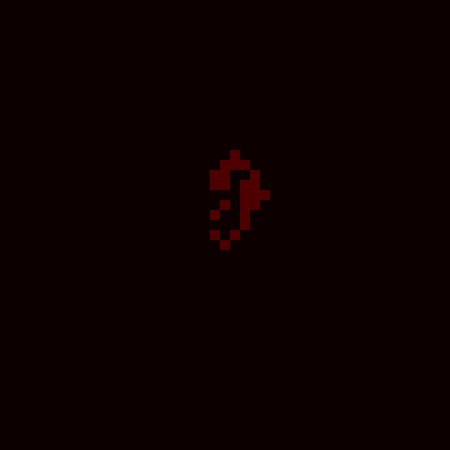
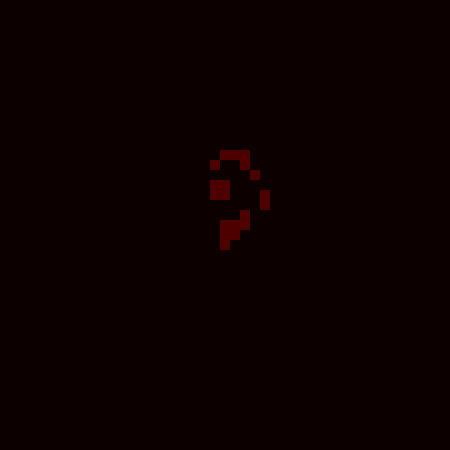
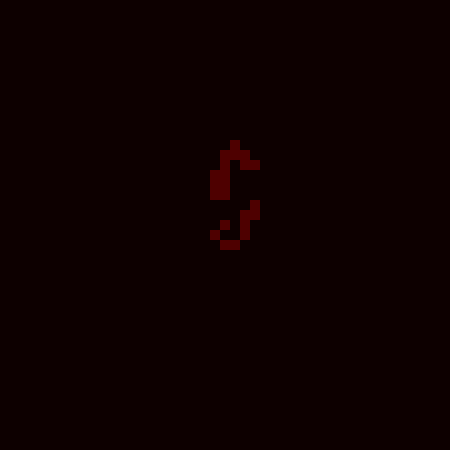
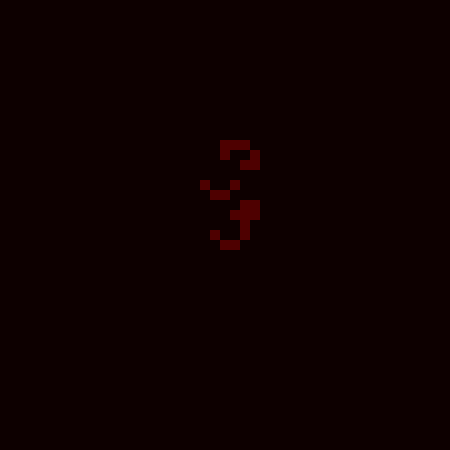
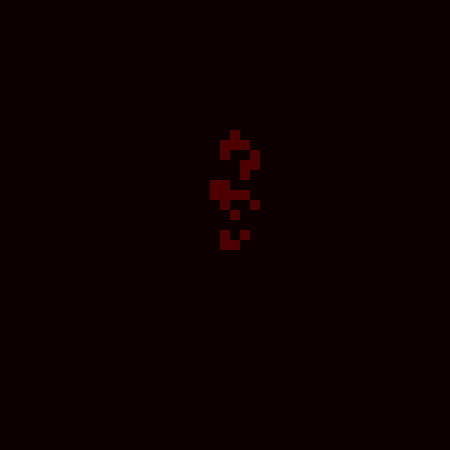
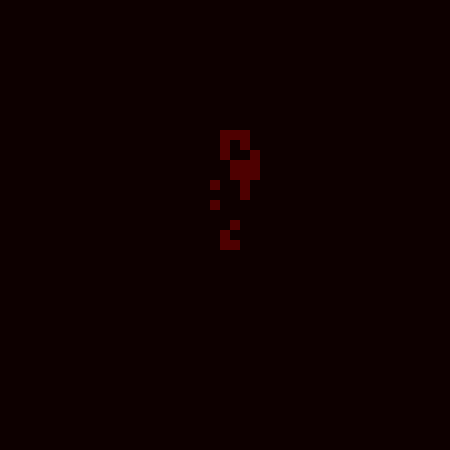
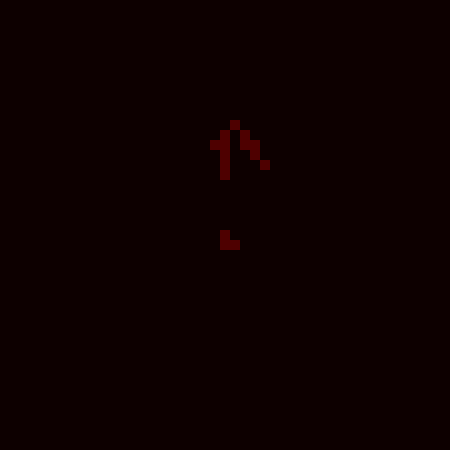
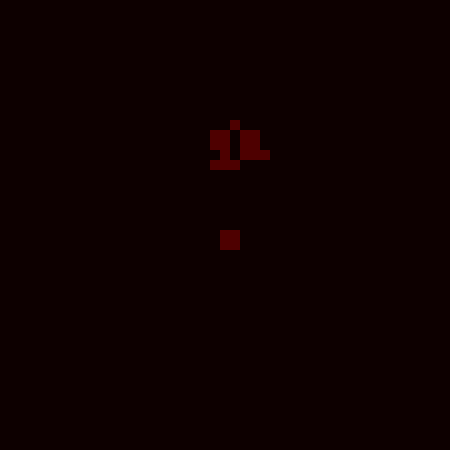
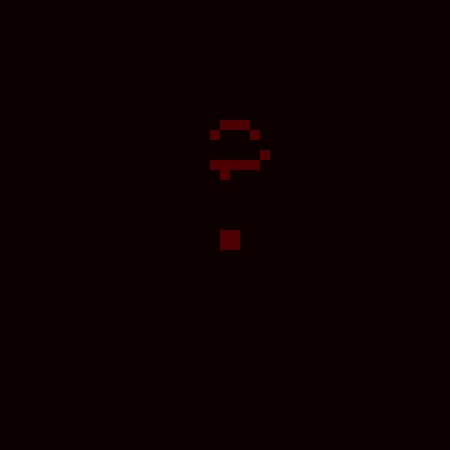
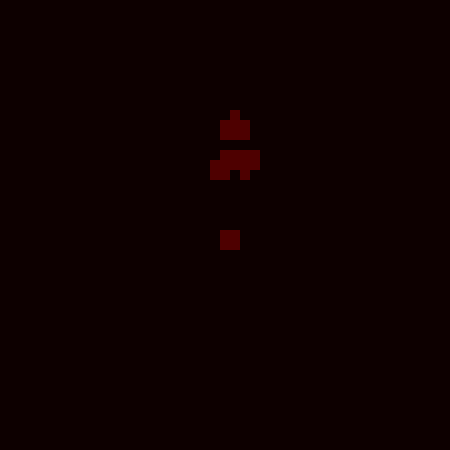
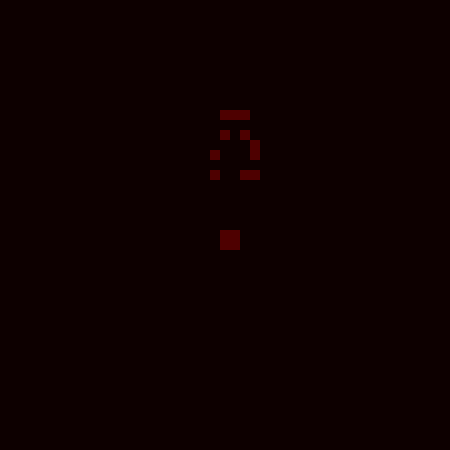
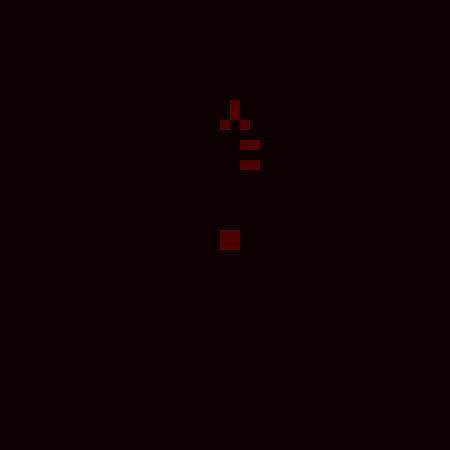
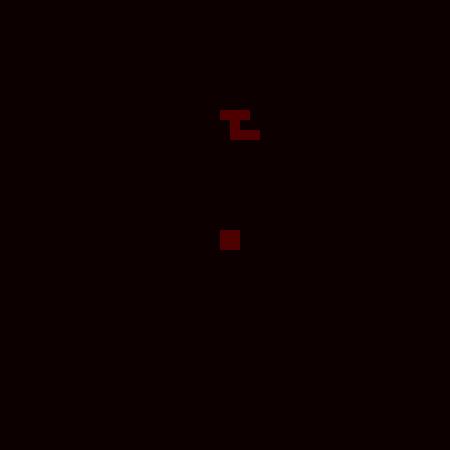
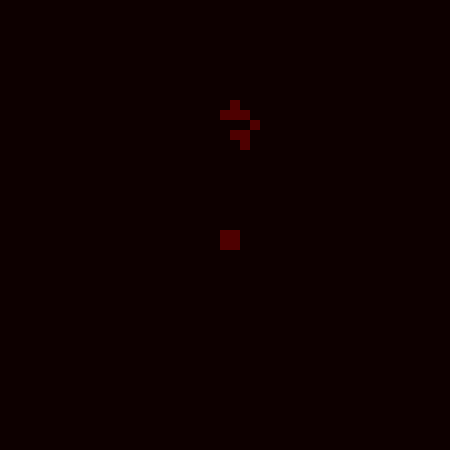
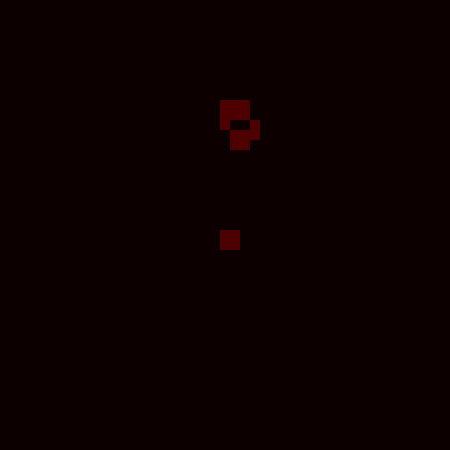
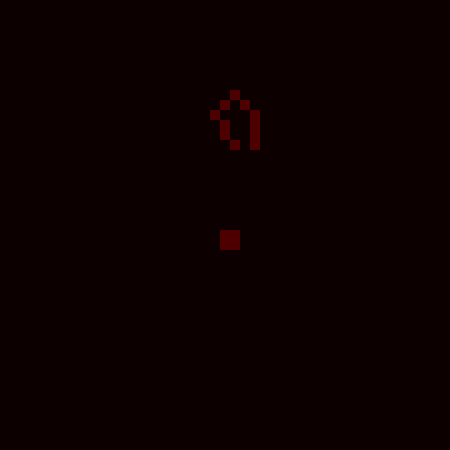
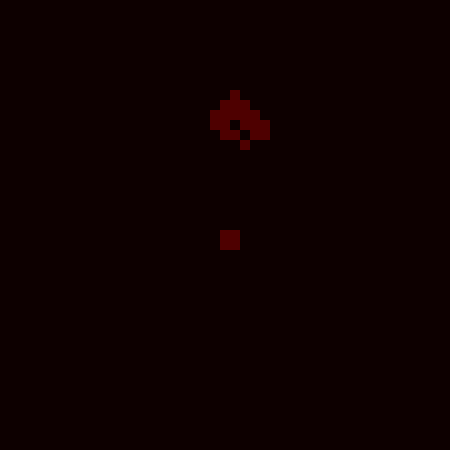
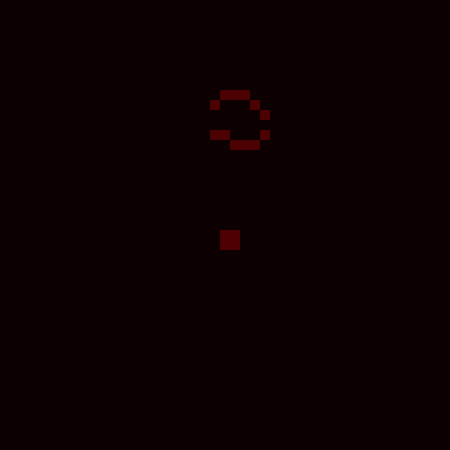
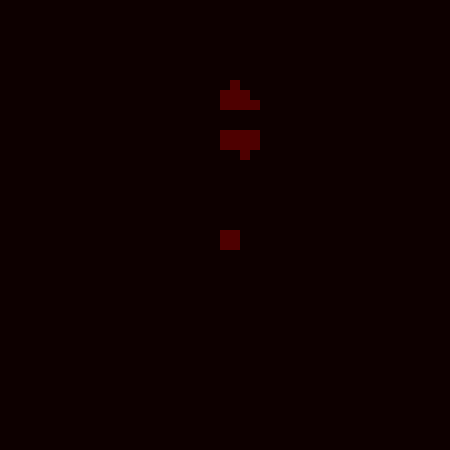
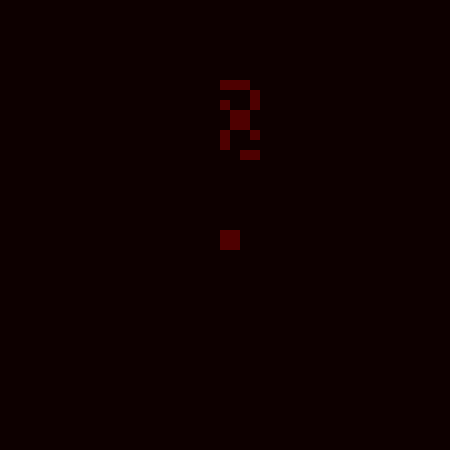
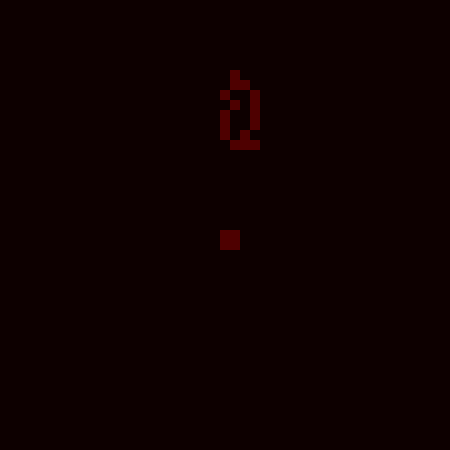
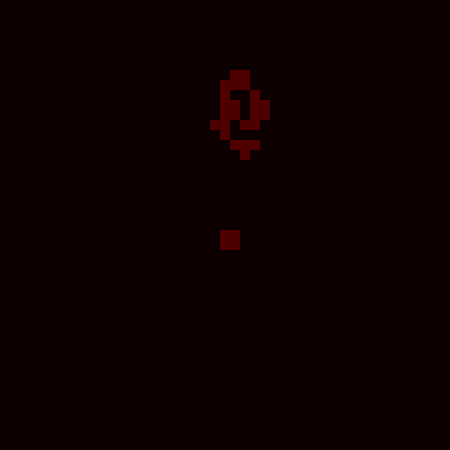
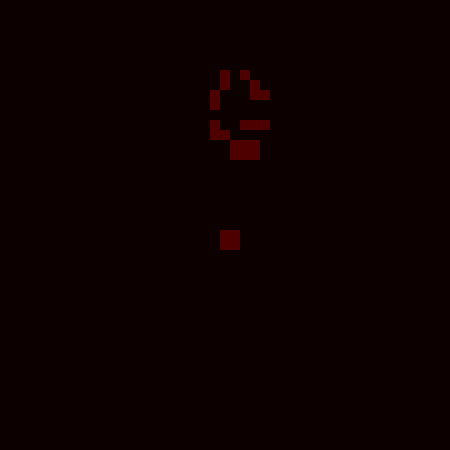
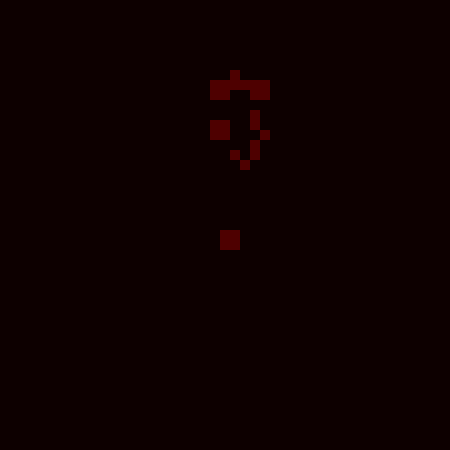
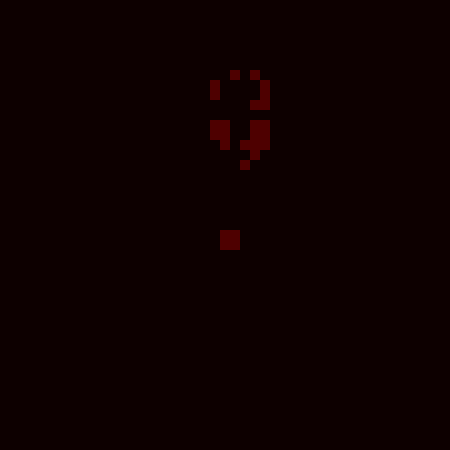
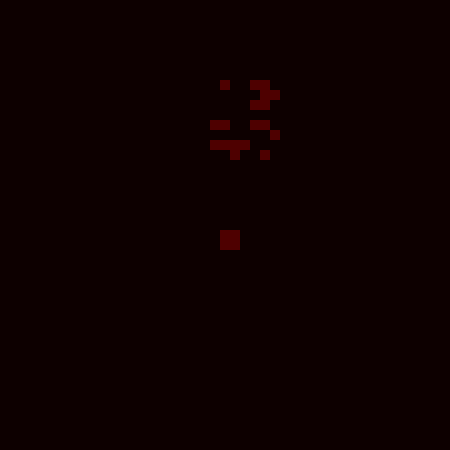
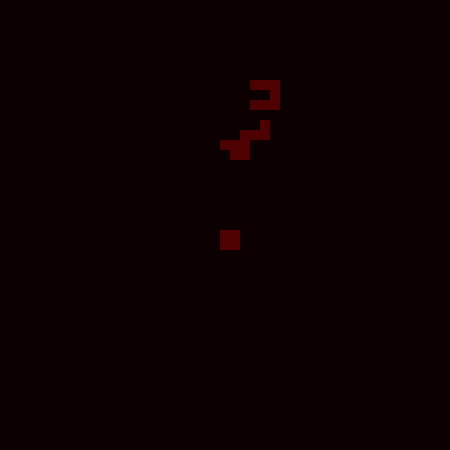
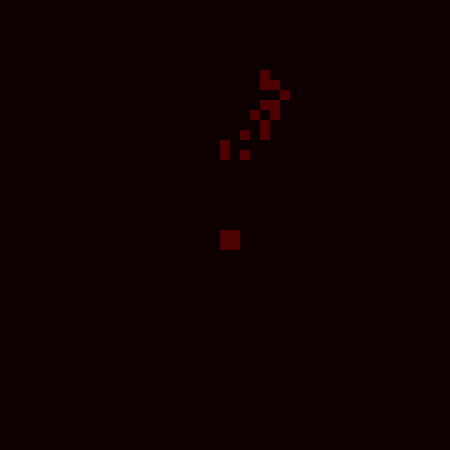
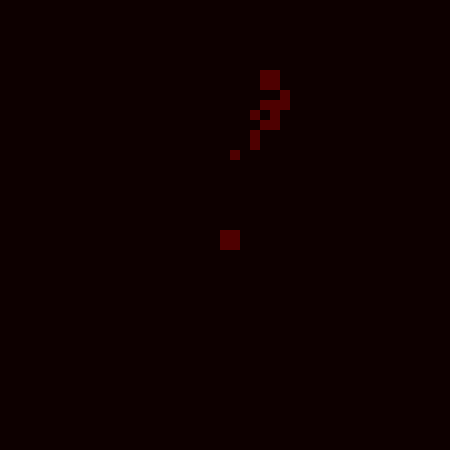
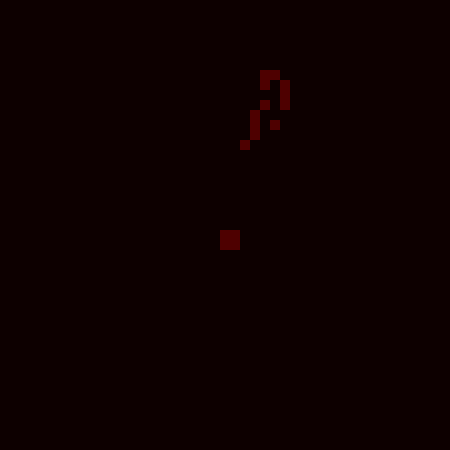
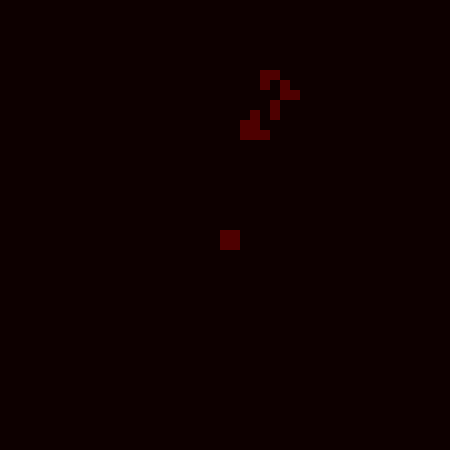
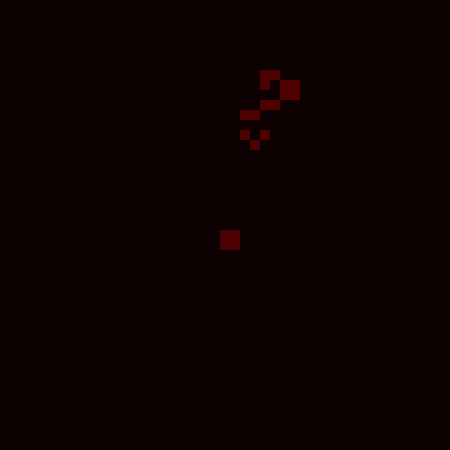
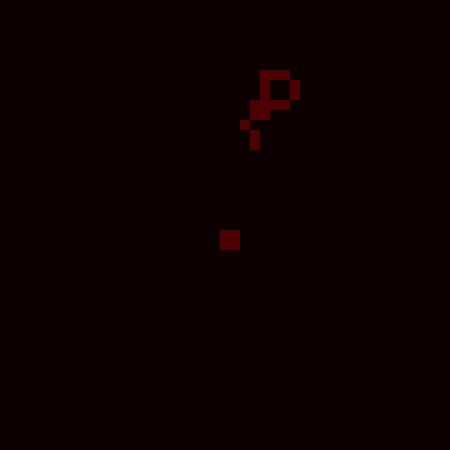
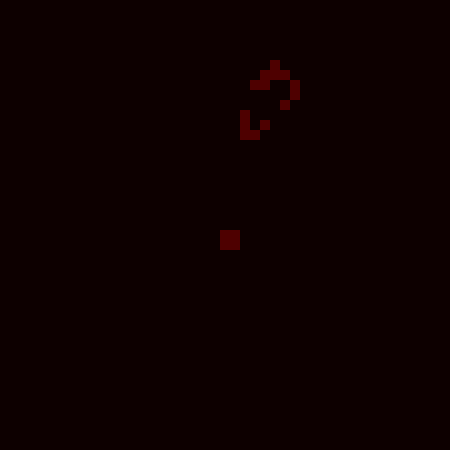
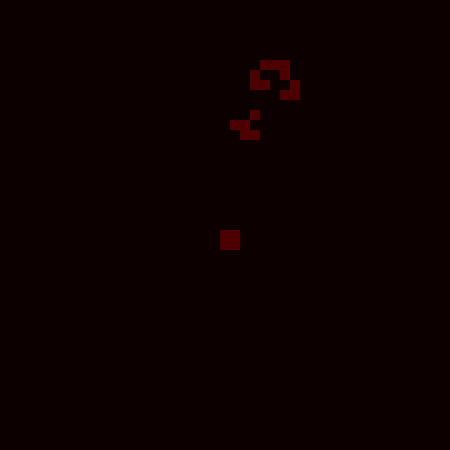
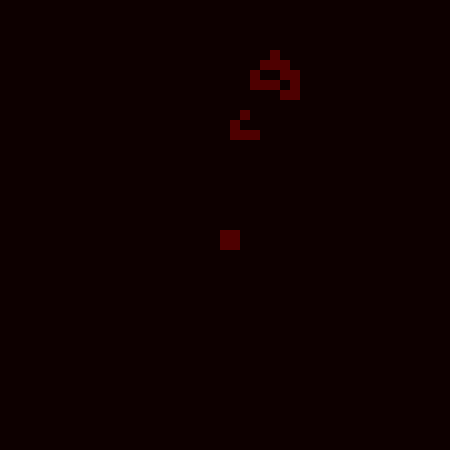
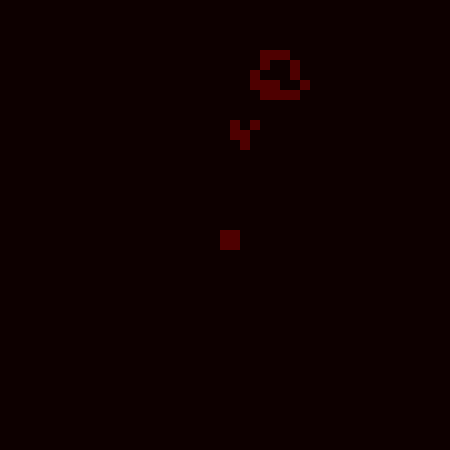
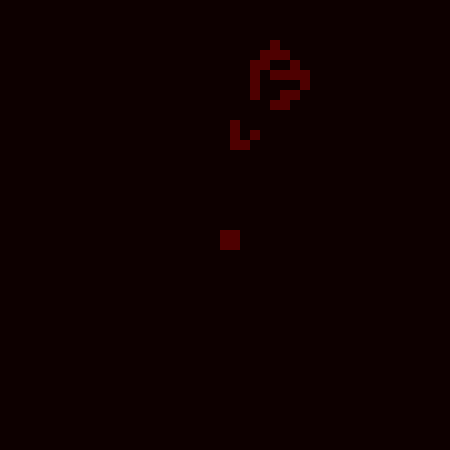
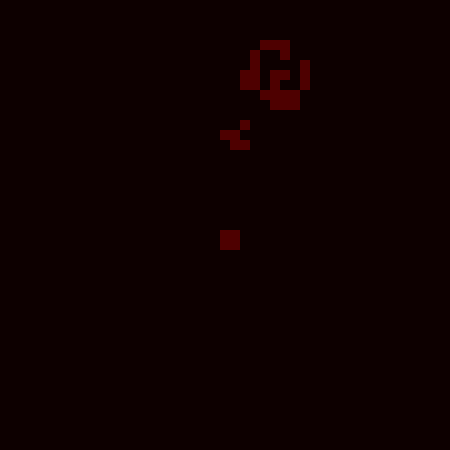
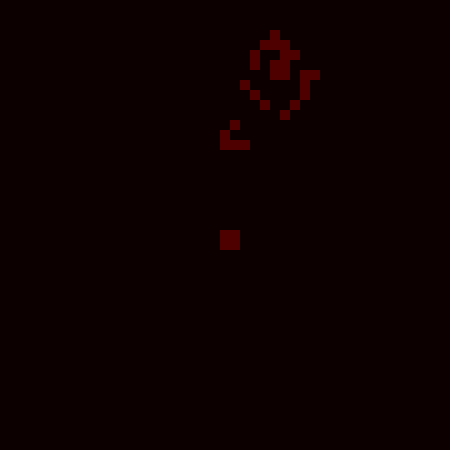
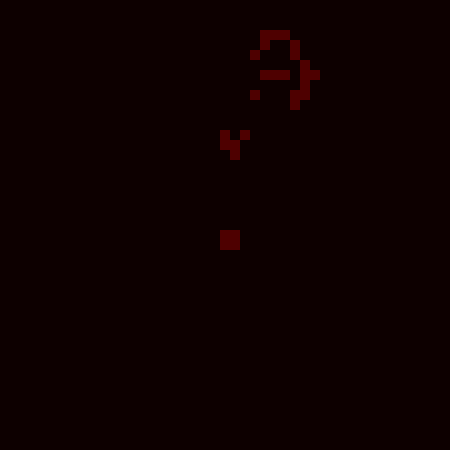
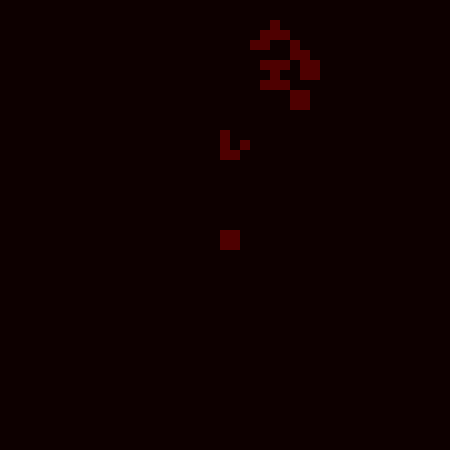
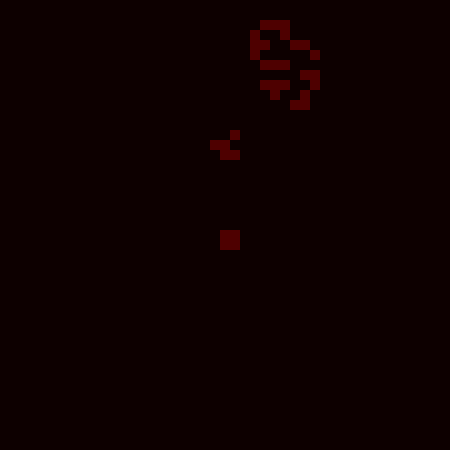
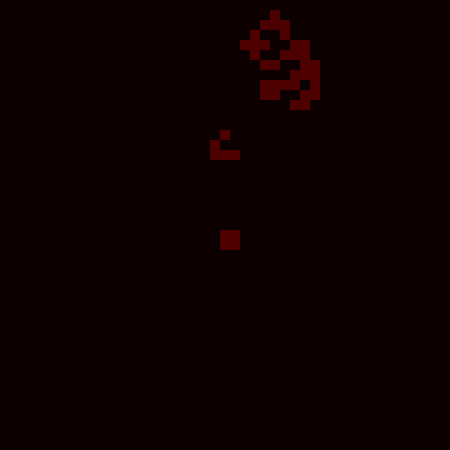
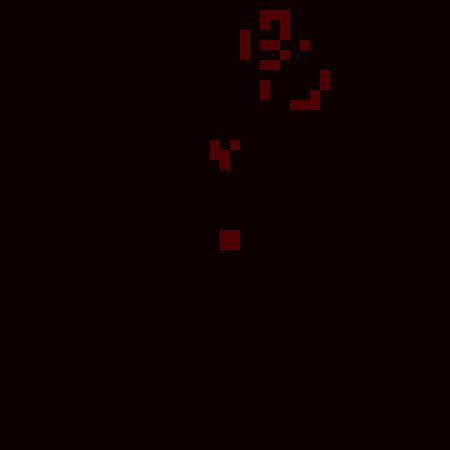
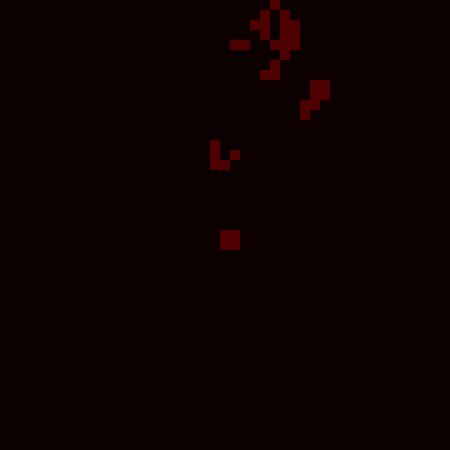
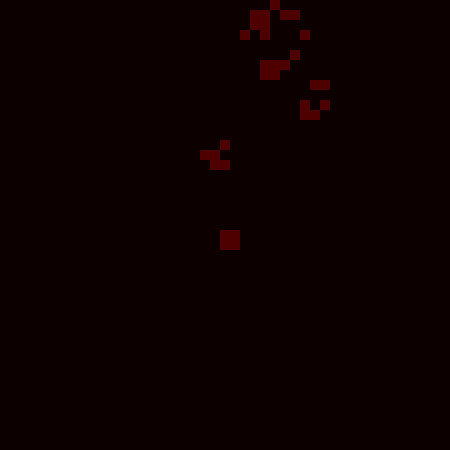
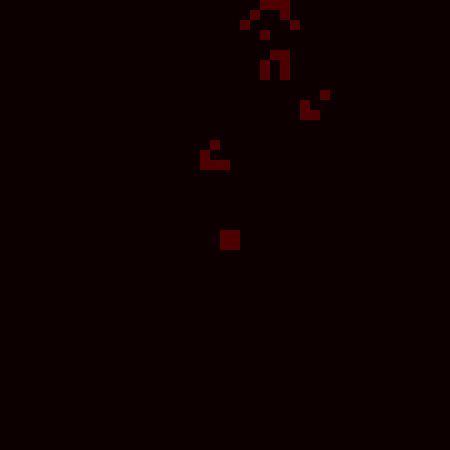
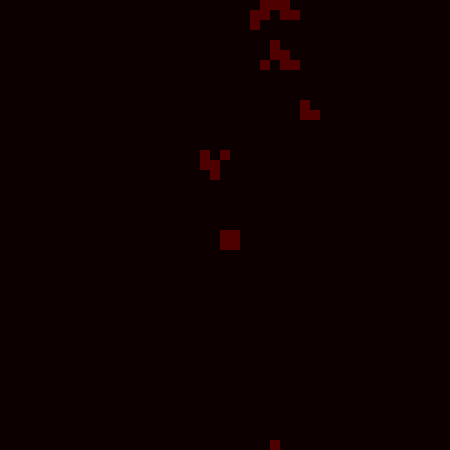
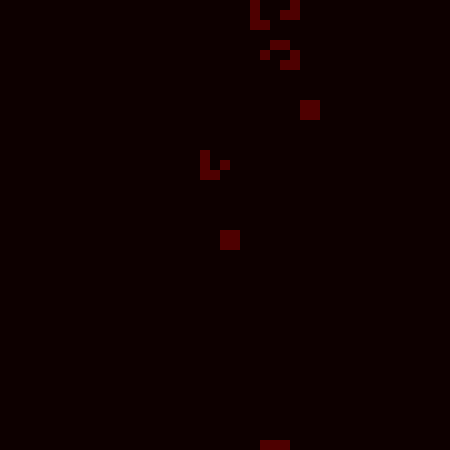
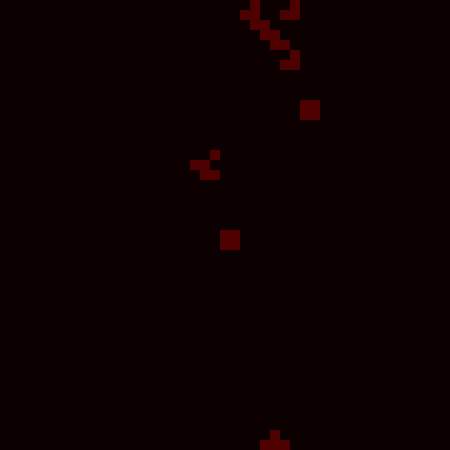
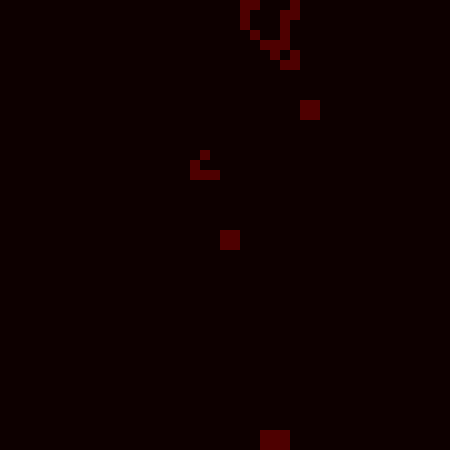
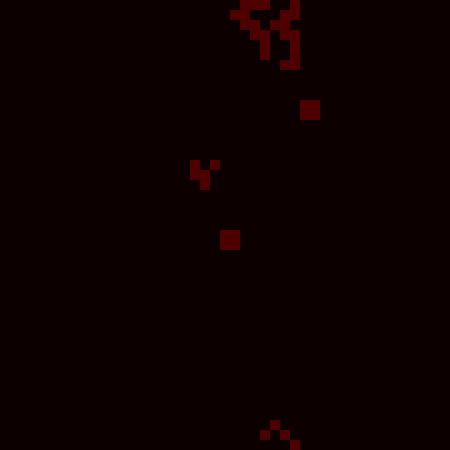
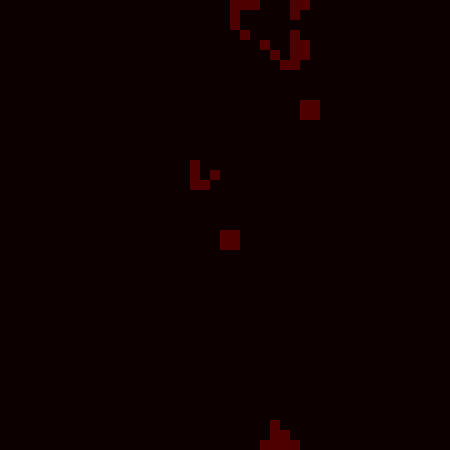
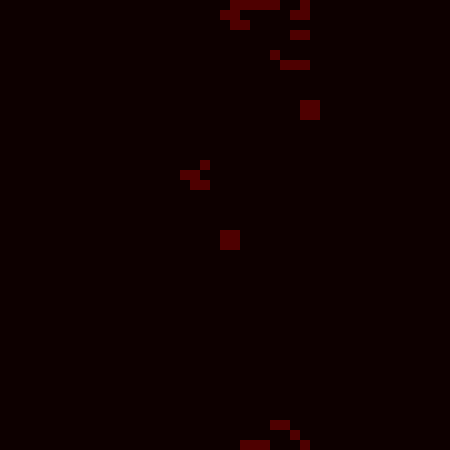
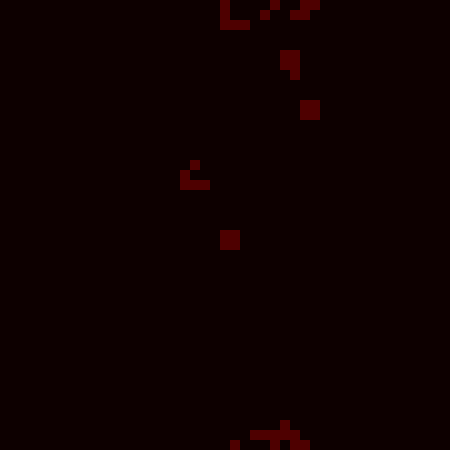
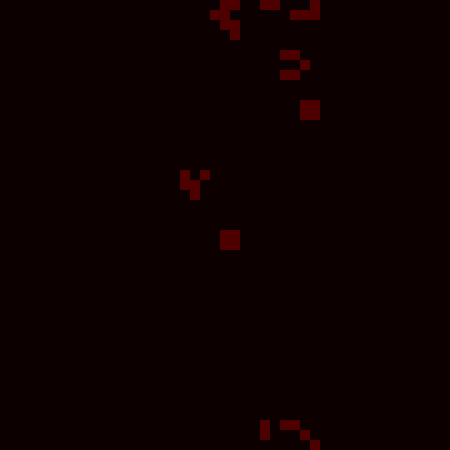
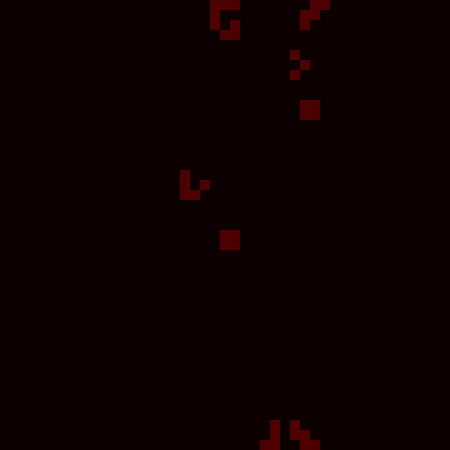
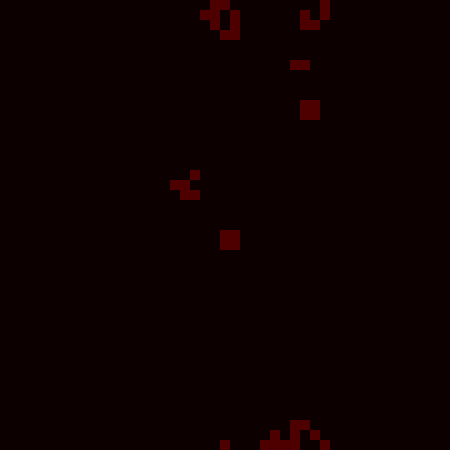
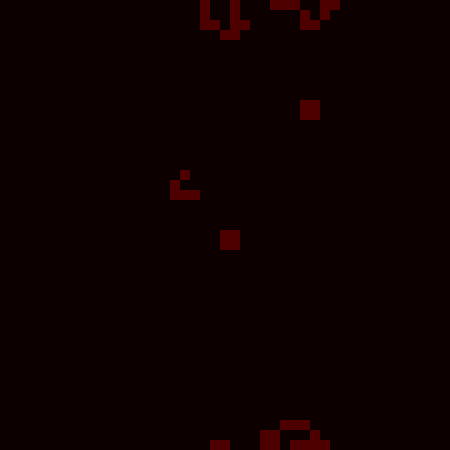
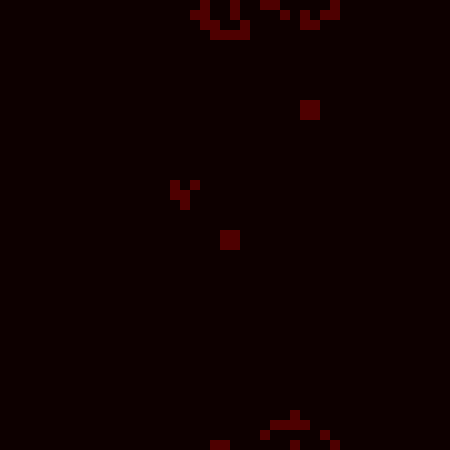
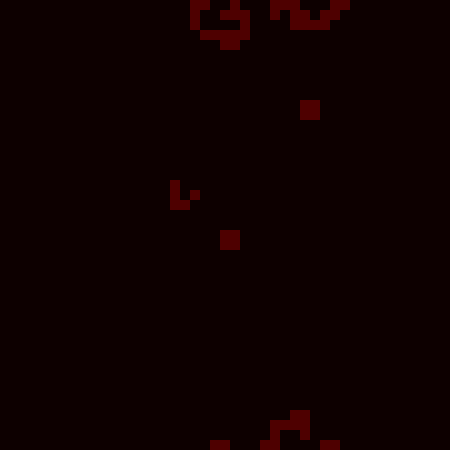
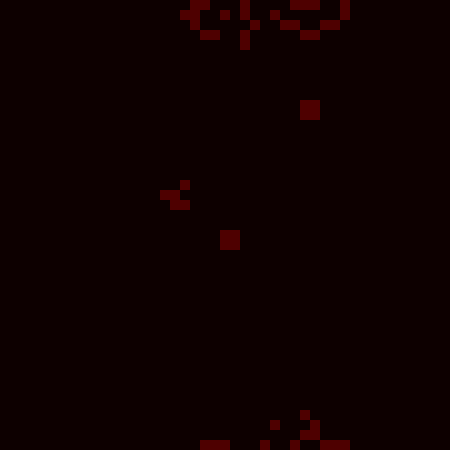
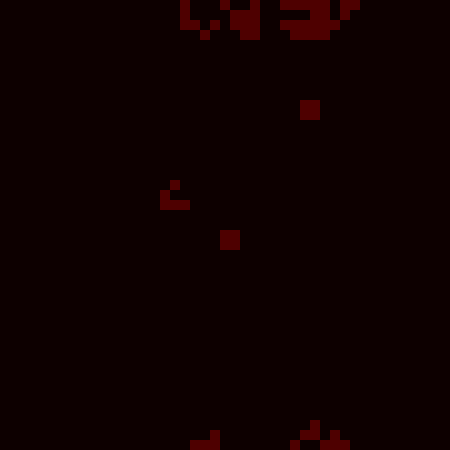
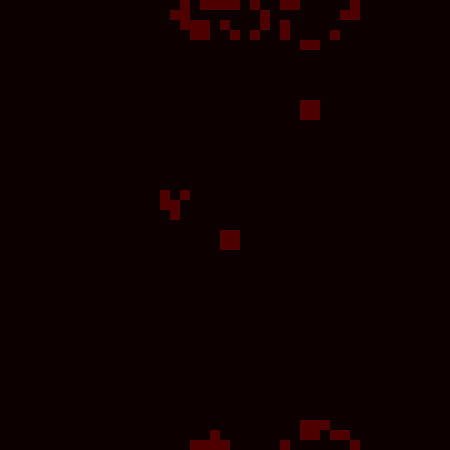
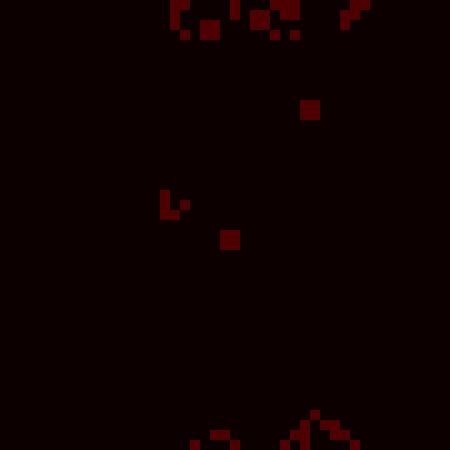
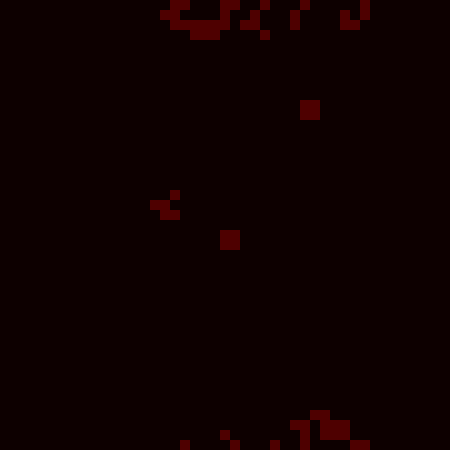
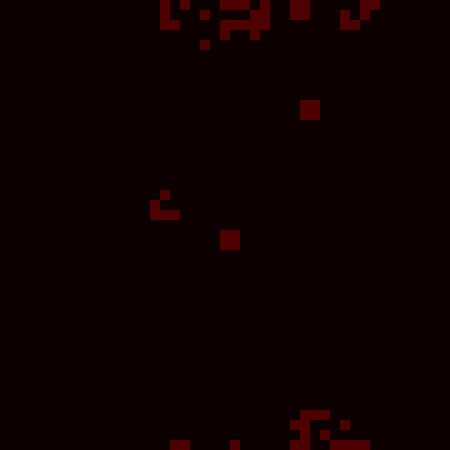
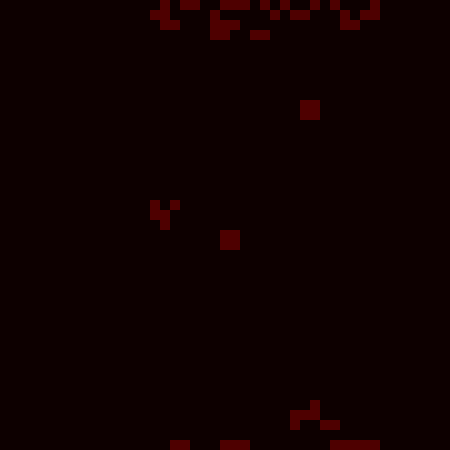
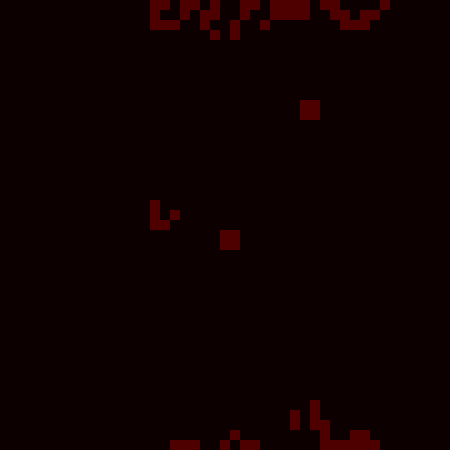
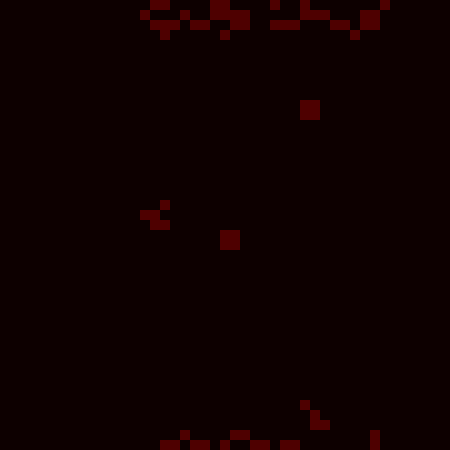
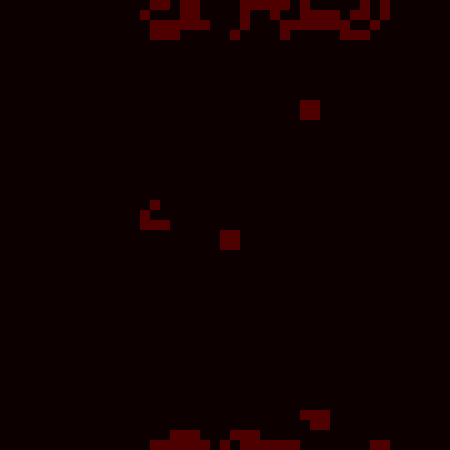
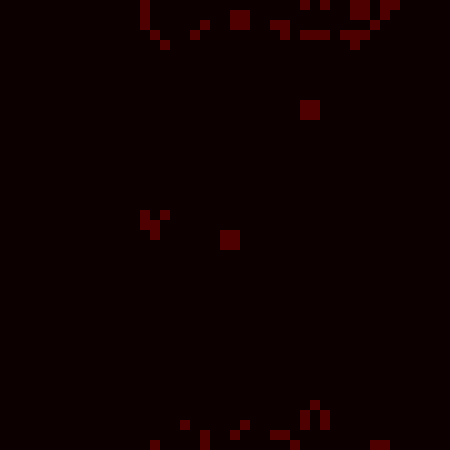
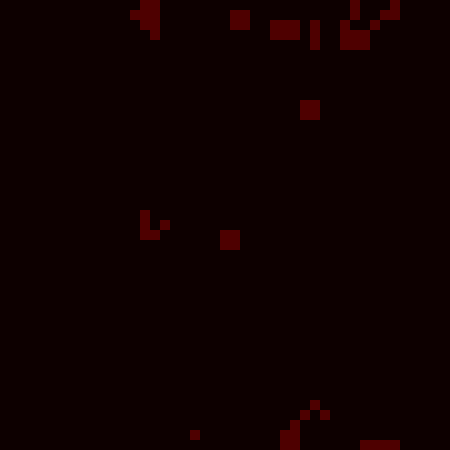
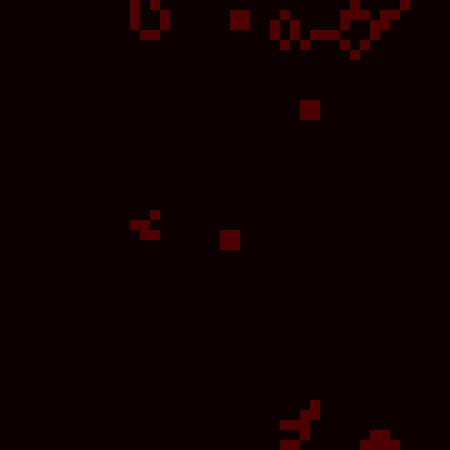
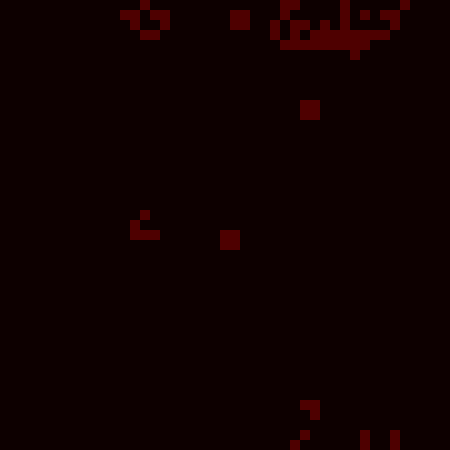
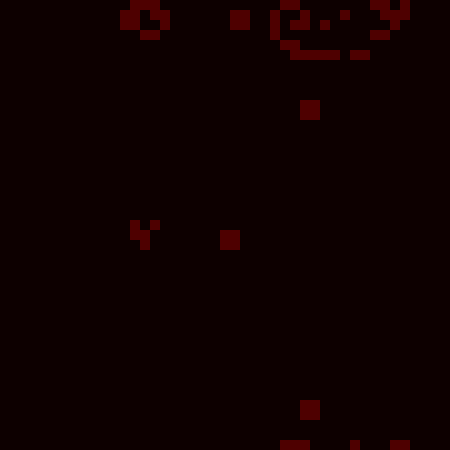
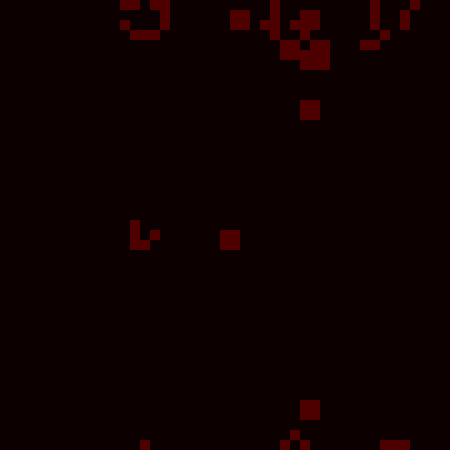
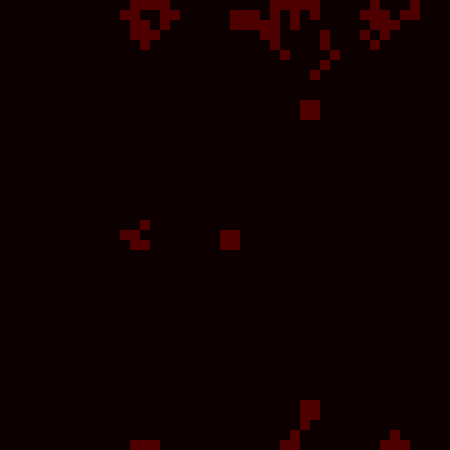
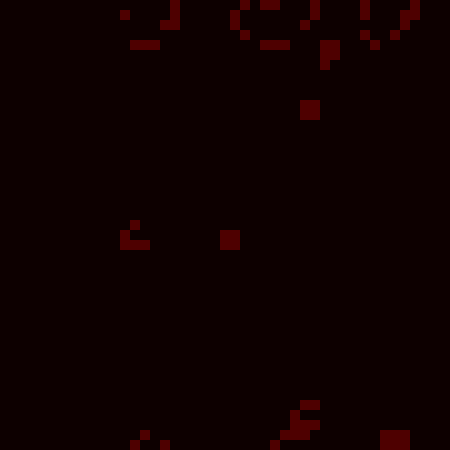
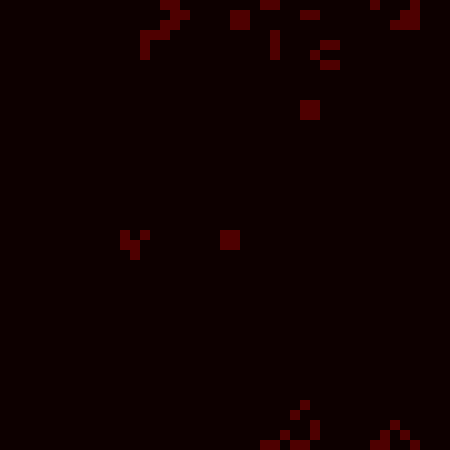
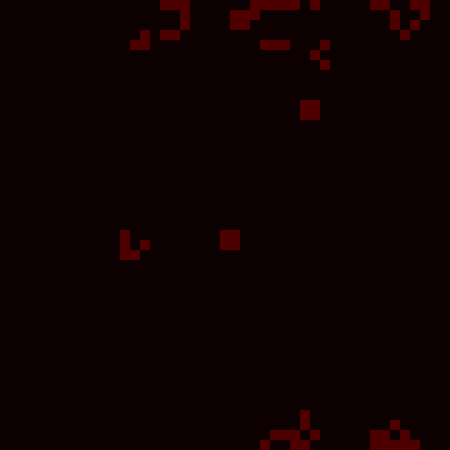
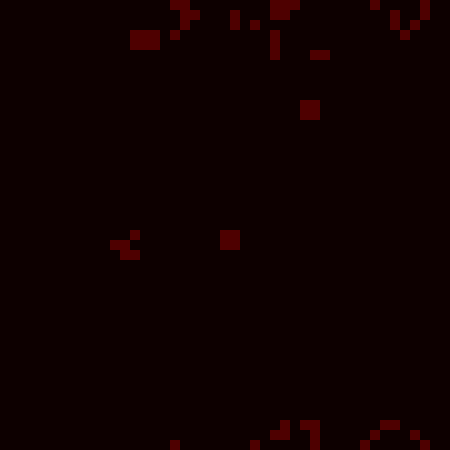
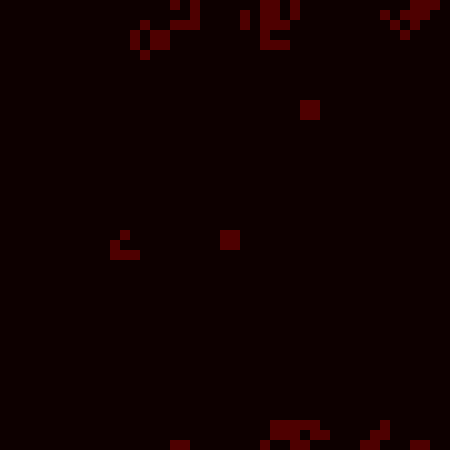
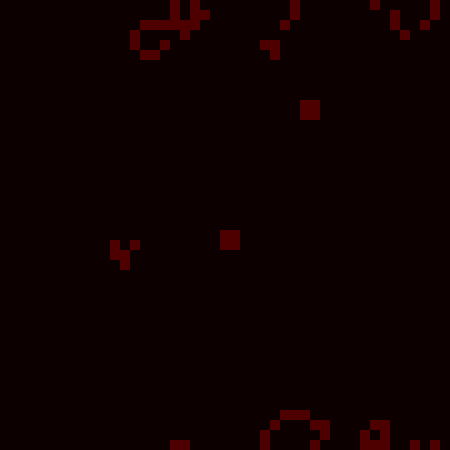
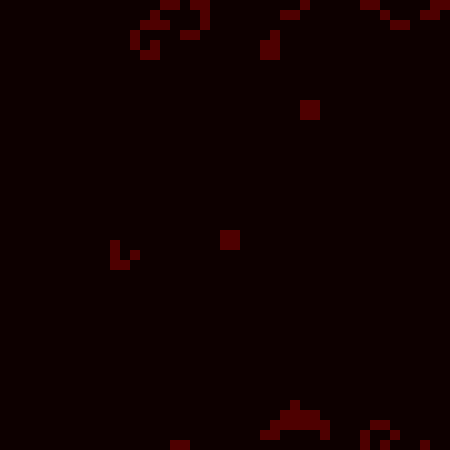

In [6]:
iteration_n = 5
frame_n = 100
xd = 5
yd = 5
sample_n = 100
border = 9

gen_noise = random.choice([0,1], [sample_n, xd*yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1
des_weights = 2 * random.random((xd*yd, 1)) - 1
    
for k in range(iteration_n):
    
    print(k)
    
    # Generate Part 1 #########################################################
    
    #gen_noise = random.random([sample_n, xd*yd])
    g_raw = sig_func(gen_noise, gen_weights)
    generated = np.round(g_raw)
    
    print("Generated")
    print(generated.shape)

    # Evaluate ################################################################

    evaluated = []

    for i in range(sample_n):

        b = add_border(generated[i].reshape([xd, yd]), border)


        for j in range(frame_n-1):

            c = life_step(b.reshape([j+1,xd*border, yd*border])[j,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*border, yd*border)

        dw_score = abs((durbin_watson(np.sum(b.reshape([frame_n,
                                                        xd*border*yd*border]),
                                             axis=1).tolist())-2)/2)
        cm_score = 10*np.var(ndimage.center_of_mass(b))
        score = dw_score*np.log(cm_score)
        evaluated = np.append(evaluated,score)
        
    evaluated = evaluated.reshape([sample_n,1])
    
    print("Evaluated")
    print(evaluated.shape)
    print(np.max(evaluated))
    print(np.min(evaluated))

    #Descriminate #############################################################
    
    descriminated = sig_func(generated, des_weights)
    
    print("Descriminated")
    print(descriminated.shape)
    print(np.max(descriminated))
    print(np.min(descriminated))
    
    # Generate Part 2 #########################################################
    
    des_weights += np.dot(generated.T,
                          (evaluated - descriminated) *
                          descriminated *
                          (1 - descriminated))
    
    top_n = (np.argsort(descriminated.flatten())[::-1])[:int(sample_n/2)]
    bottom_n = np.argsort(descriminated.flatten())[:int(sample_n/2)]
    
    gen_top = g_raw[top_n].reshape([int(sample_n/2),xd*yd])
    gen_bottom = g_raw[bottom_n].reshape([int(sample_n/2),xd*yd])    

    placeholder= np.dot(gen_noise[top_n,:].reshape([int(sample_n/2), xd*yd]).T,
                          (gen_top - gen_bottom) *
                          gen_bottom *
                          (1 - gen_bottom))
    
    gen_weights += placeholder
     
    #print("top_n")
    #print(top_n)
    
    #print("bottom_n")
    #print(bottom_n)
    
    #print("gen_top")
    #print(gen_top)
    
    #print("gen_bottom")
    #print(gen_bottom)
    
    #print("generated")
    #print(generated)

    #print("placeholder")
    #print(placeholder)
    
    #print("Gen Weigths")
    #print(np.sum(gen_weights))

# Get Best and Display ########################################################

top_inds = np.argsort(evaluated.flatten())[::-1]
top_ind = top_inds[0]
top_scores = evaluated[top_inds]
top_score = evaluated[top_ind]
top_im = generated[top_ind].reshape([xd,yd])

clear_output(wait=True)
print(top_inds)
print(top_scores.flatten())
print(top_im)
life_animation(add_border(top_im, border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')

In [7]:
imageio.mimsave("conway.gif", images)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1.]]



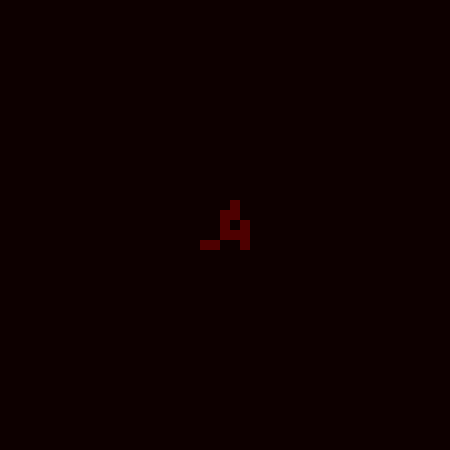
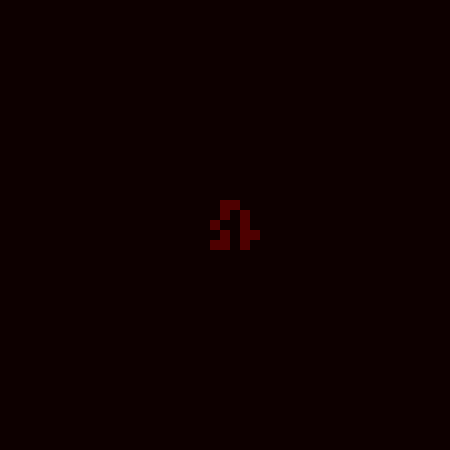
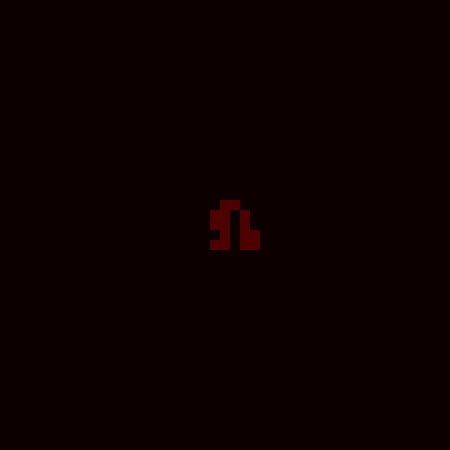
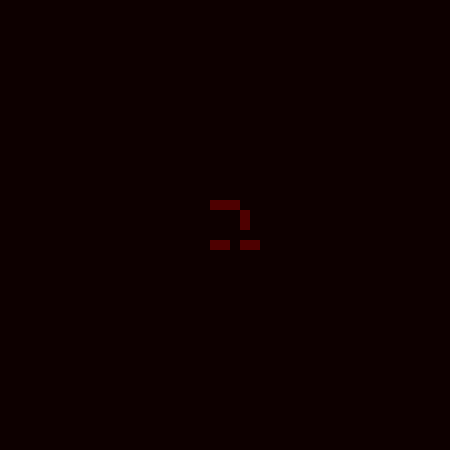
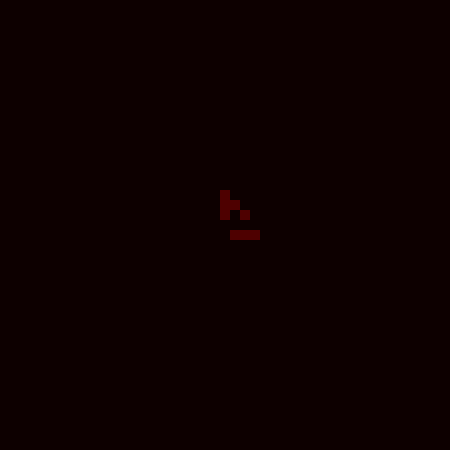
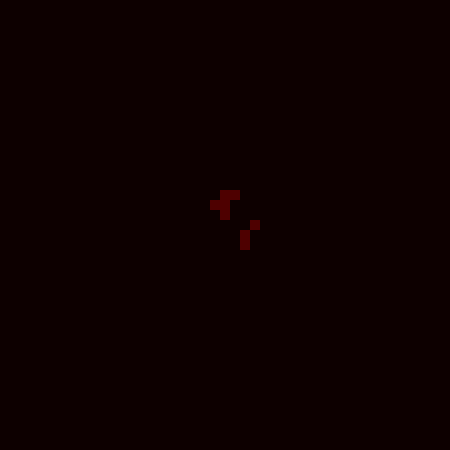
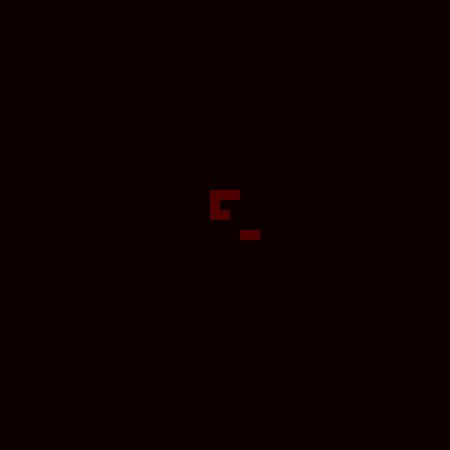
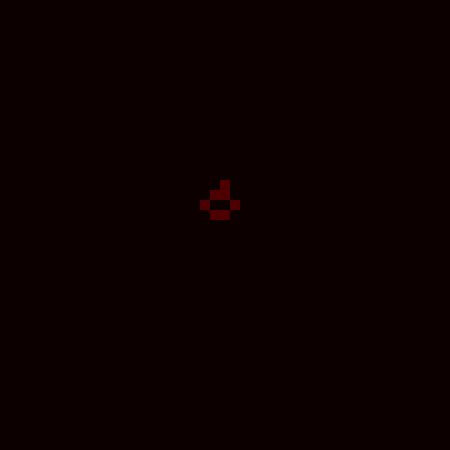
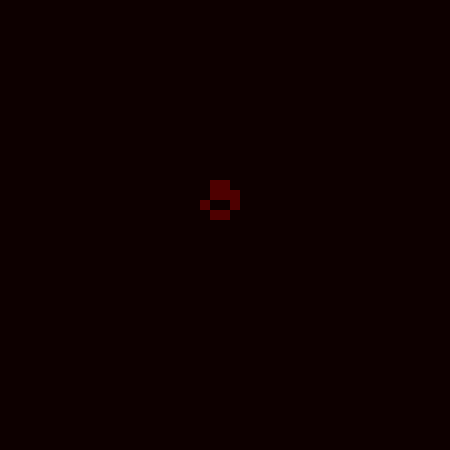
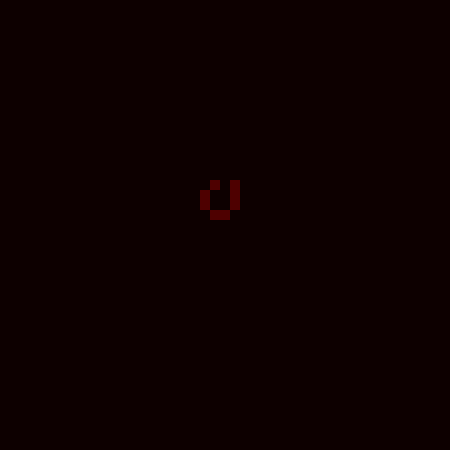
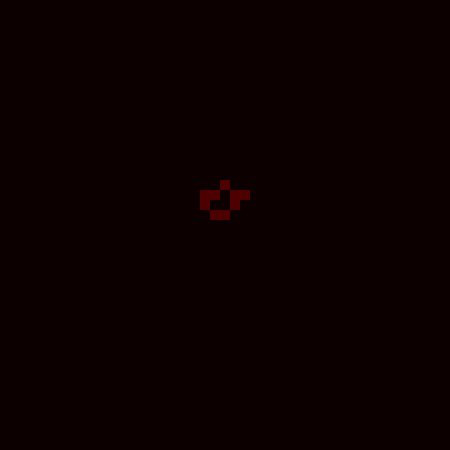
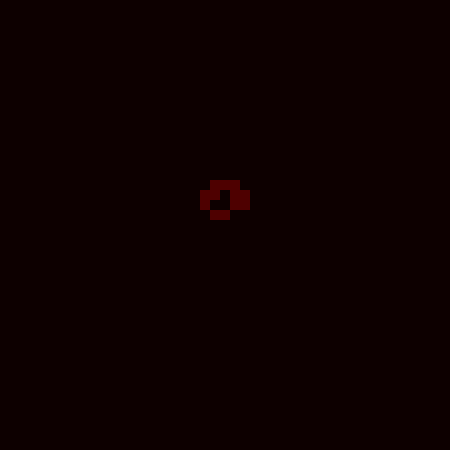
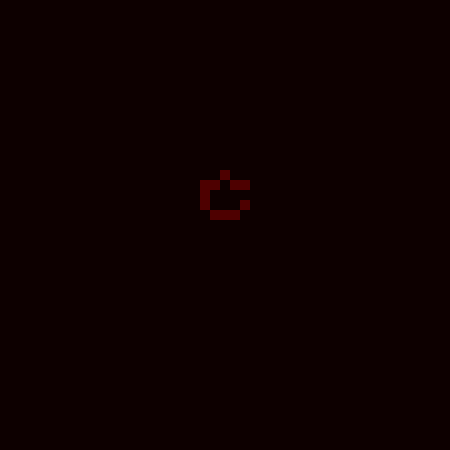
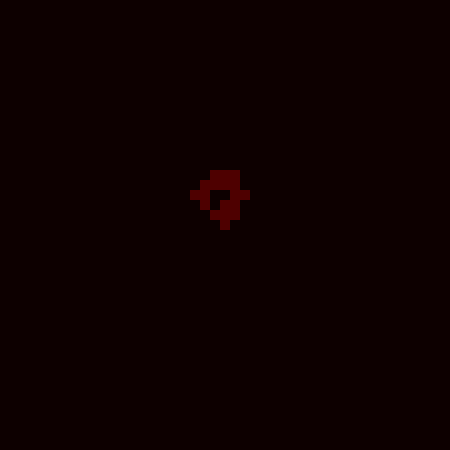
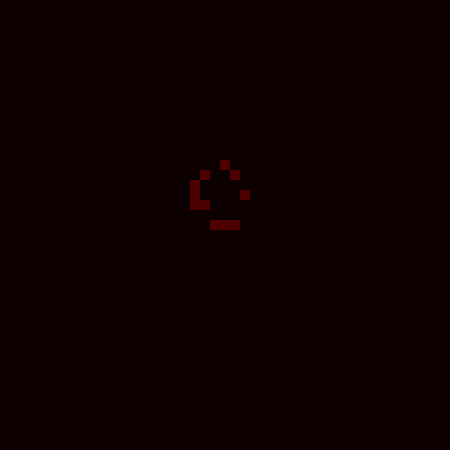
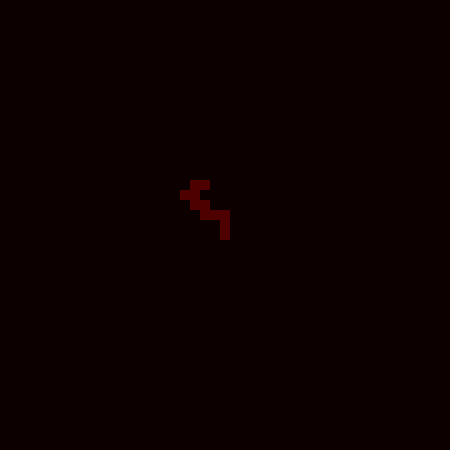
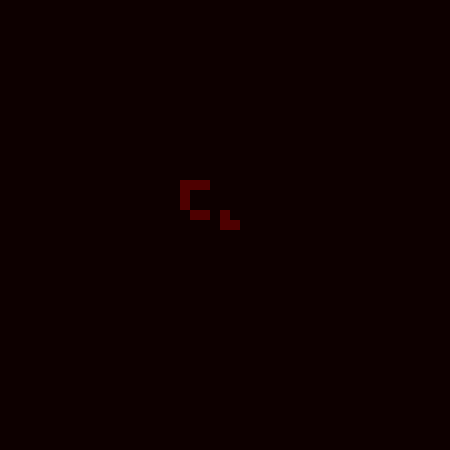
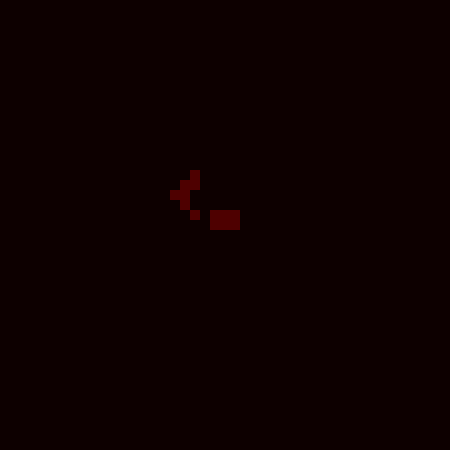
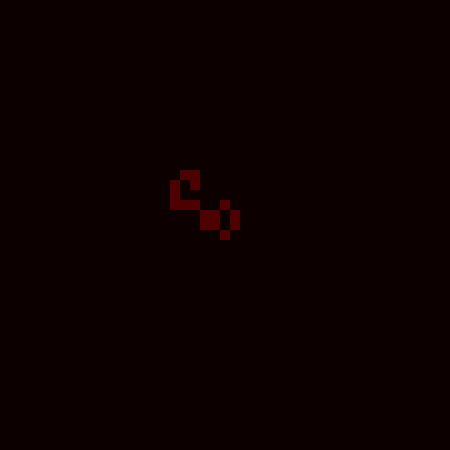
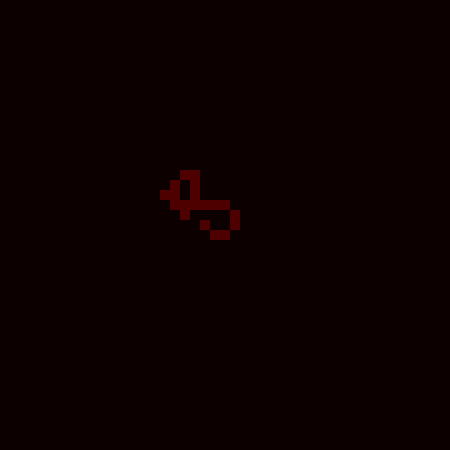
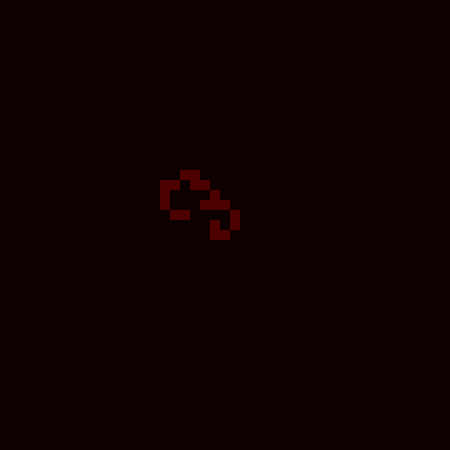
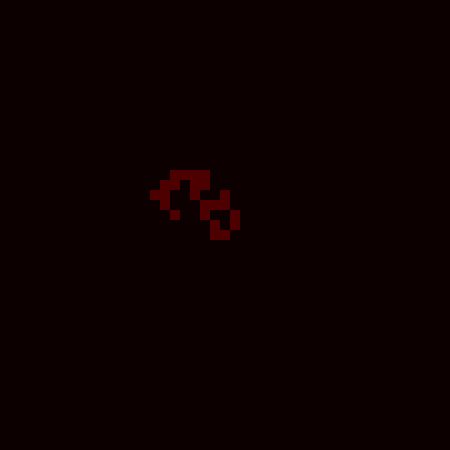
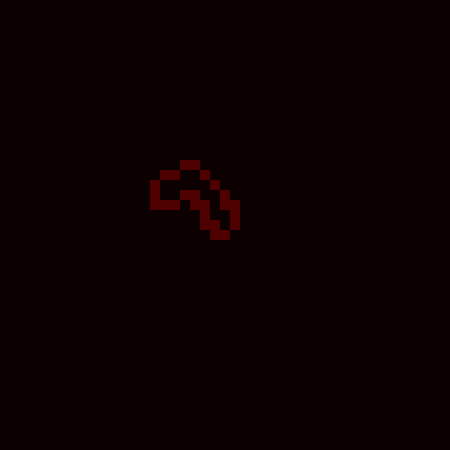
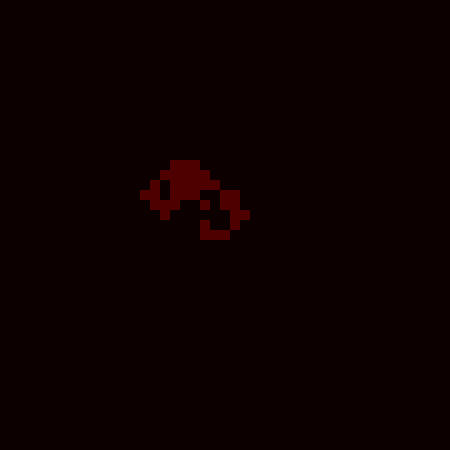
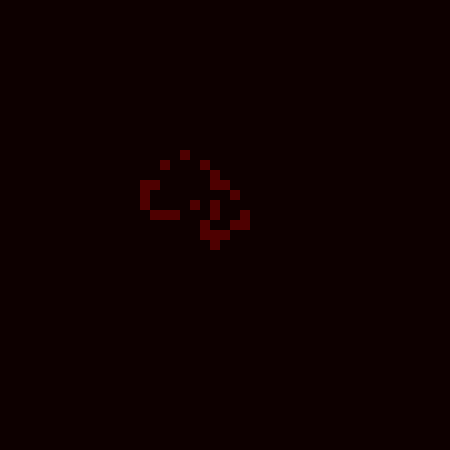
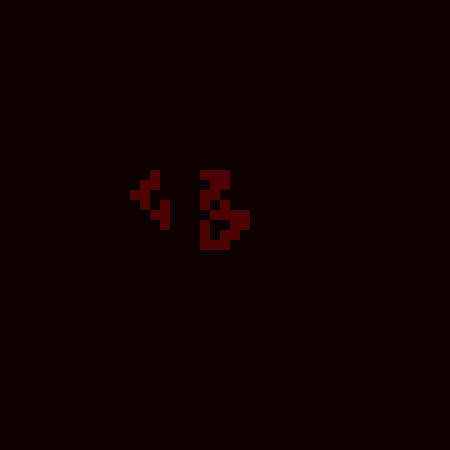
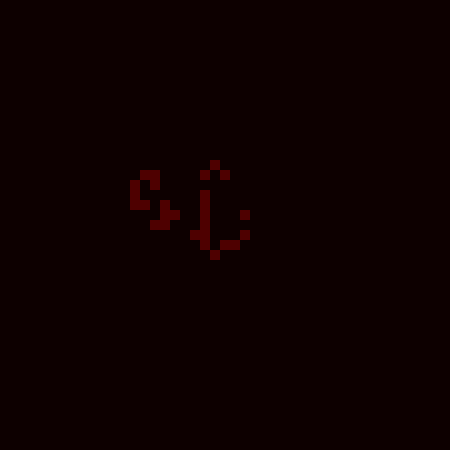
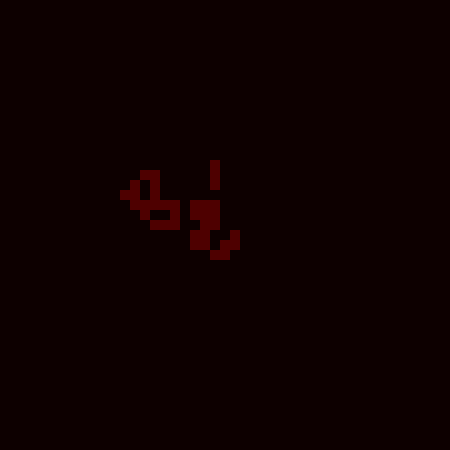
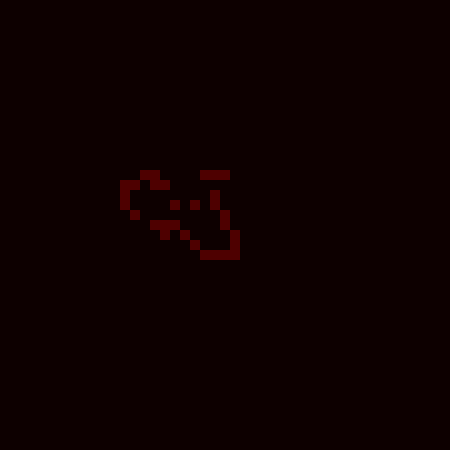
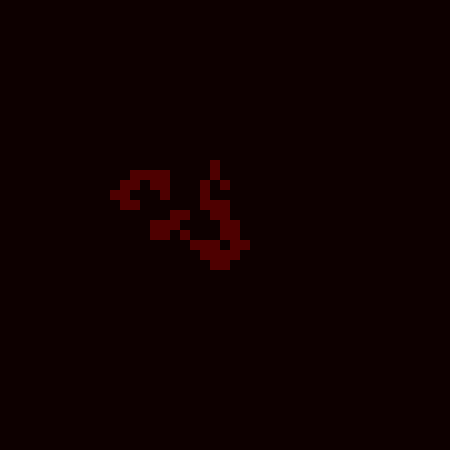
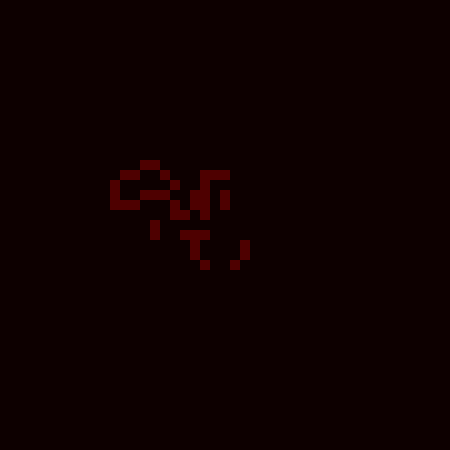
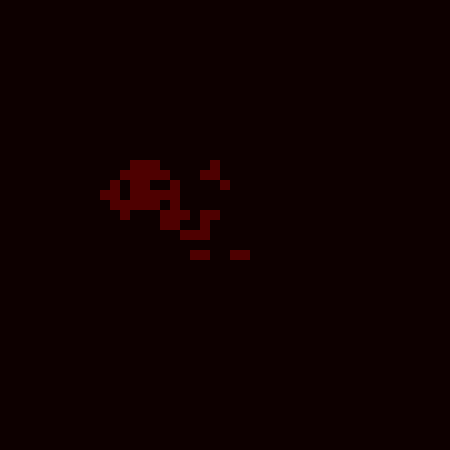
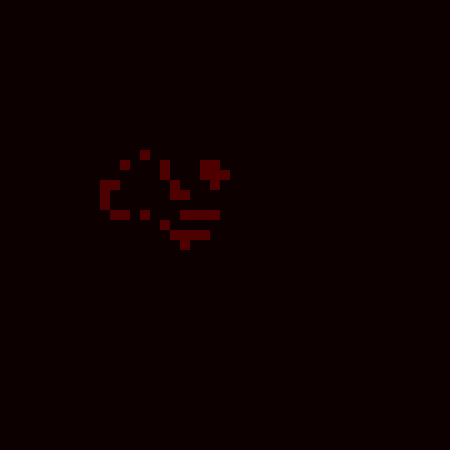
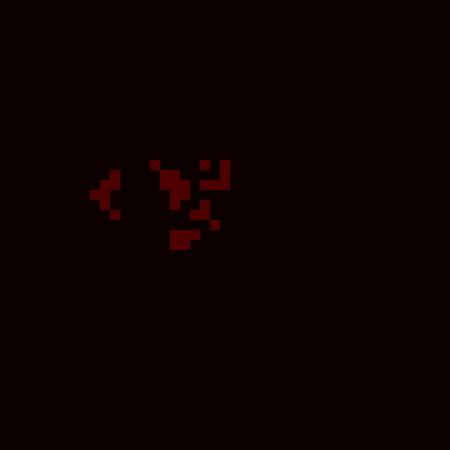
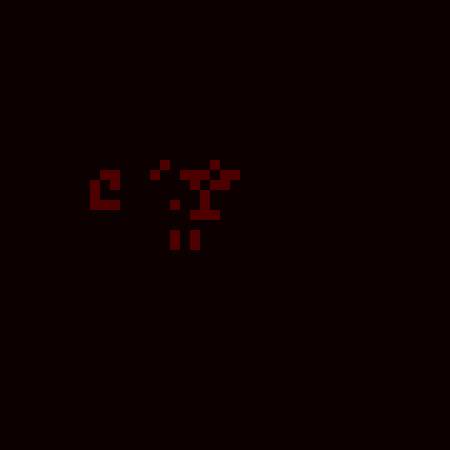
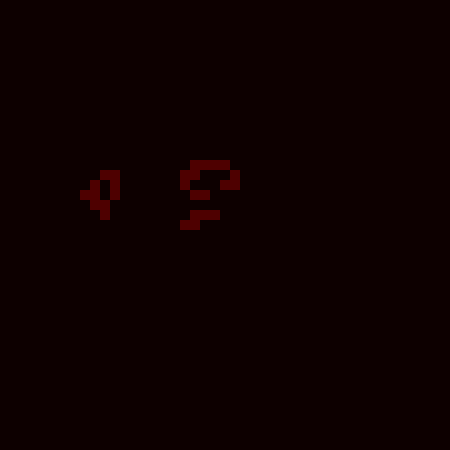
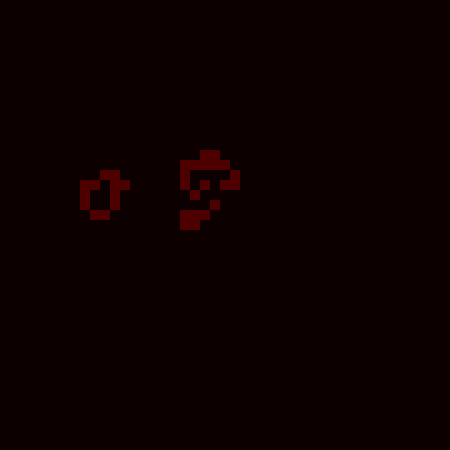
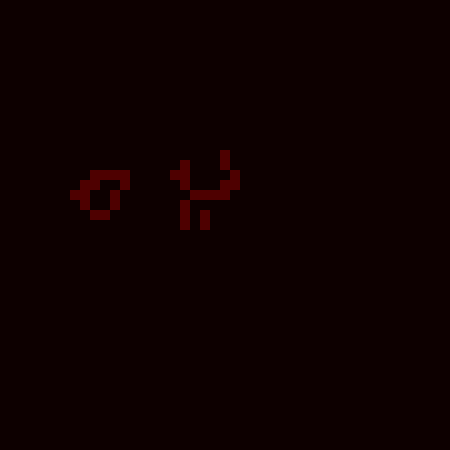
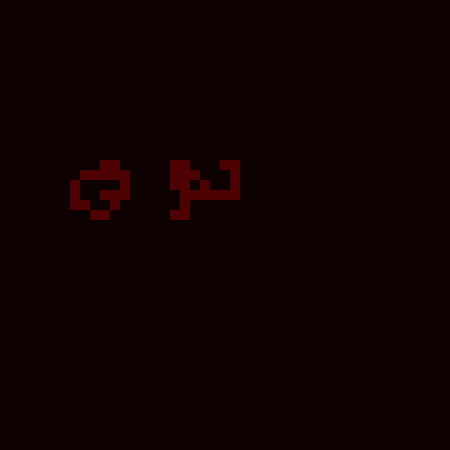
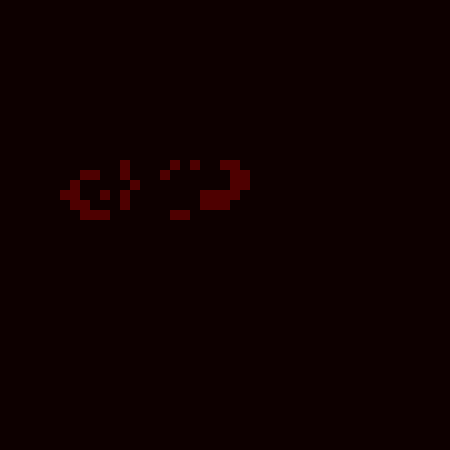
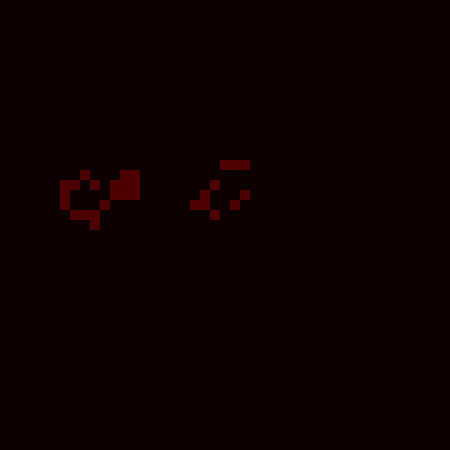
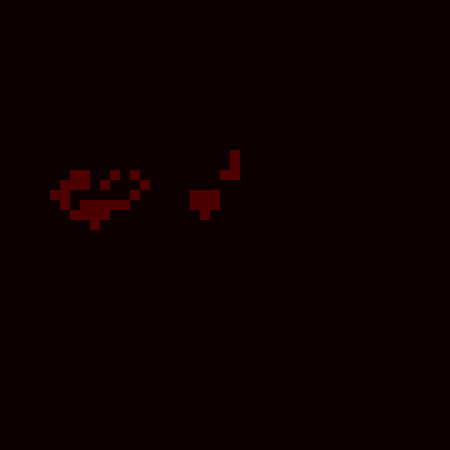
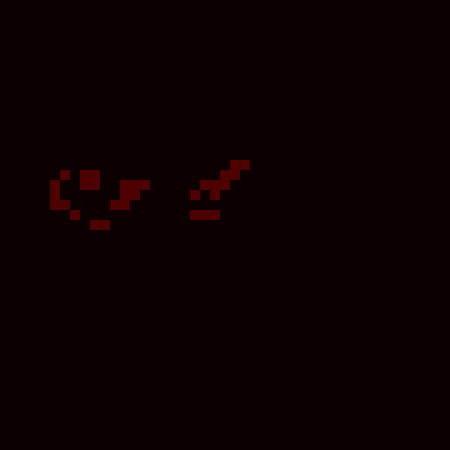
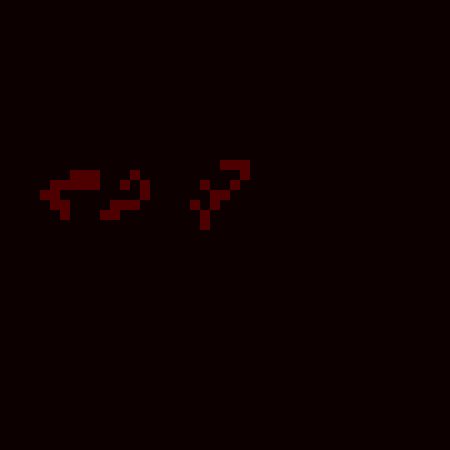
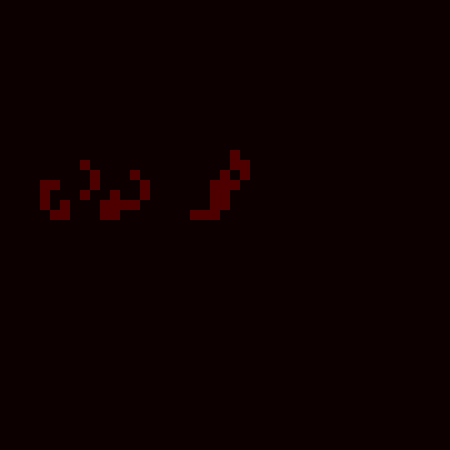
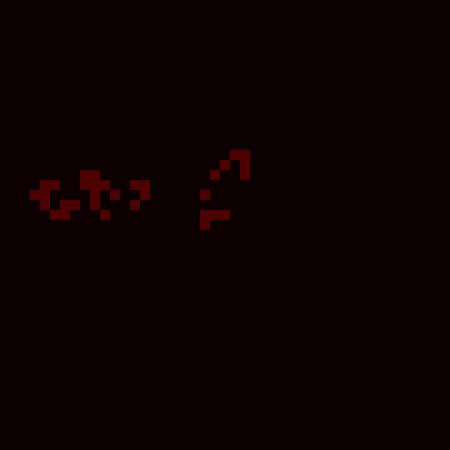
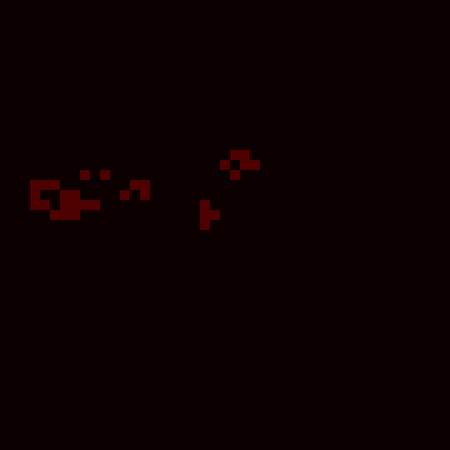
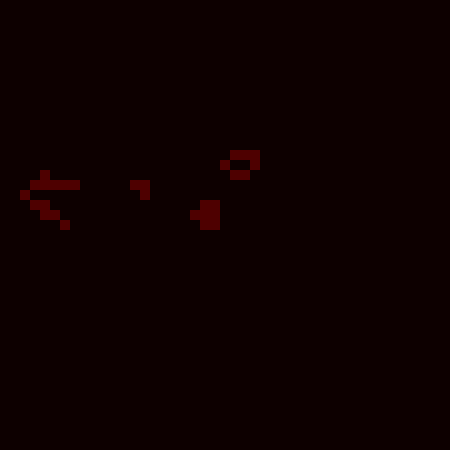
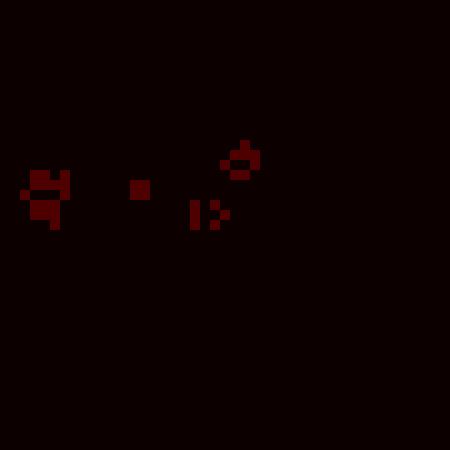
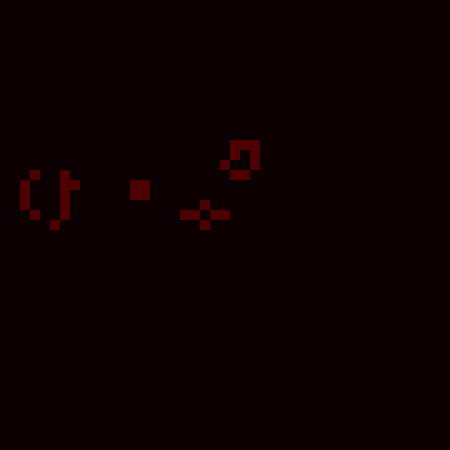
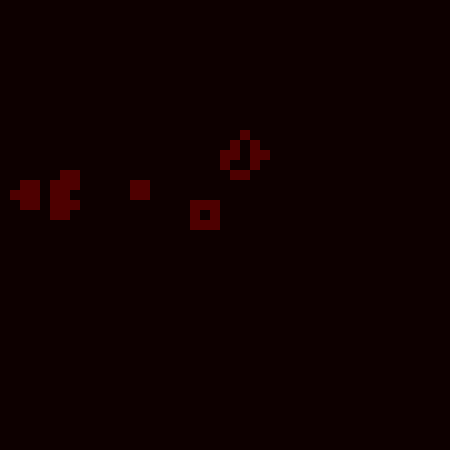
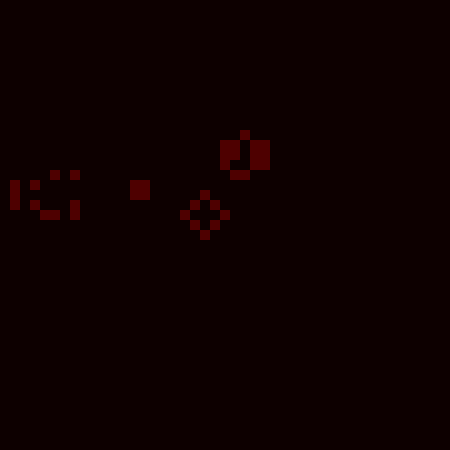
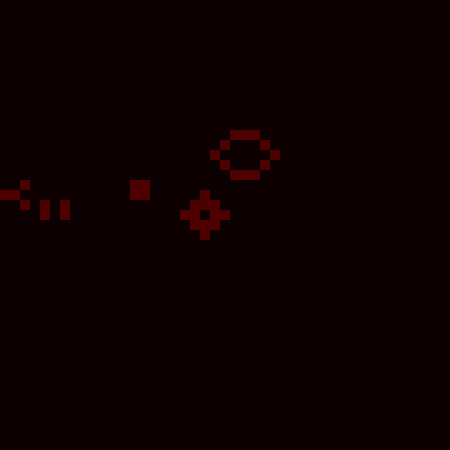
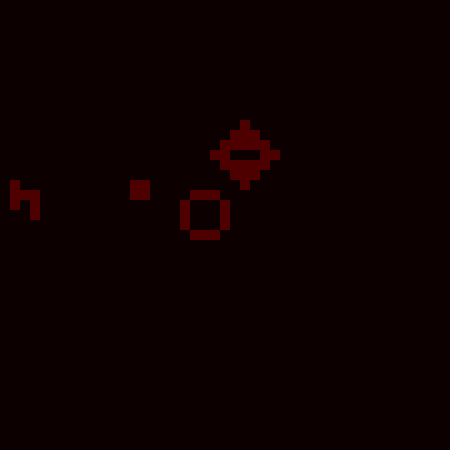
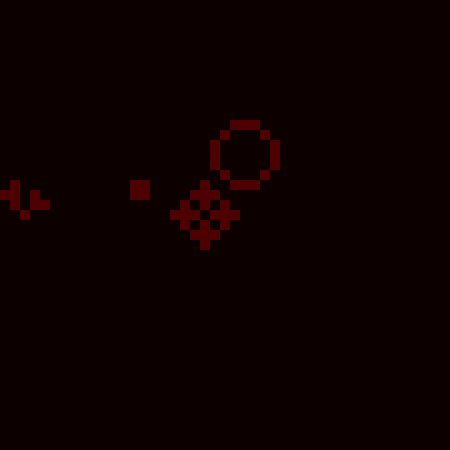
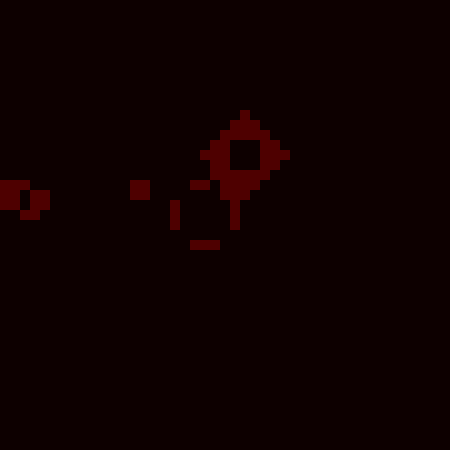
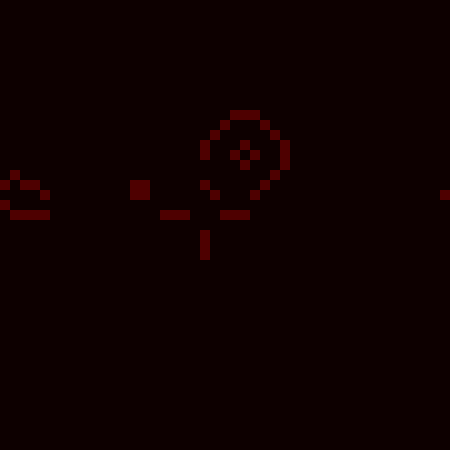
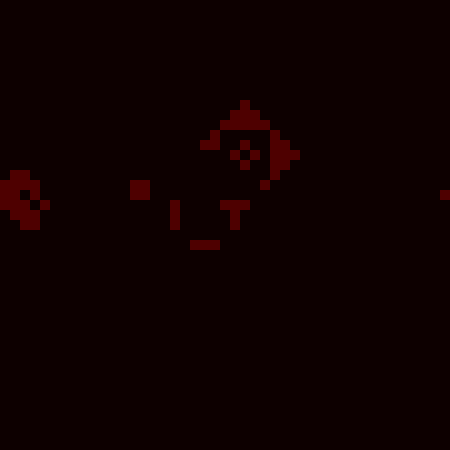
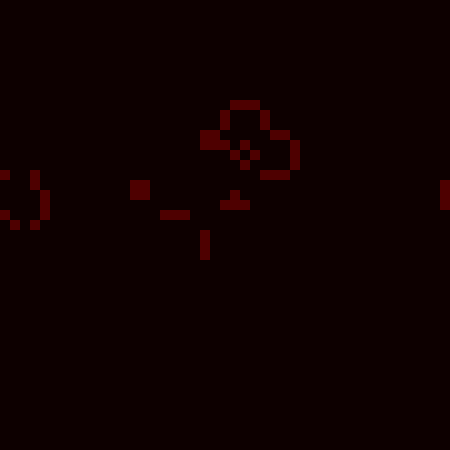
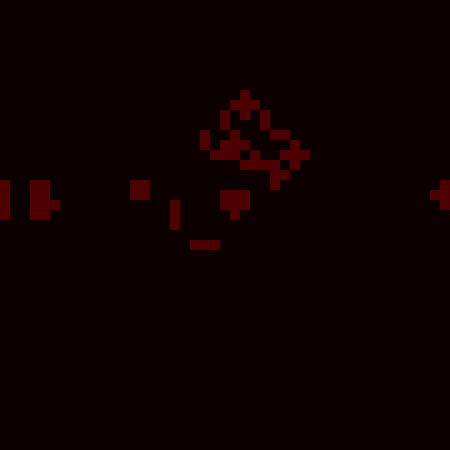
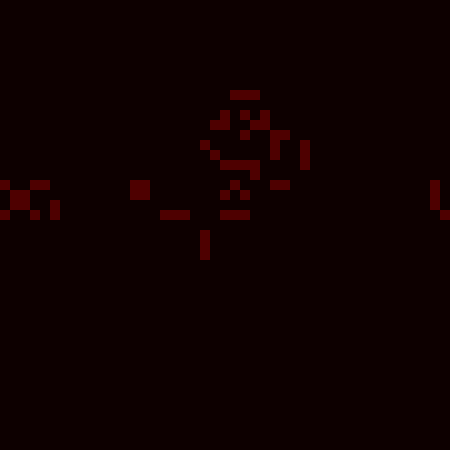
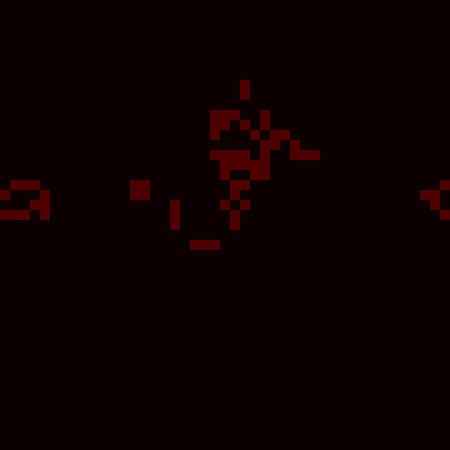
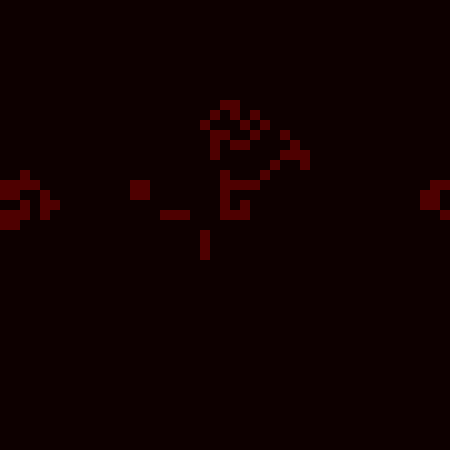
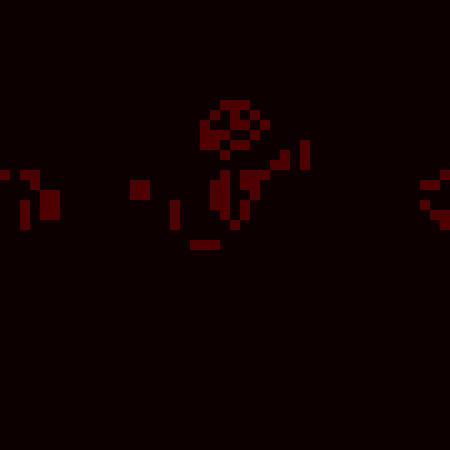
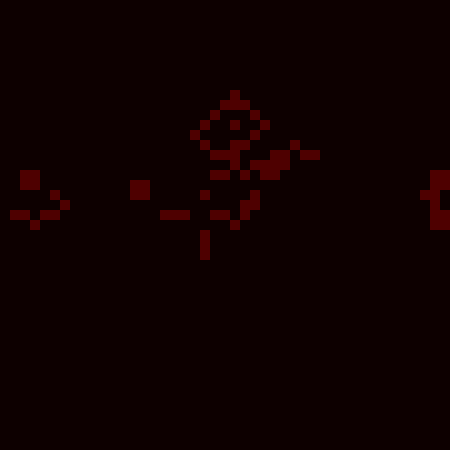
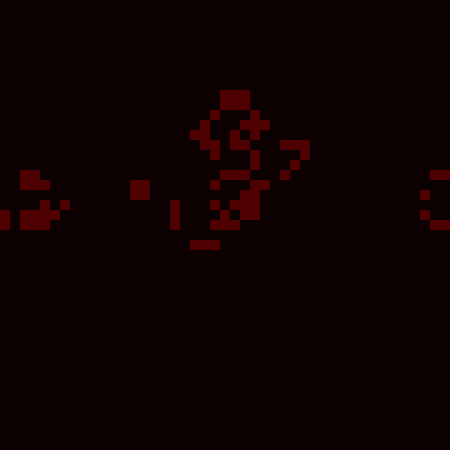
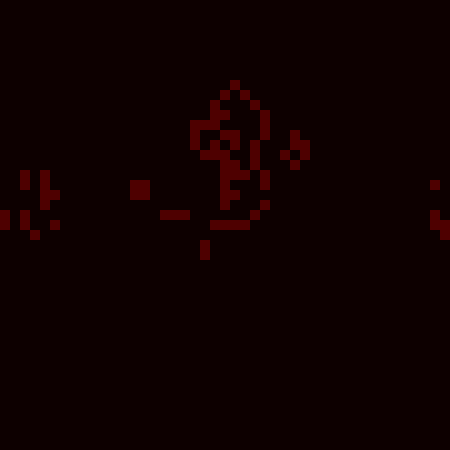
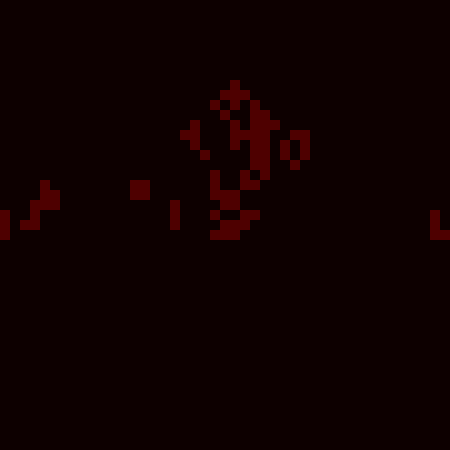
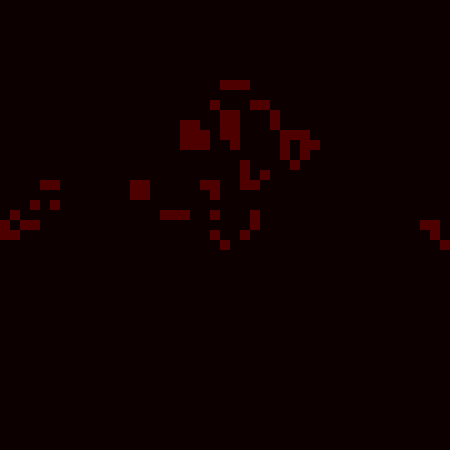
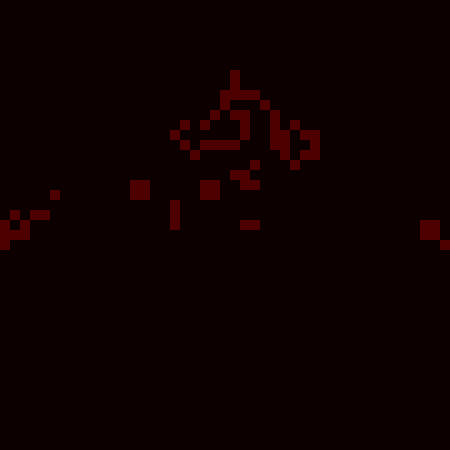
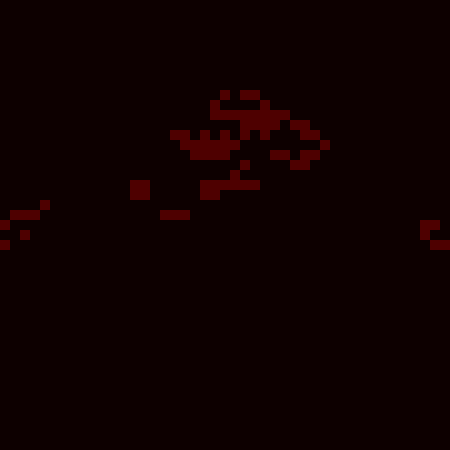
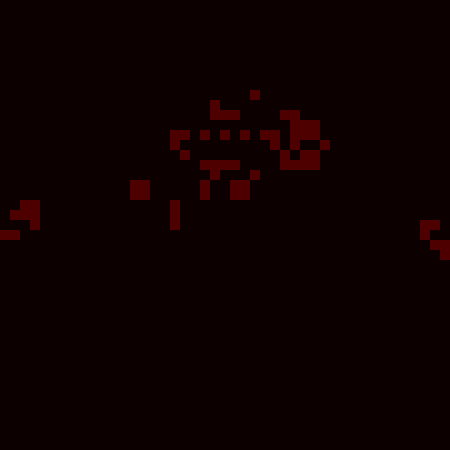
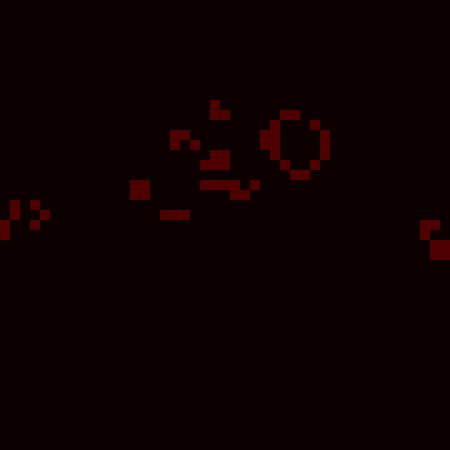
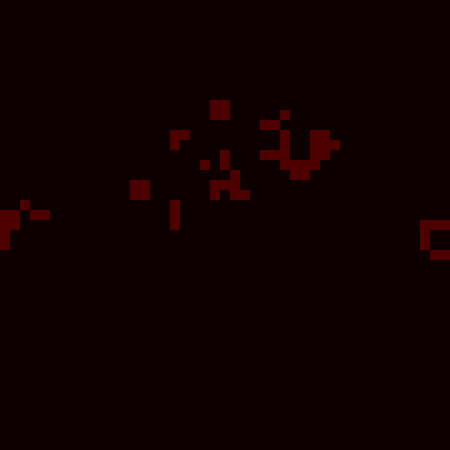
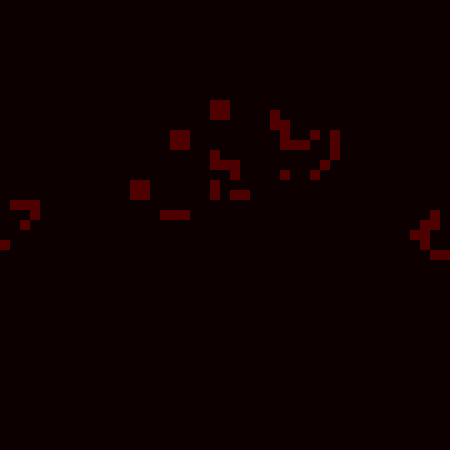
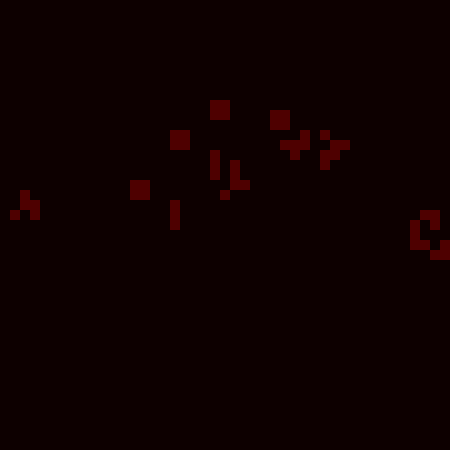
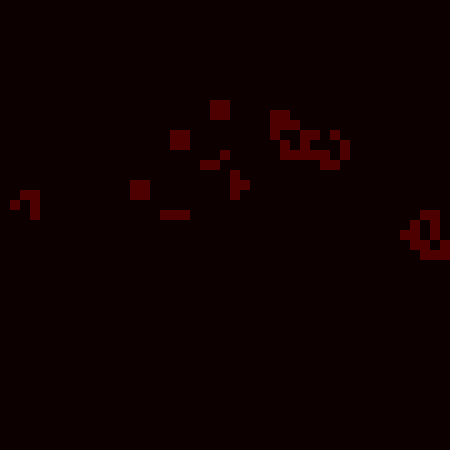
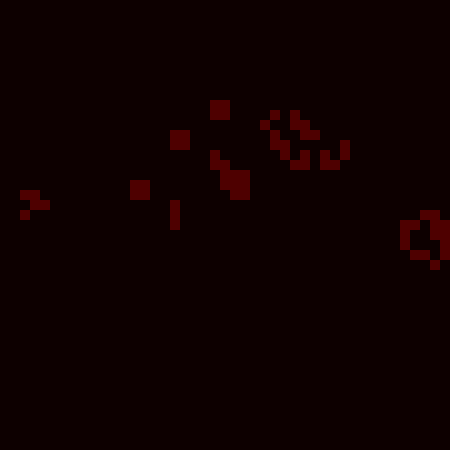
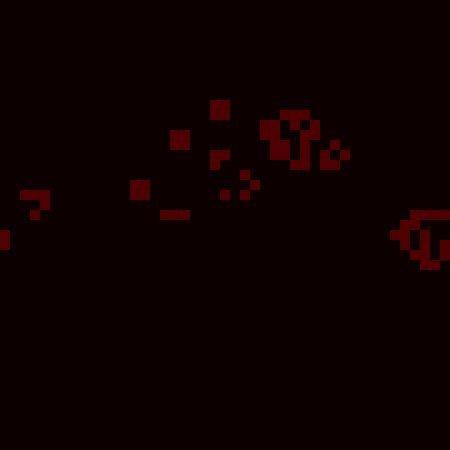
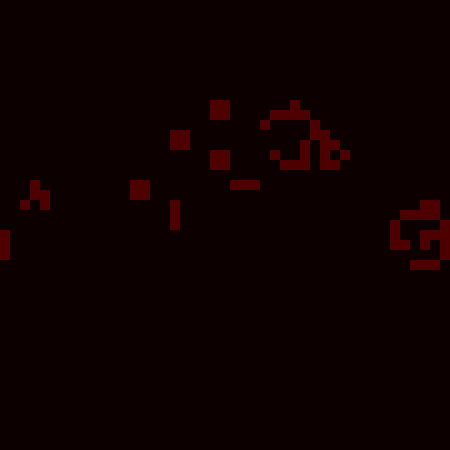
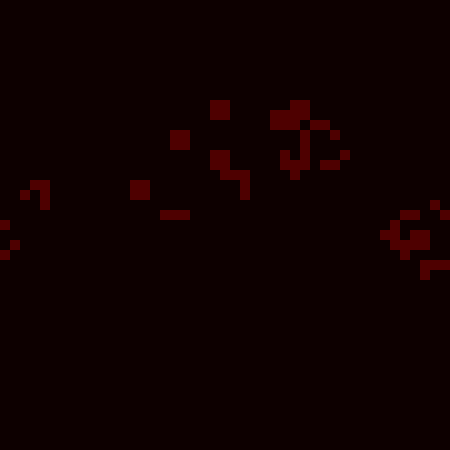
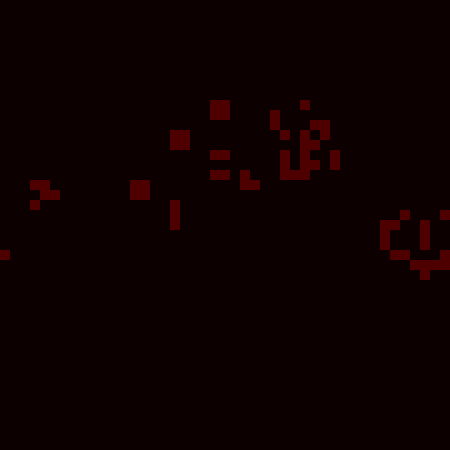
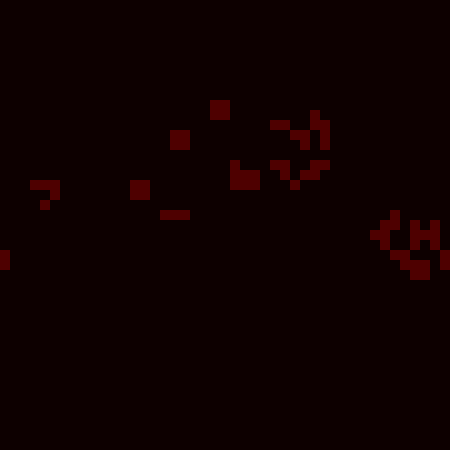
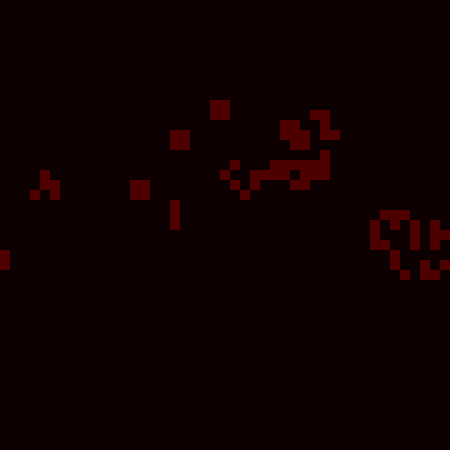
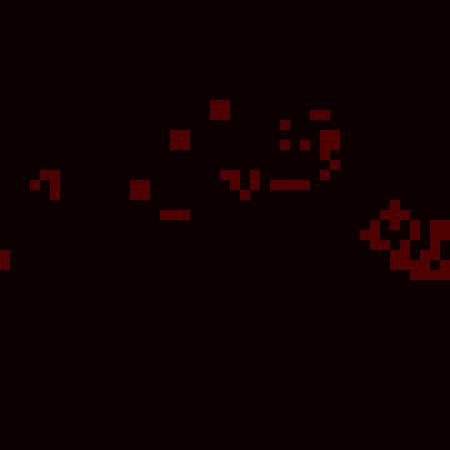
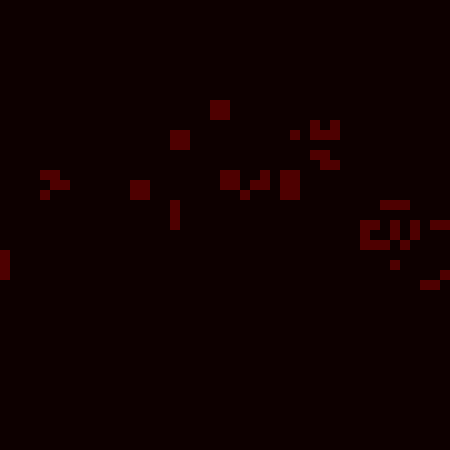
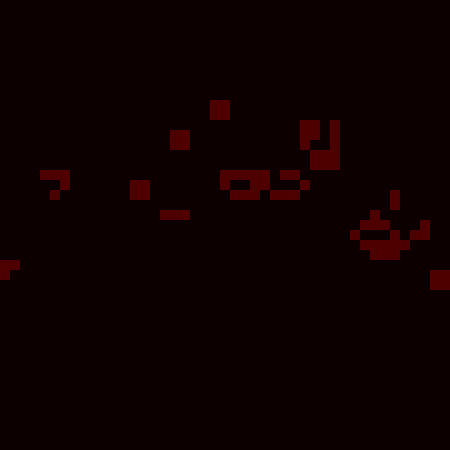
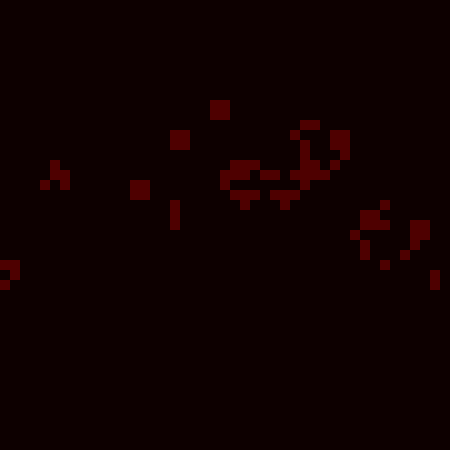
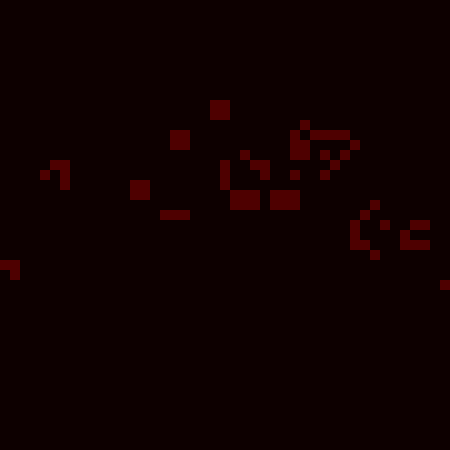
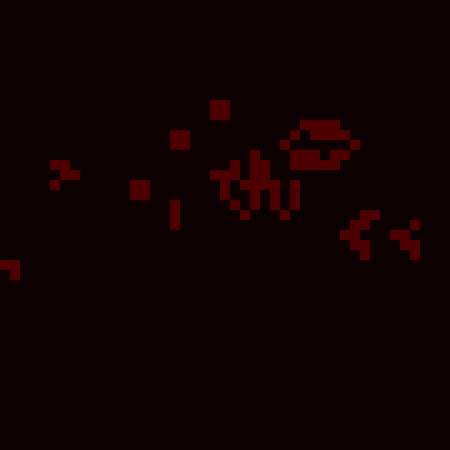
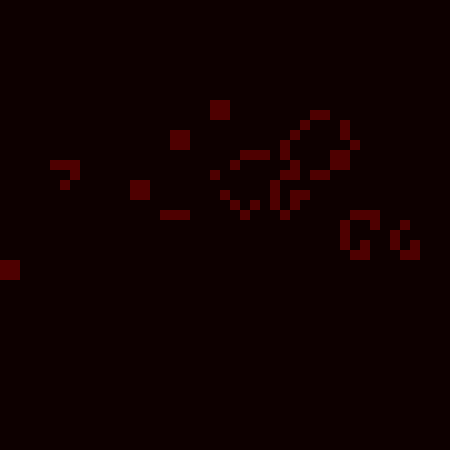
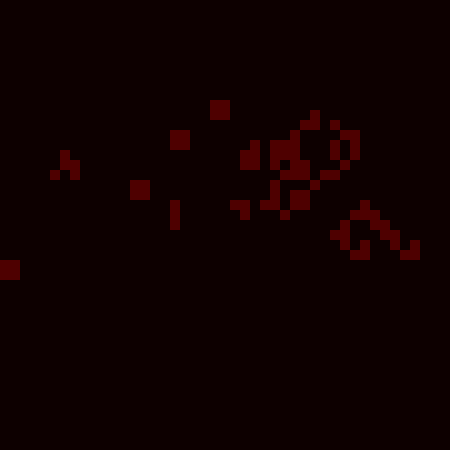
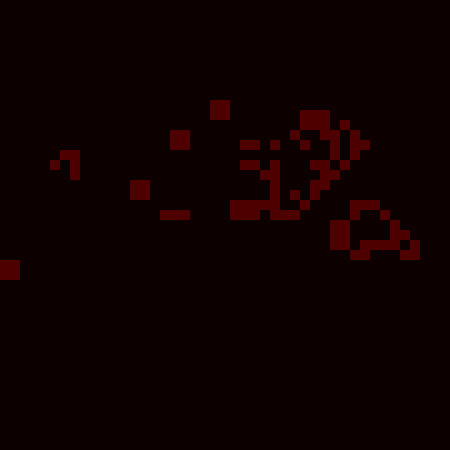
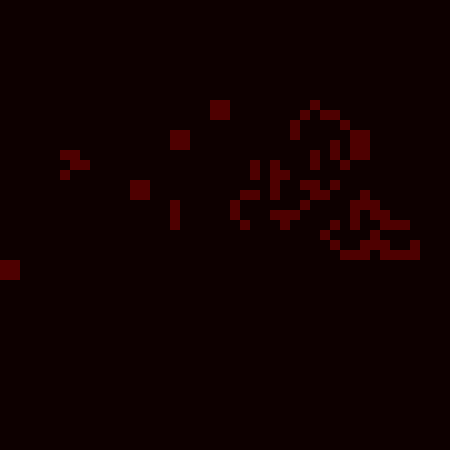
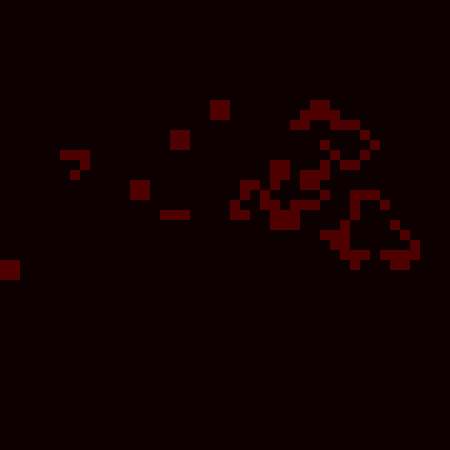
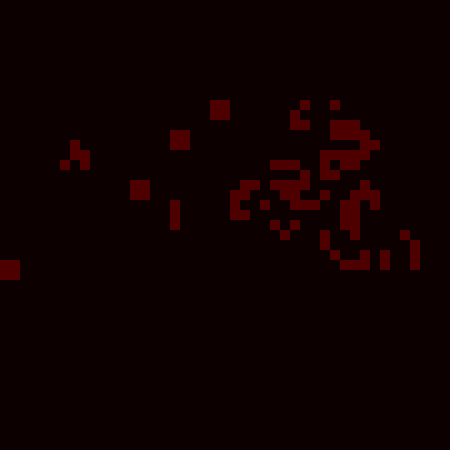
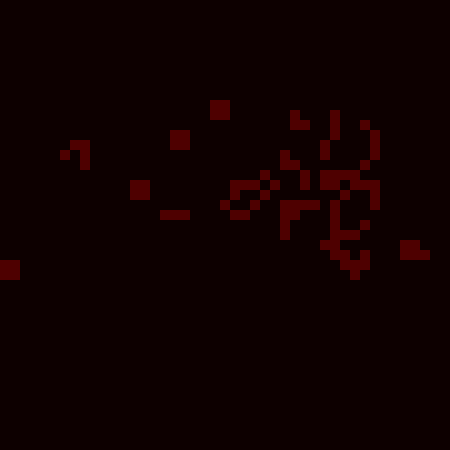
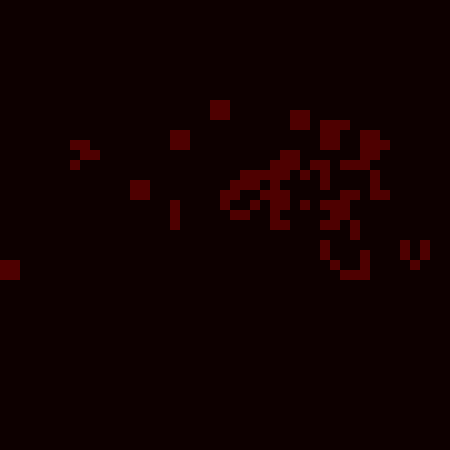
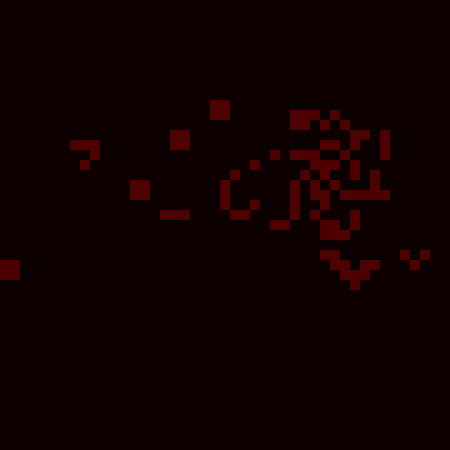
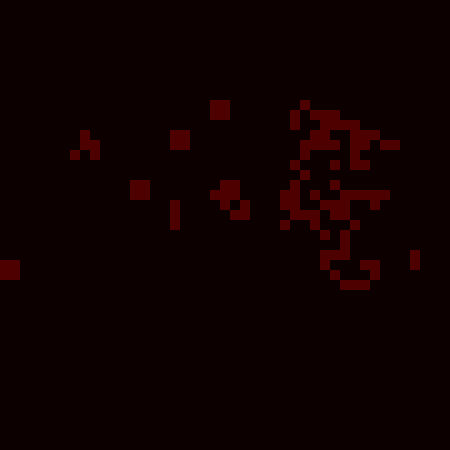

In [8]:
bottom_ind = top_inds[(int(sample_n/2))]
bottom_im = generated[bottom_ind].reshape([xd,yd])
print(bottom_im)
life_animation(add_border(generated[bottom_ind].reshape([xd,yd]), border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 1.]]



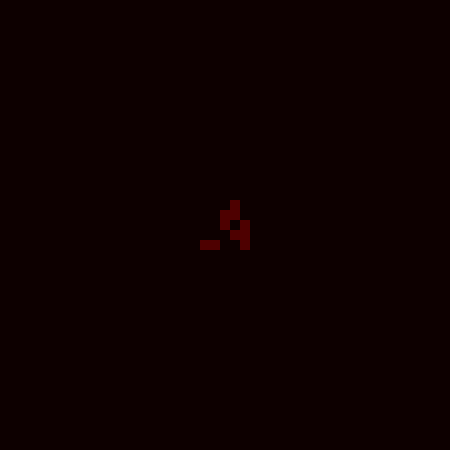
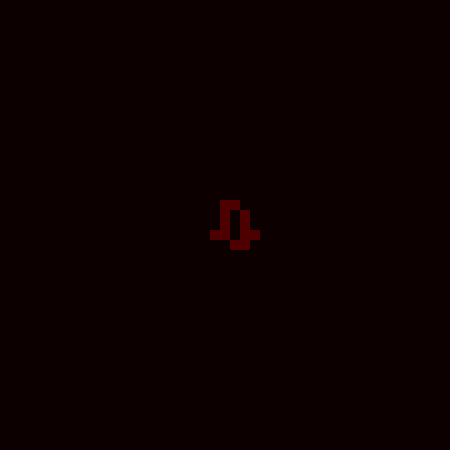
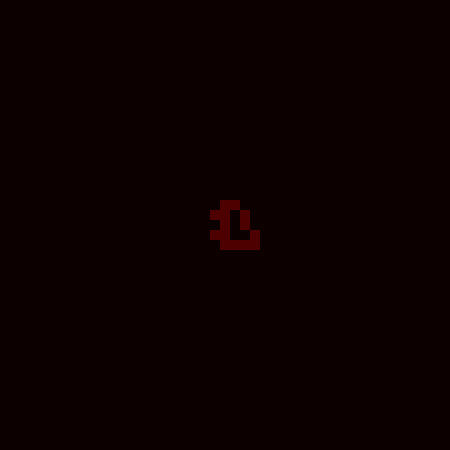
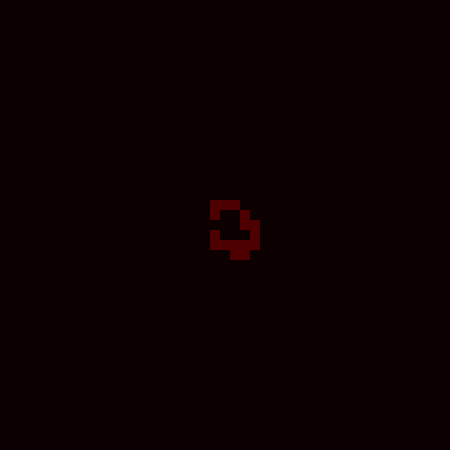
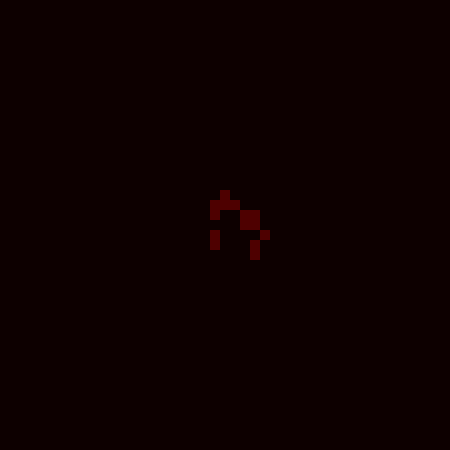
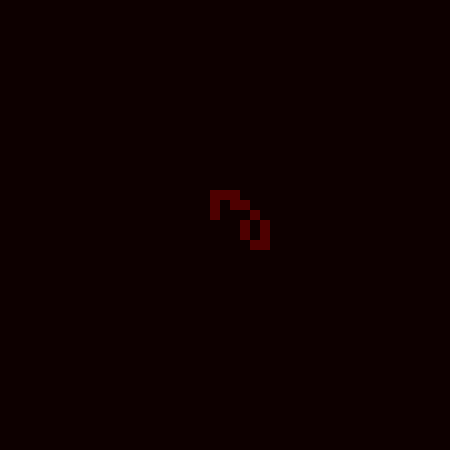
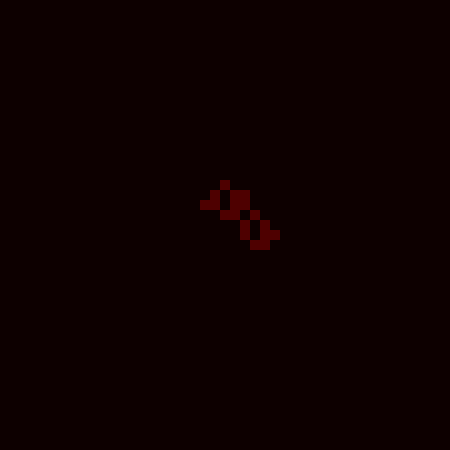
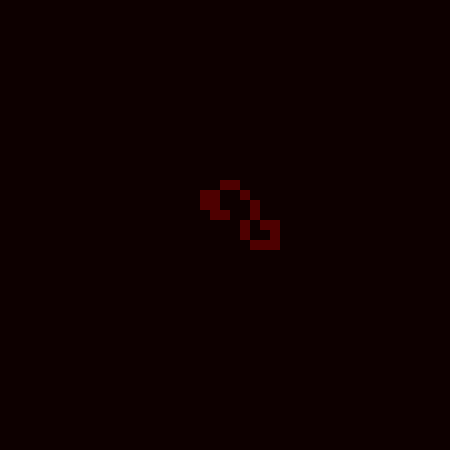
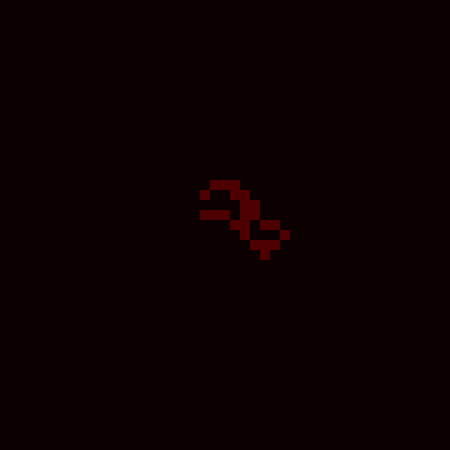
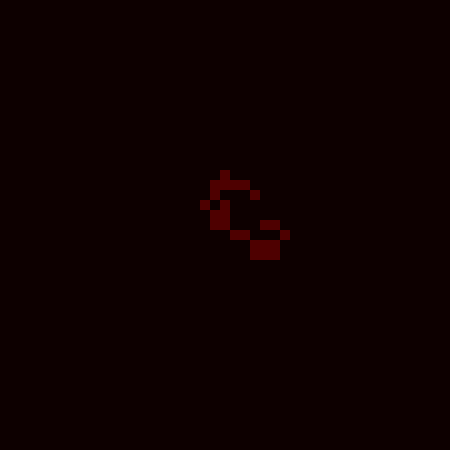
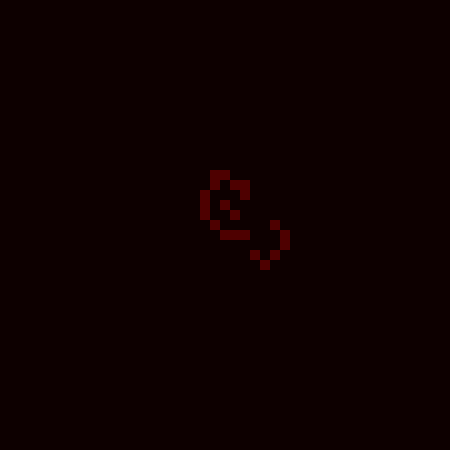
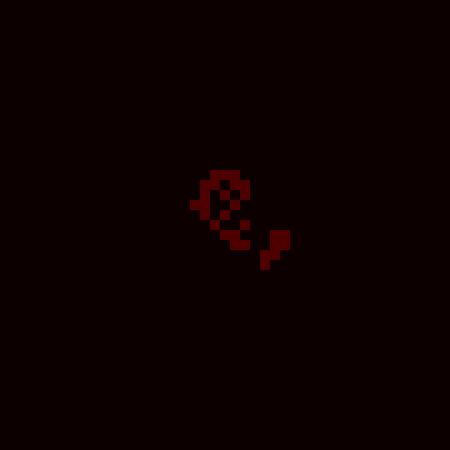
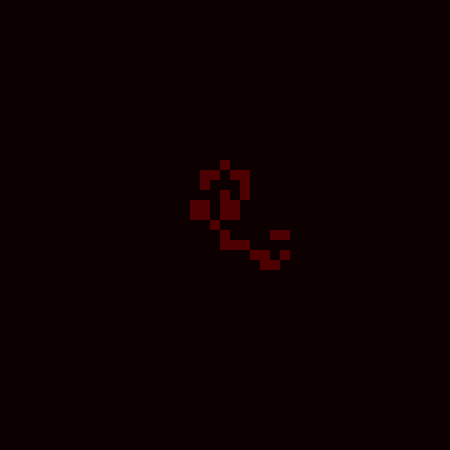
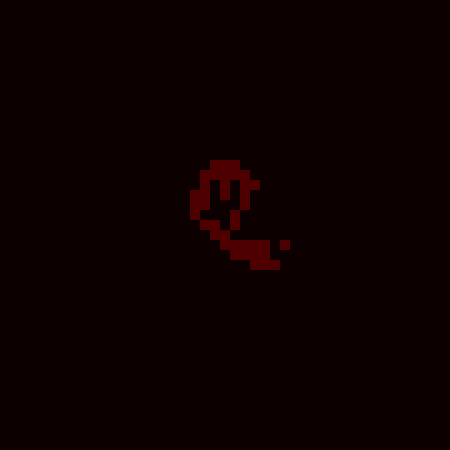
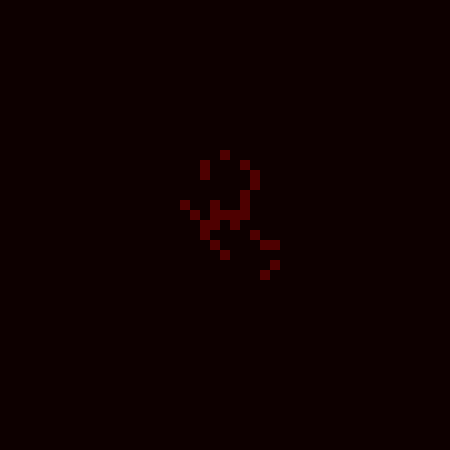
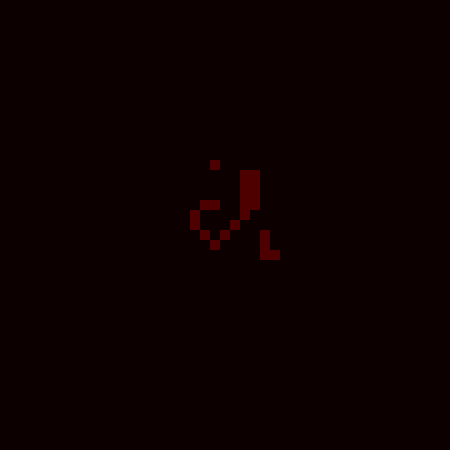
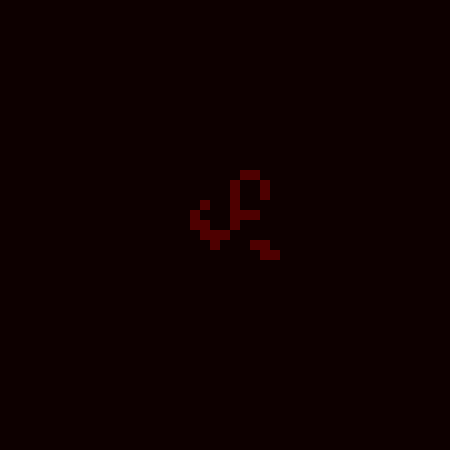
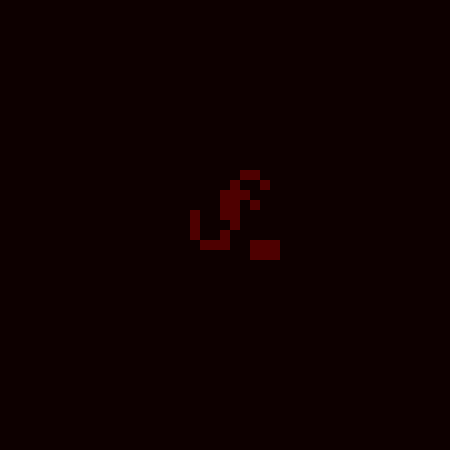
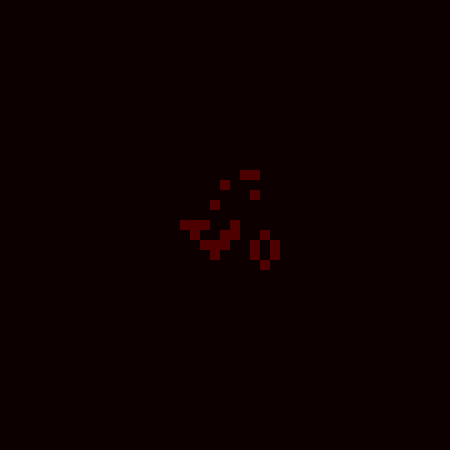
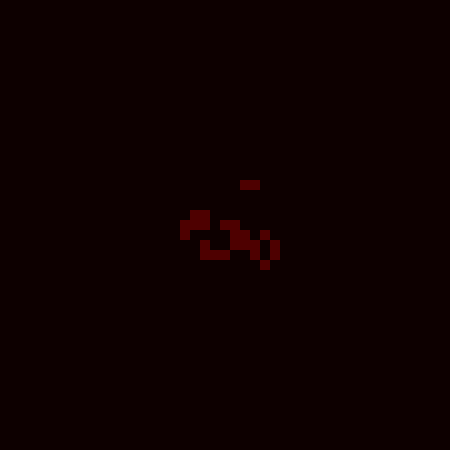
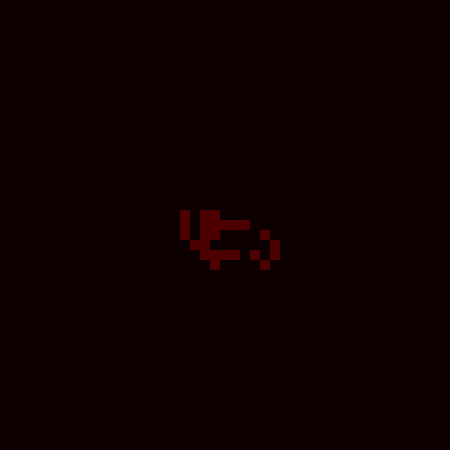
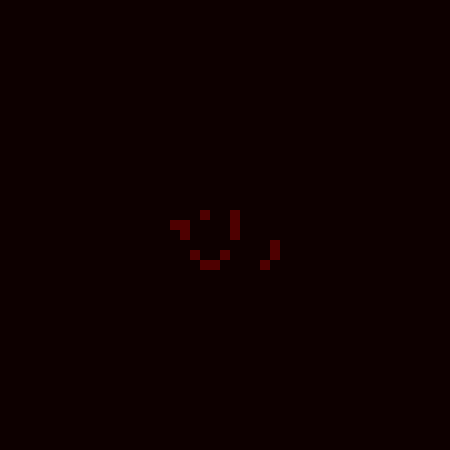
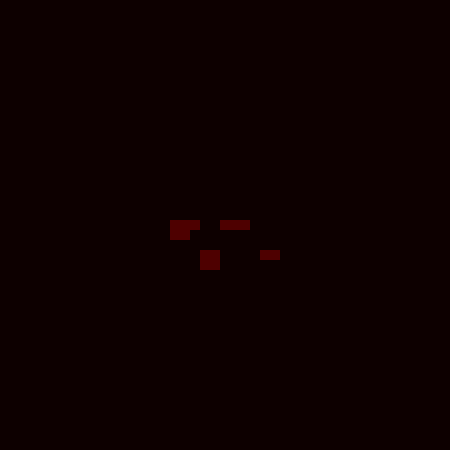
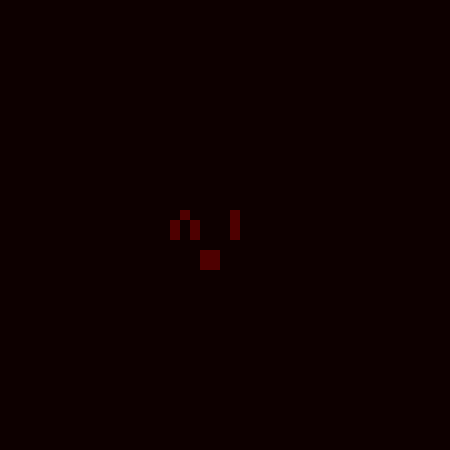
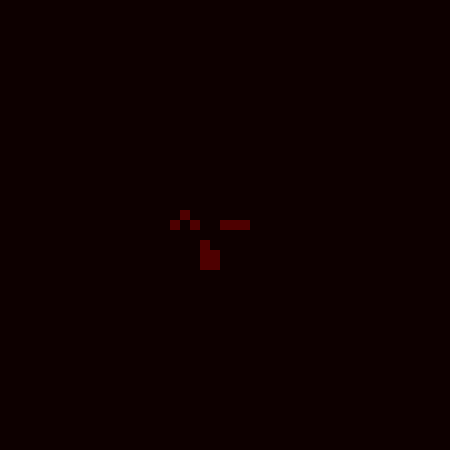
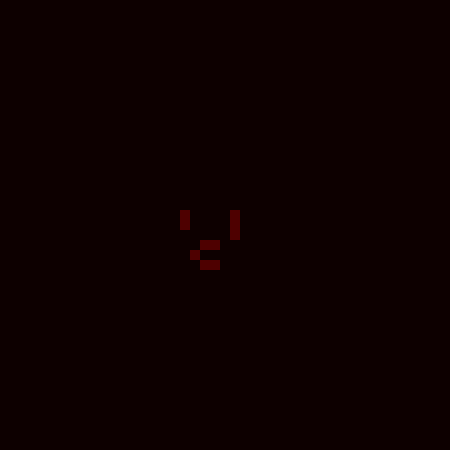
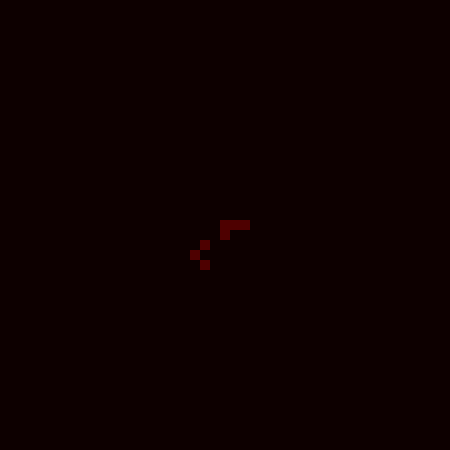
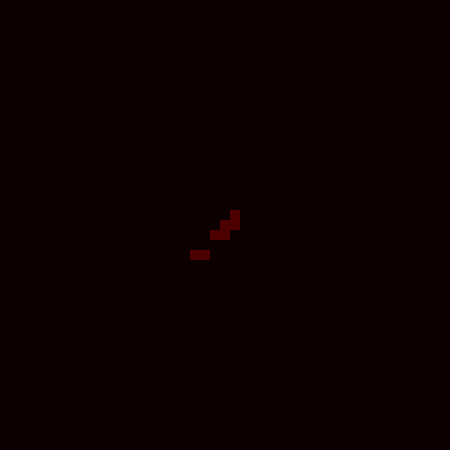
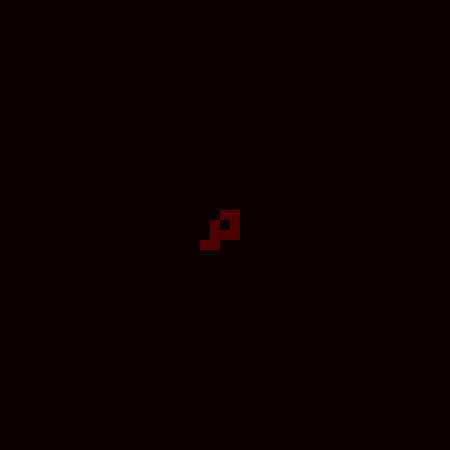
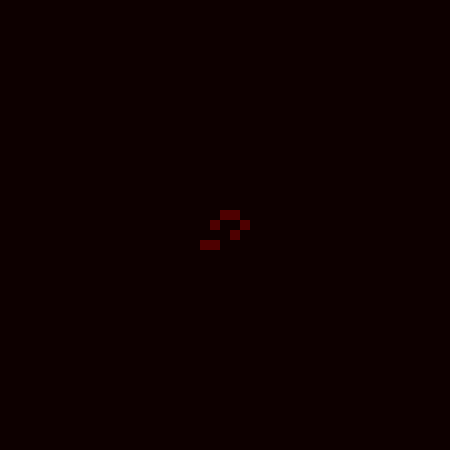
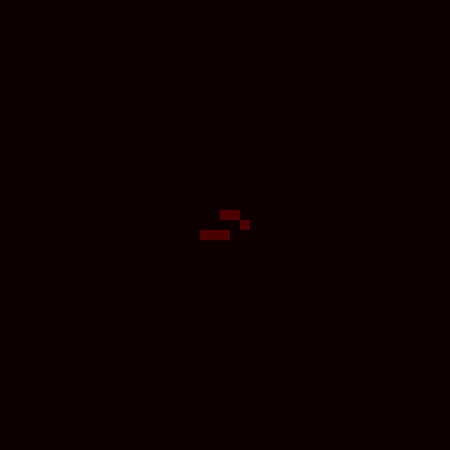
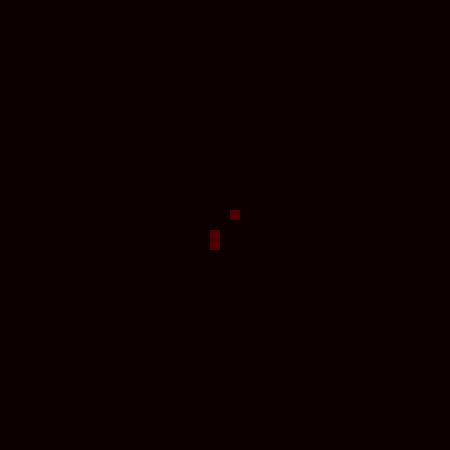
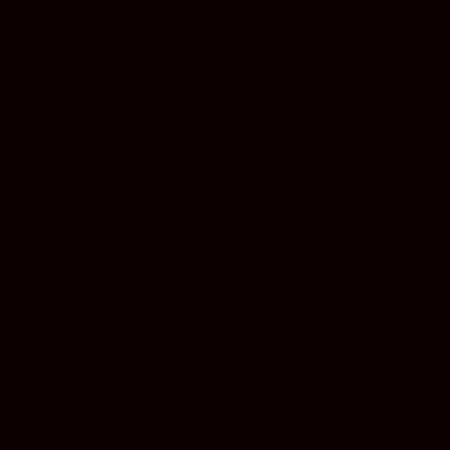
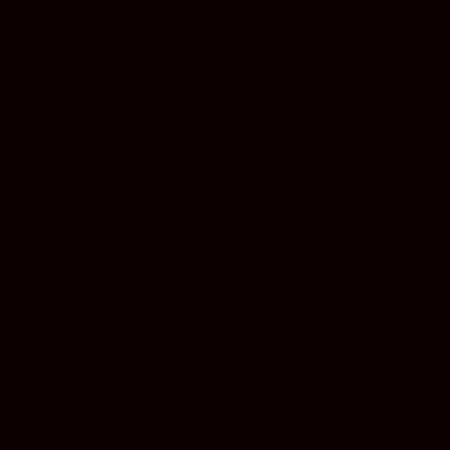
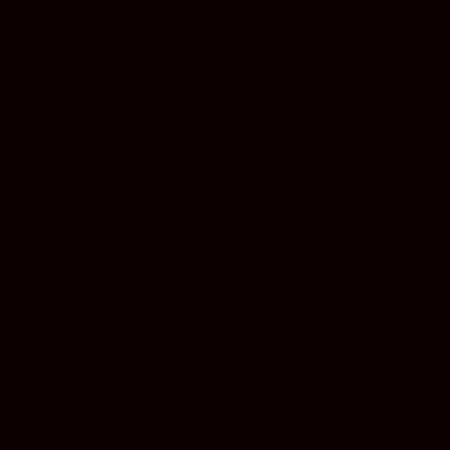
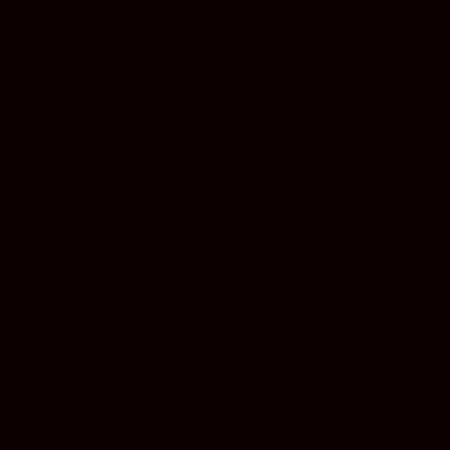
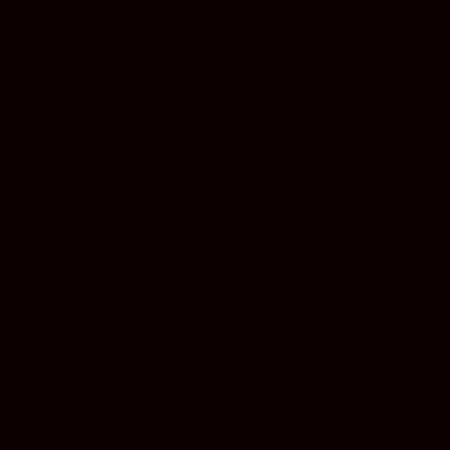
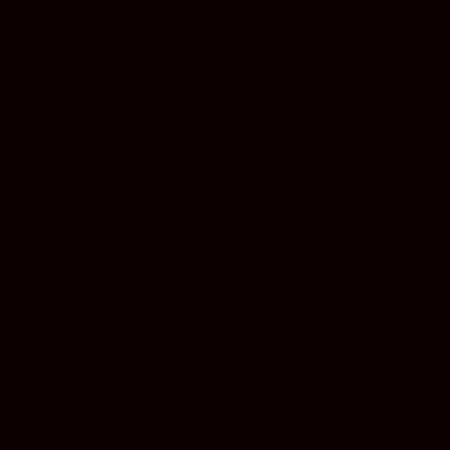
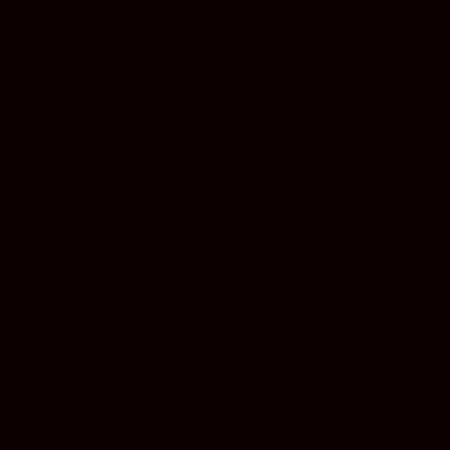
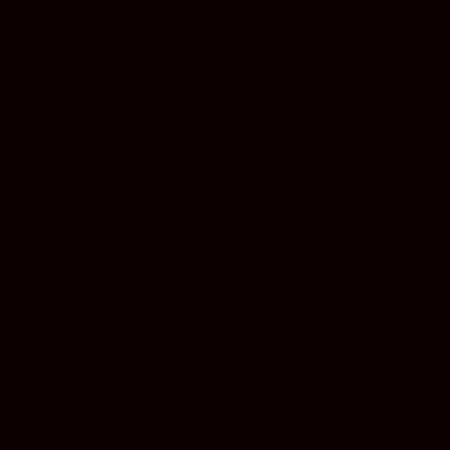
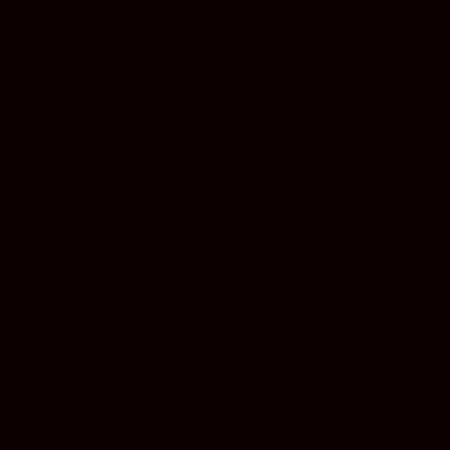
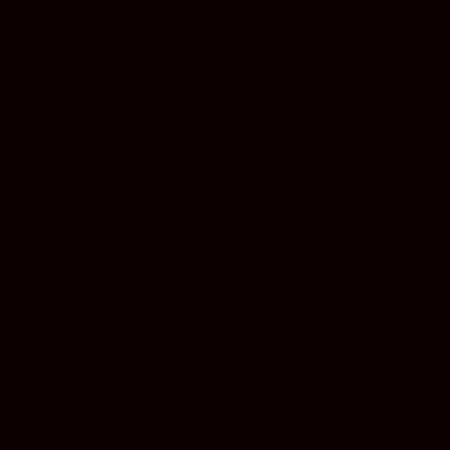
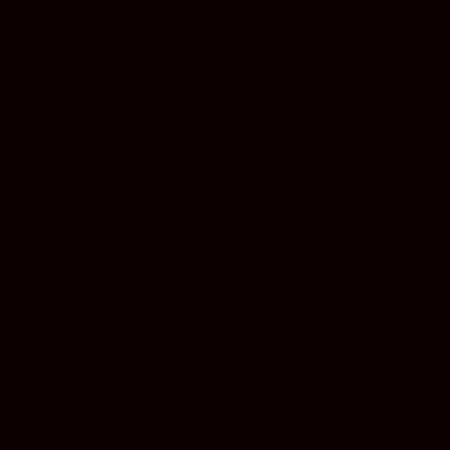
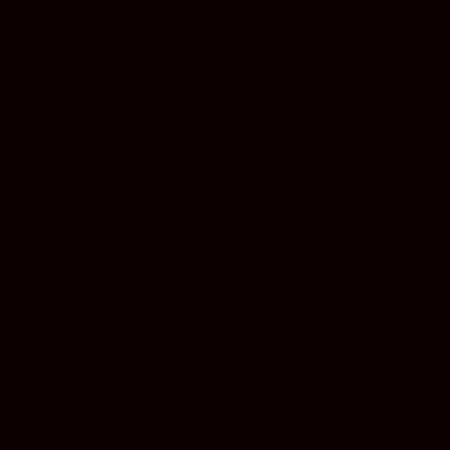
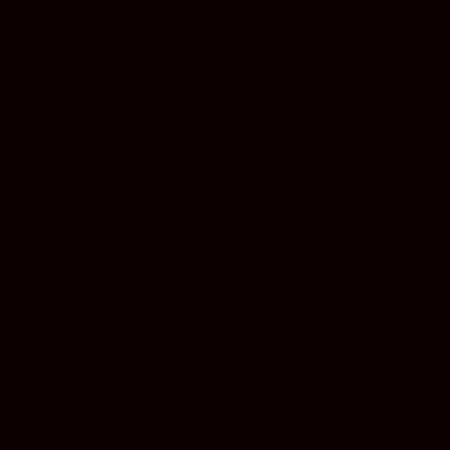
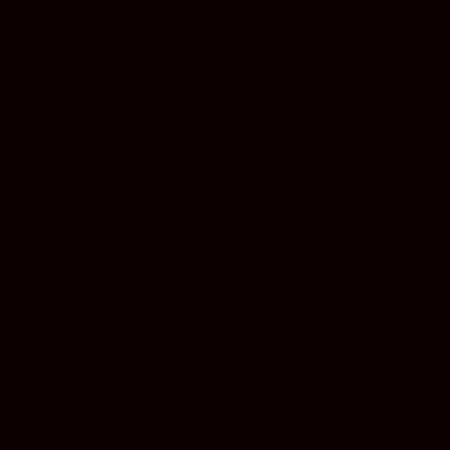
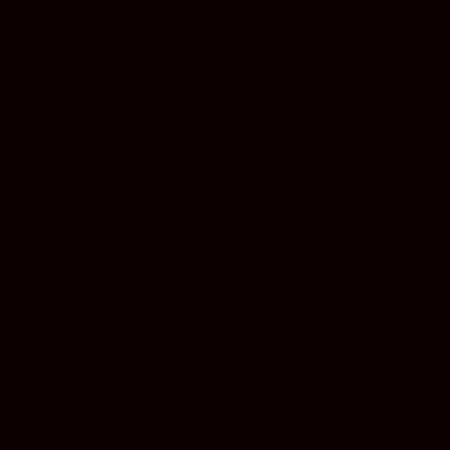
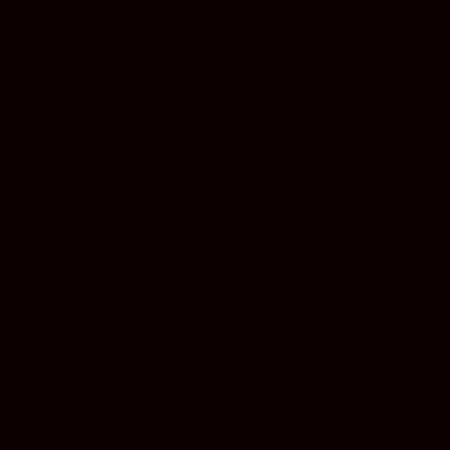
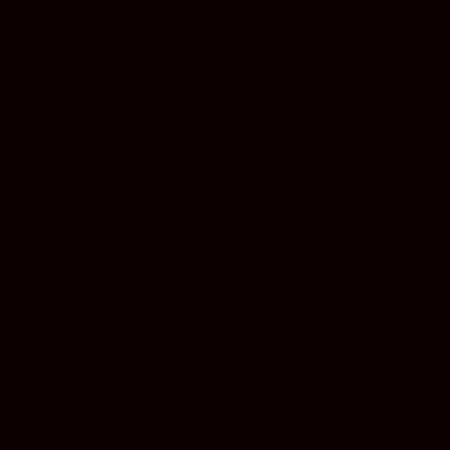
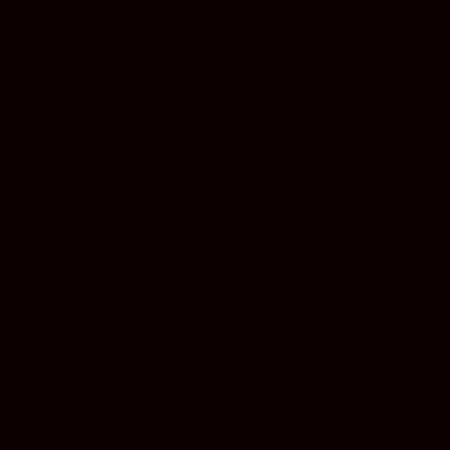
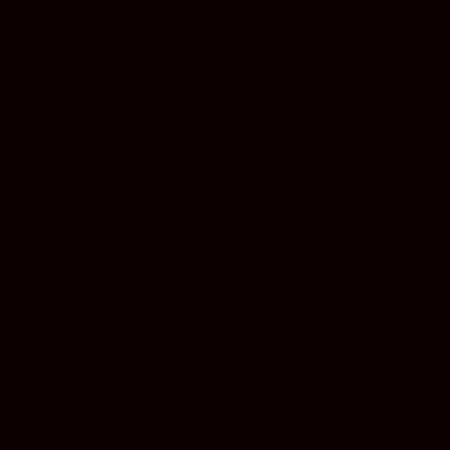
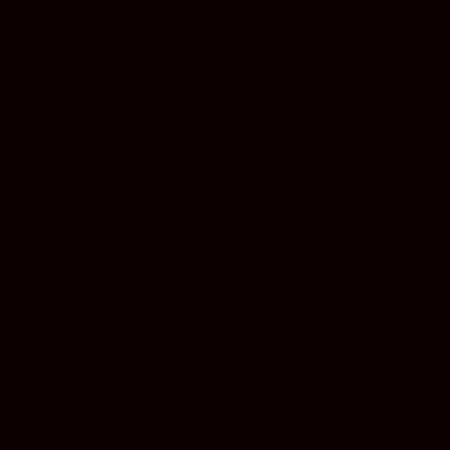
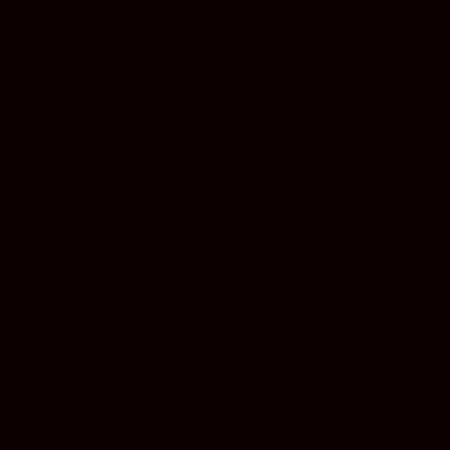
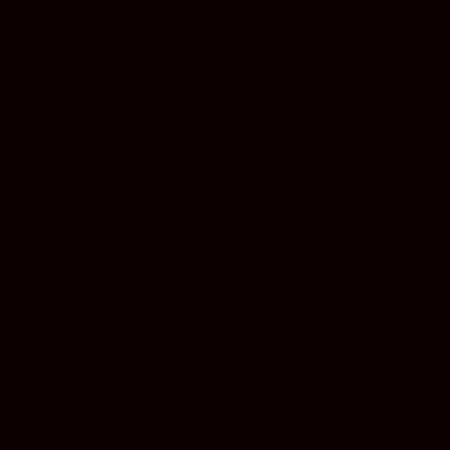
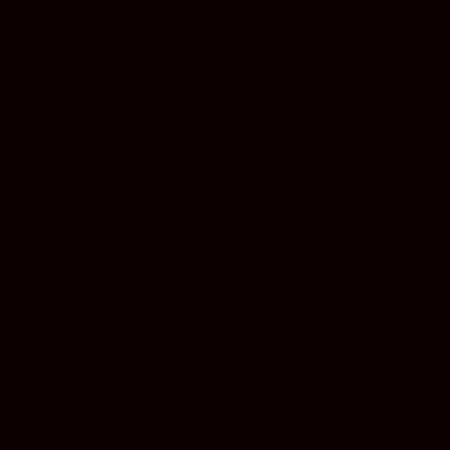
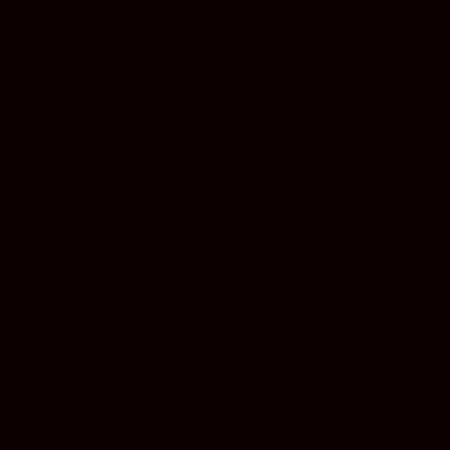
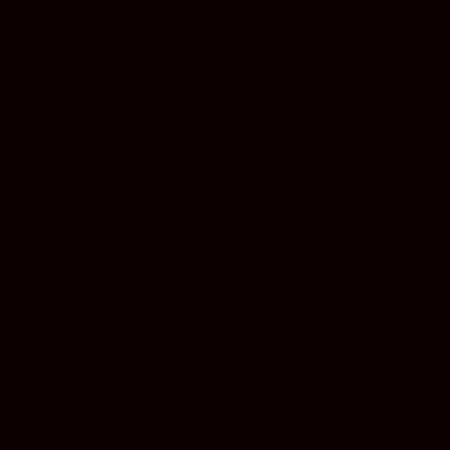
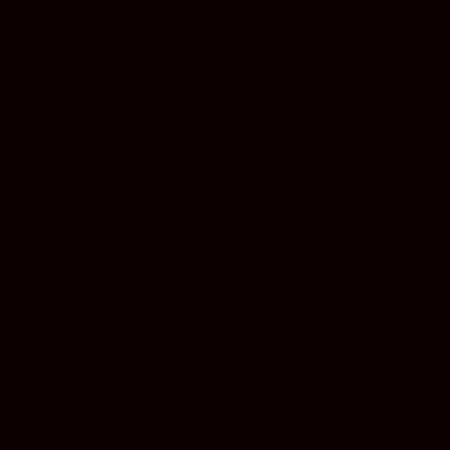
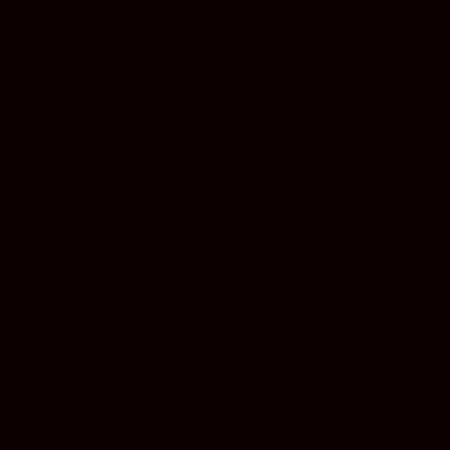
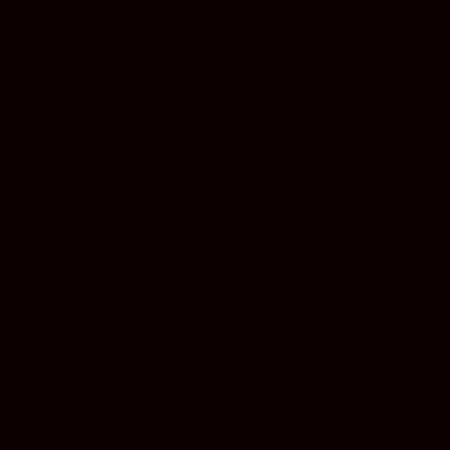
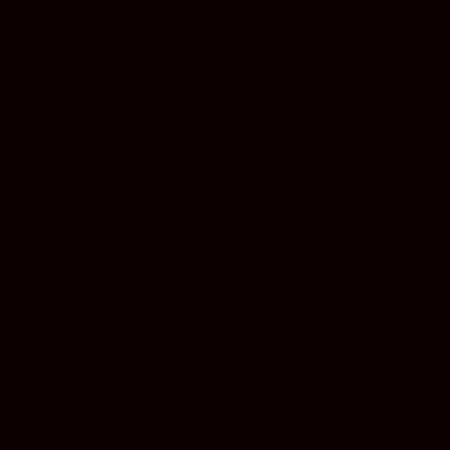
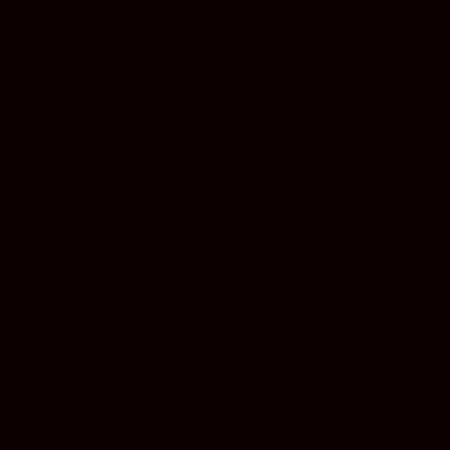
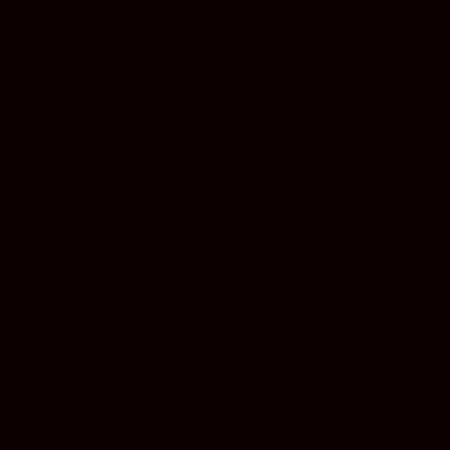
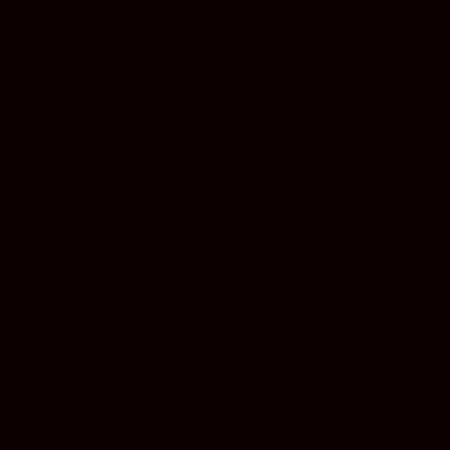
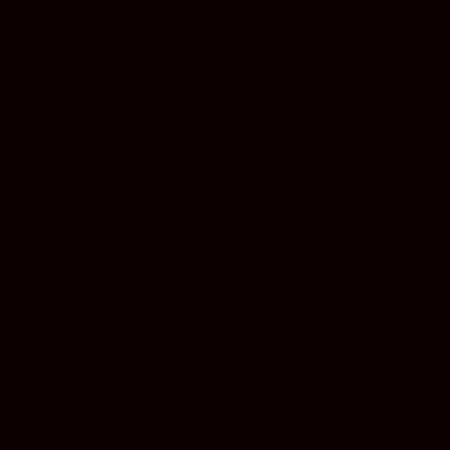
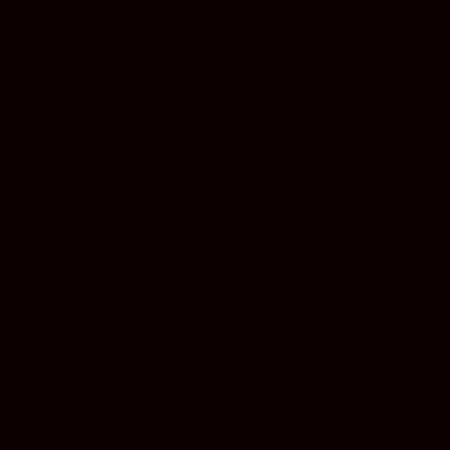
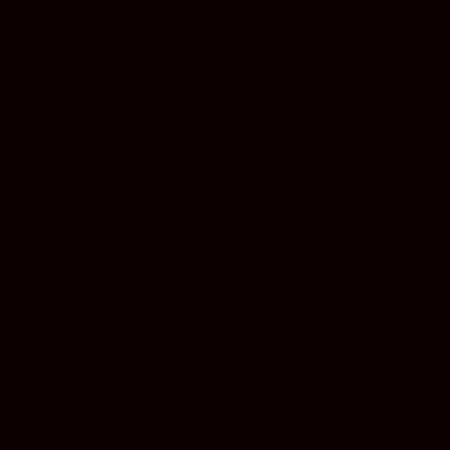
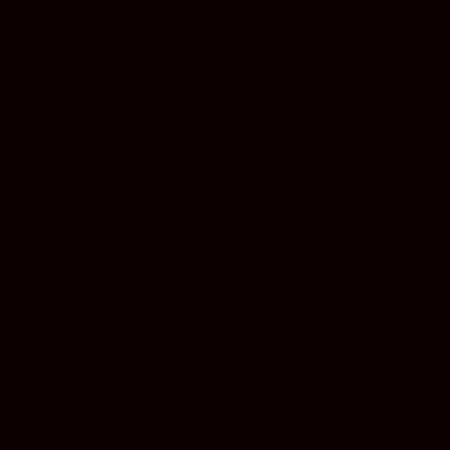
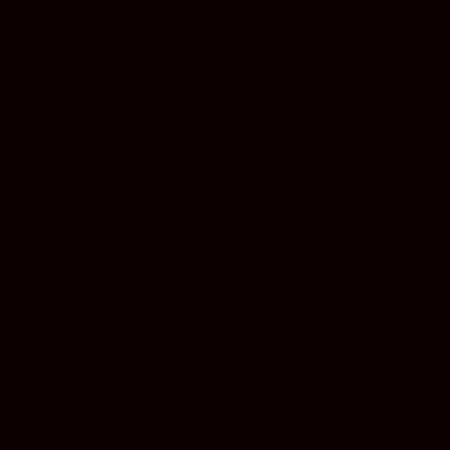
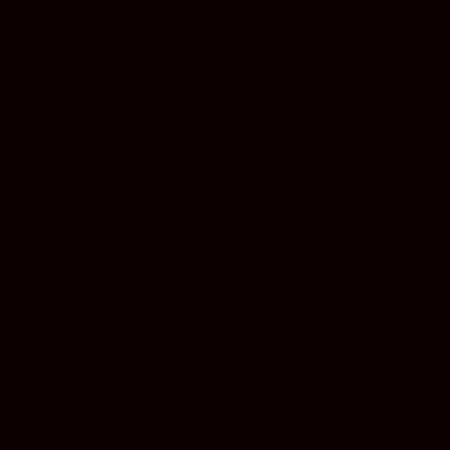
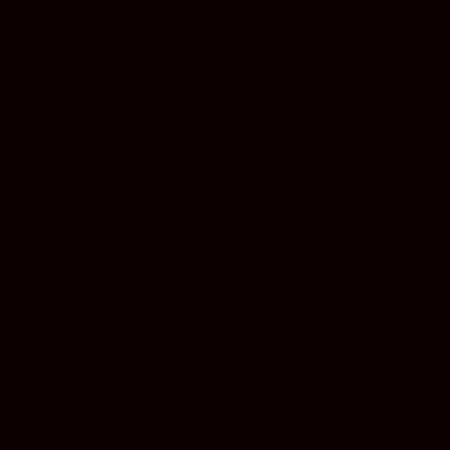
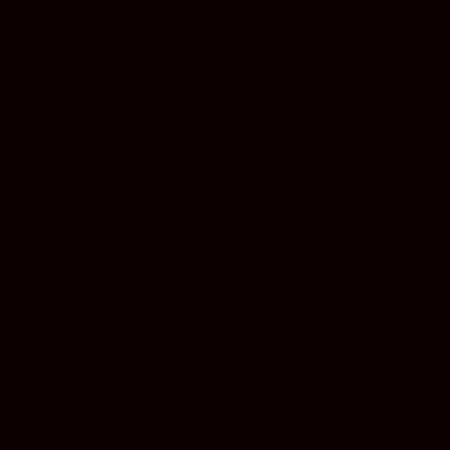
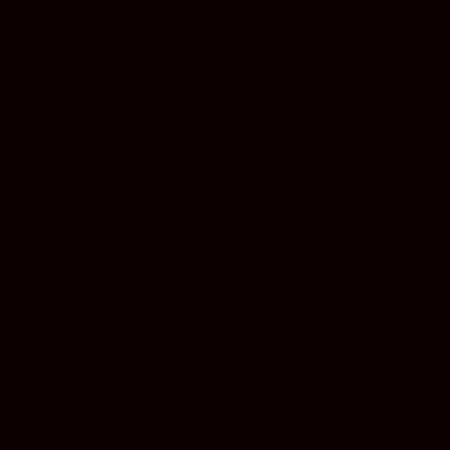
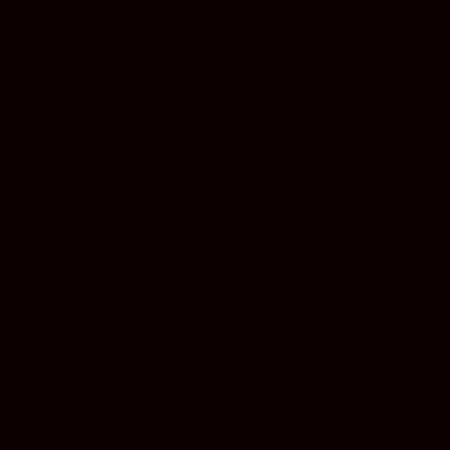
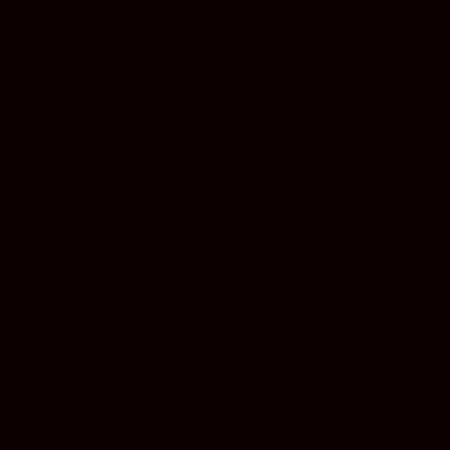
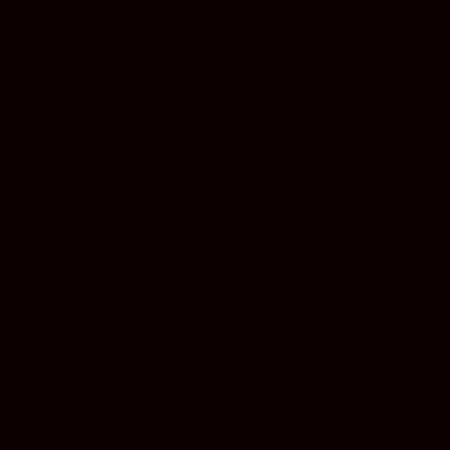
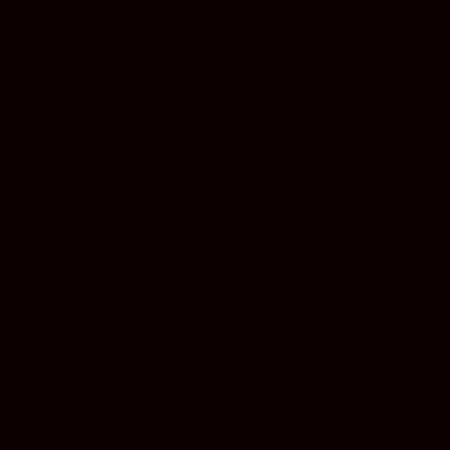
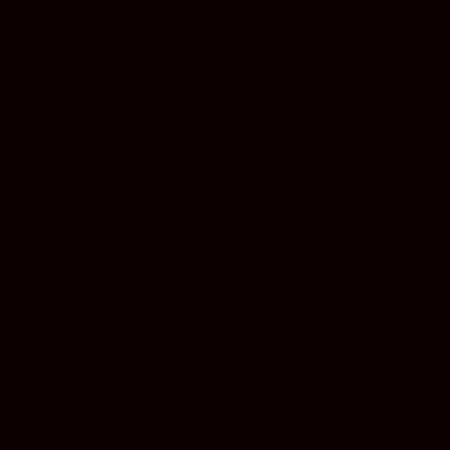
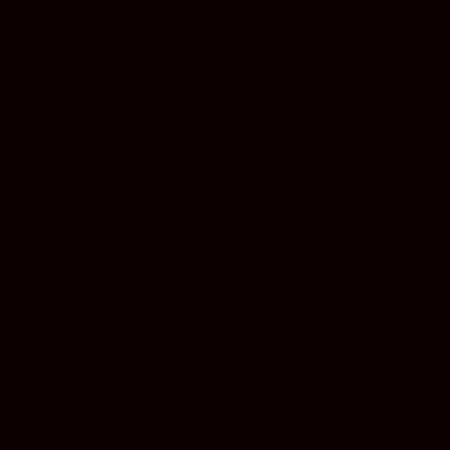
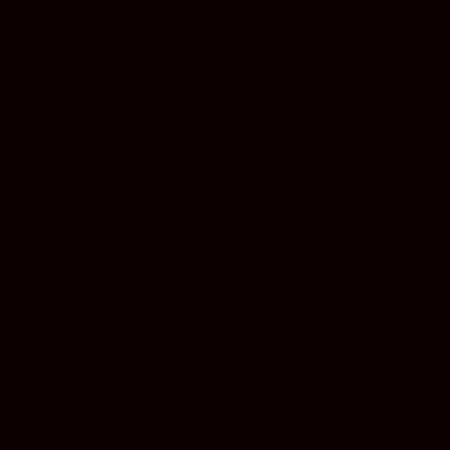
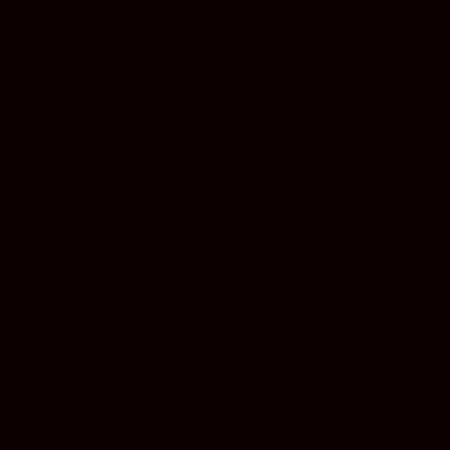
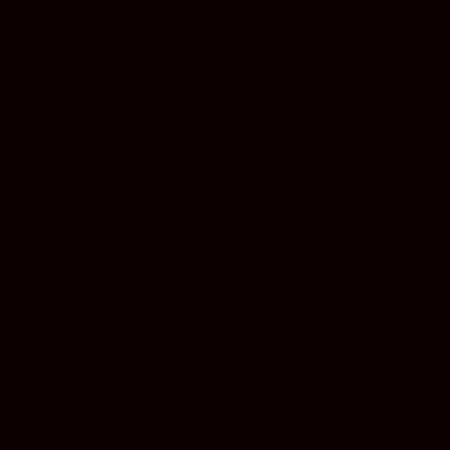
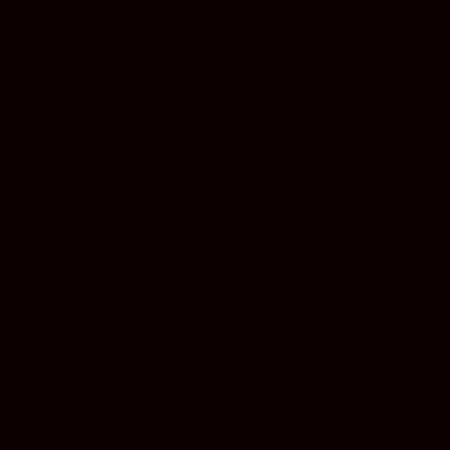
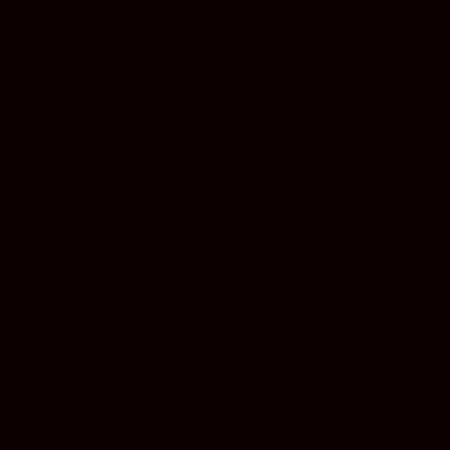
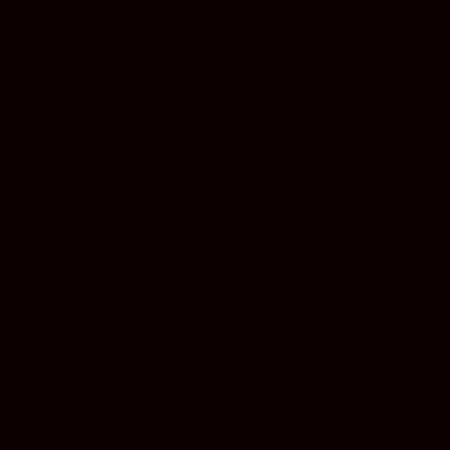
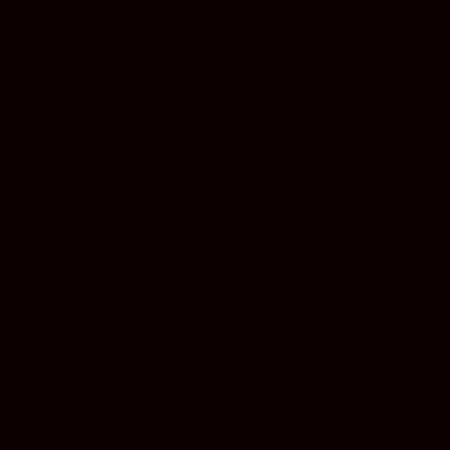
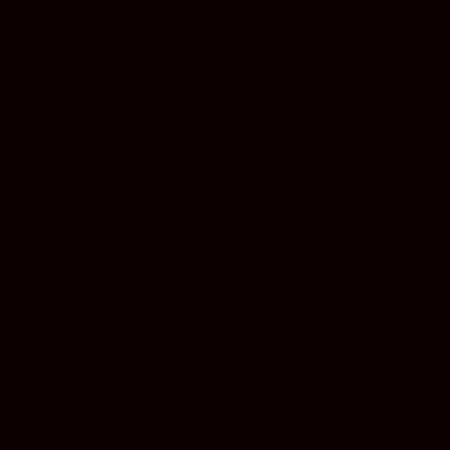
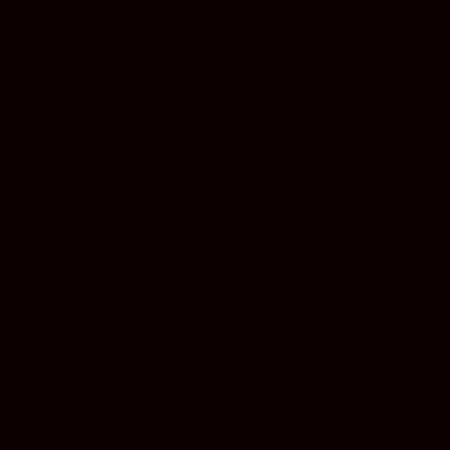
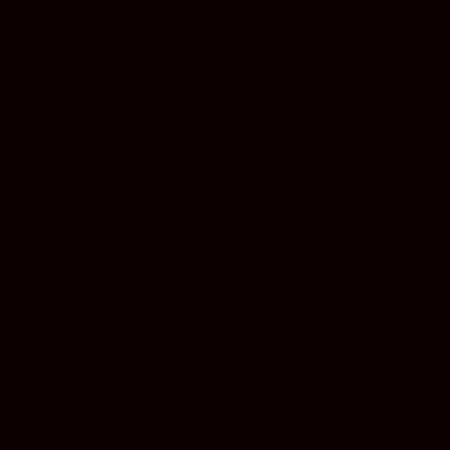
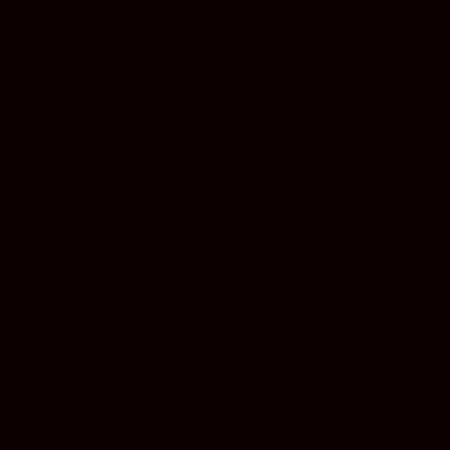
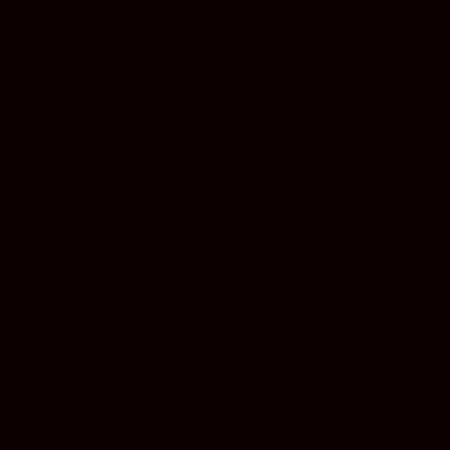
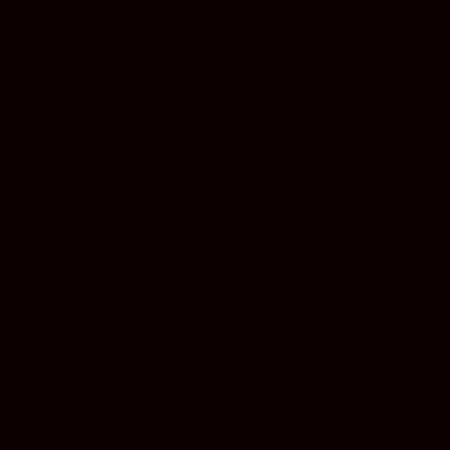
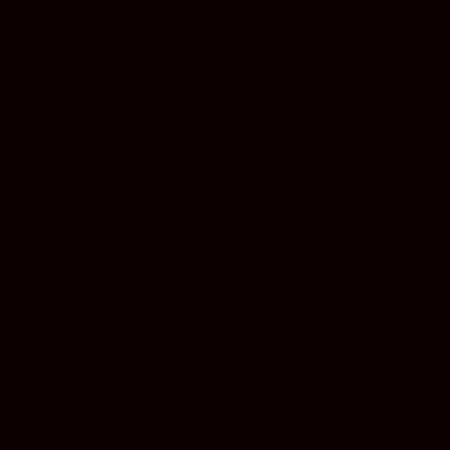
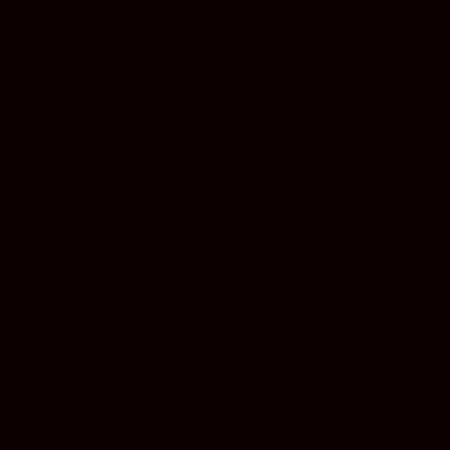
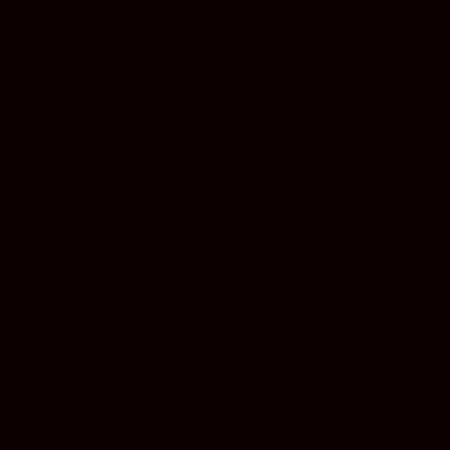
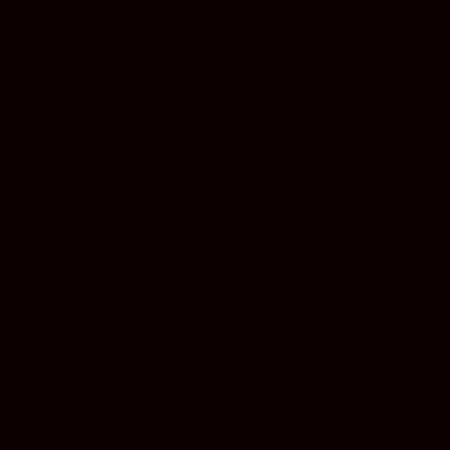
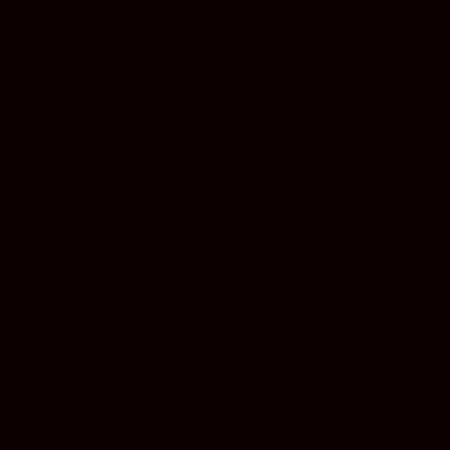
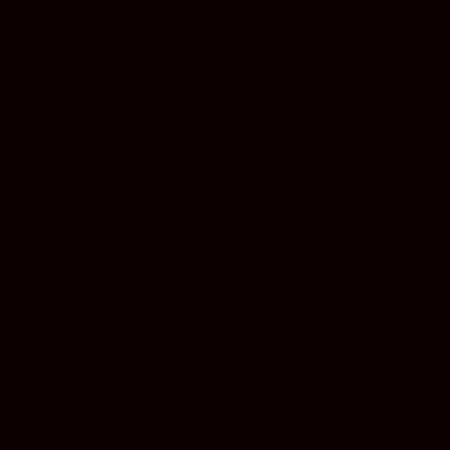
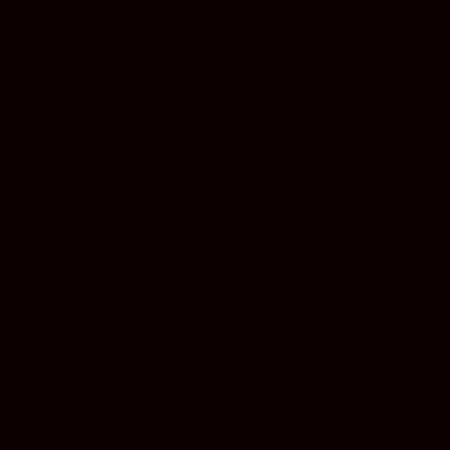
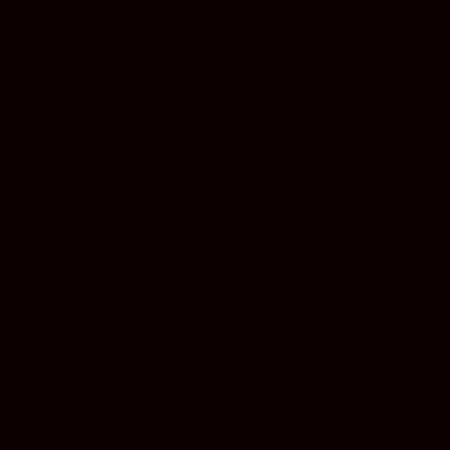

In [9]:
bottom_ind = top_inds[-1]
bottom_im = generated[bottom_ind].reshape([xd,yd])
print(bottom_im)
life_animation(add_border(generated[bottom_ind].reshape([xd,yd]), border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')

[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1.]]



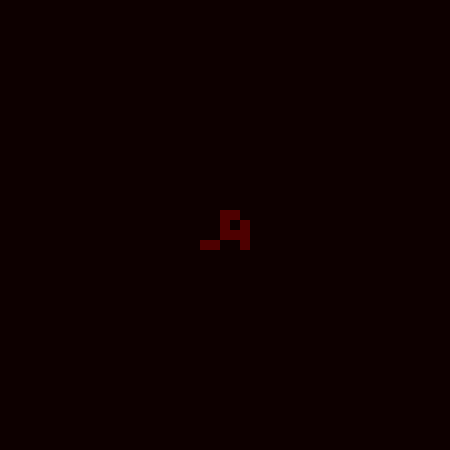
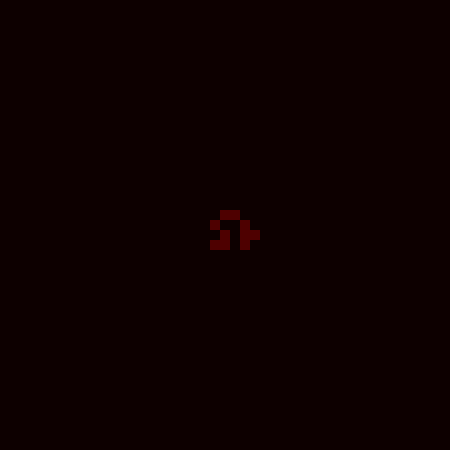
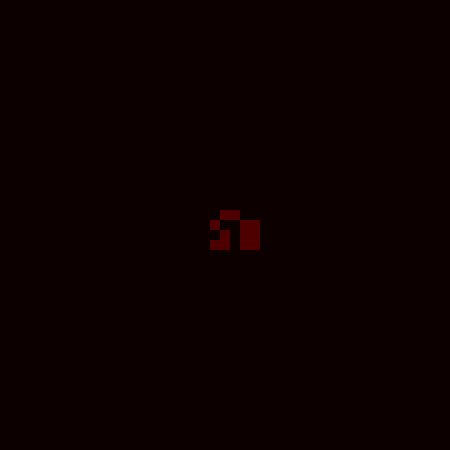
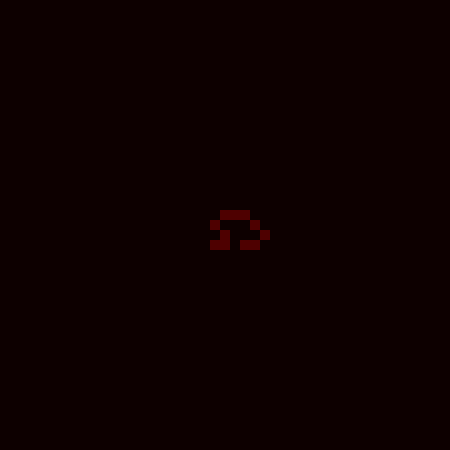
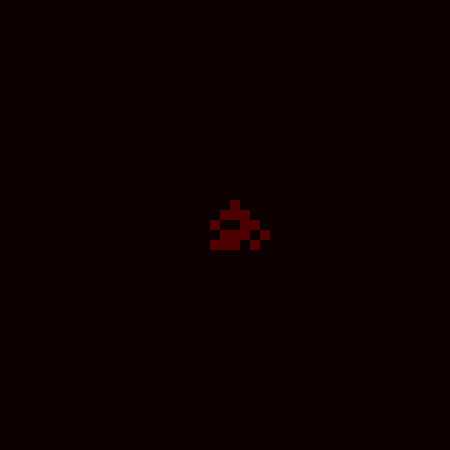
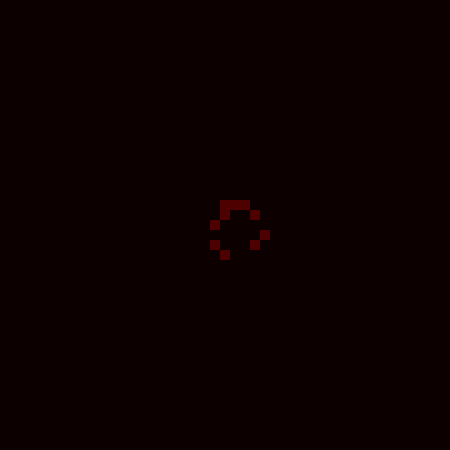
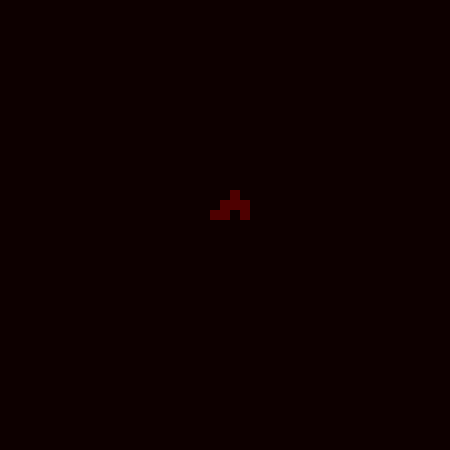
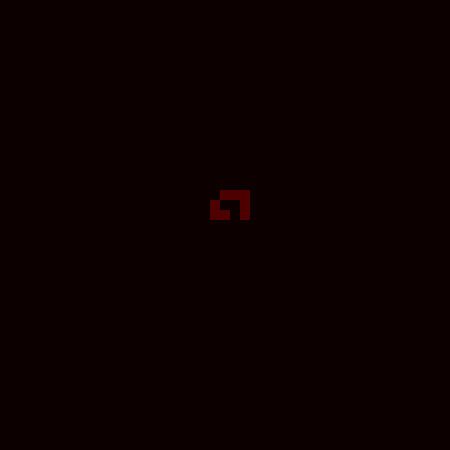
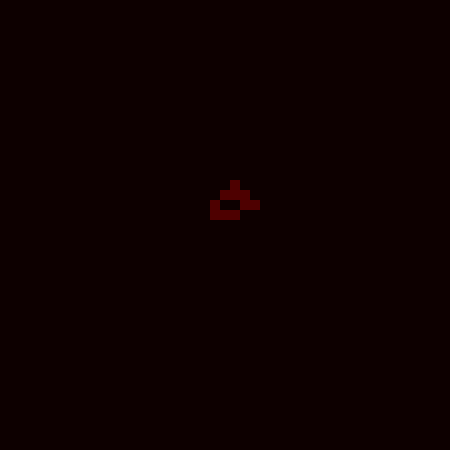
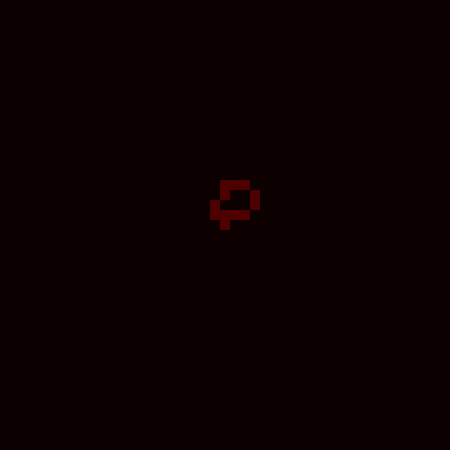
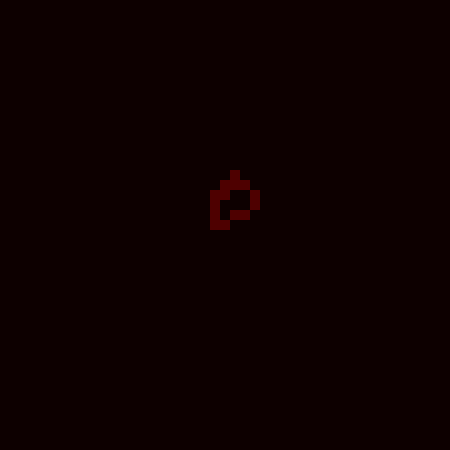
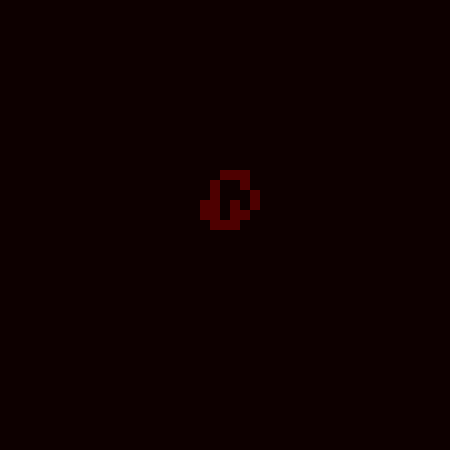
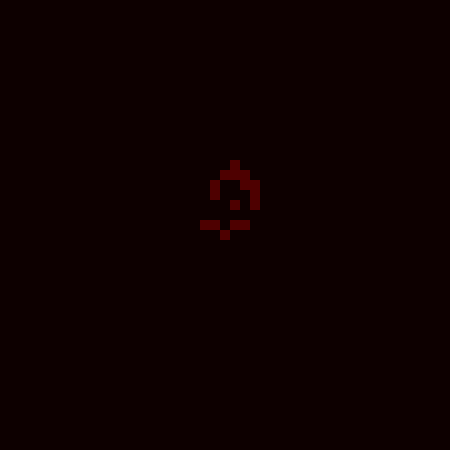
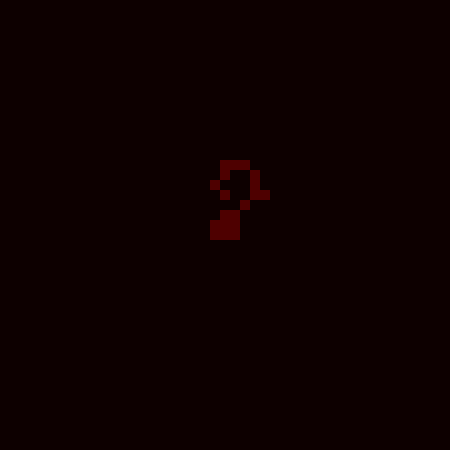
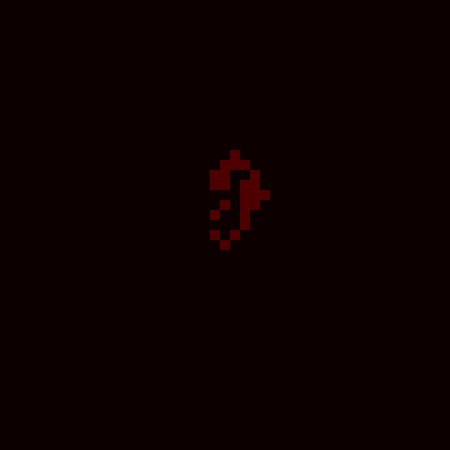
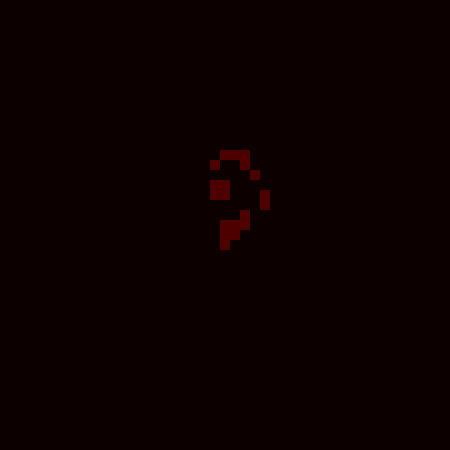
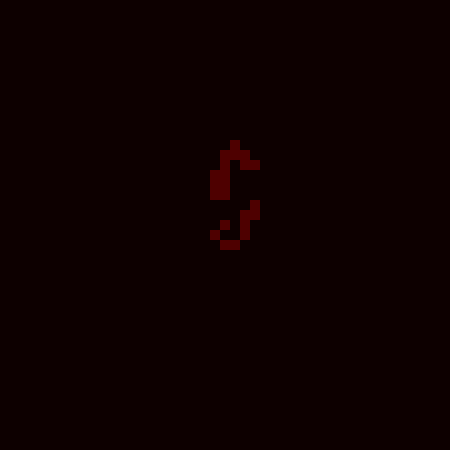
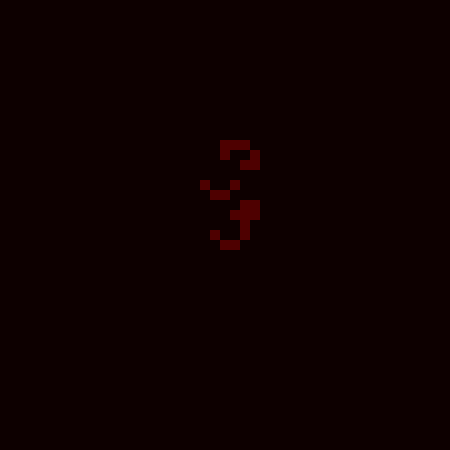
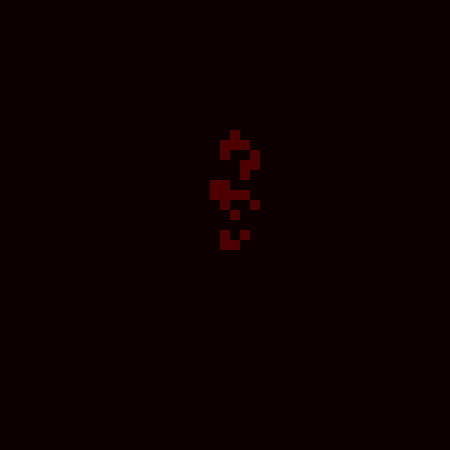
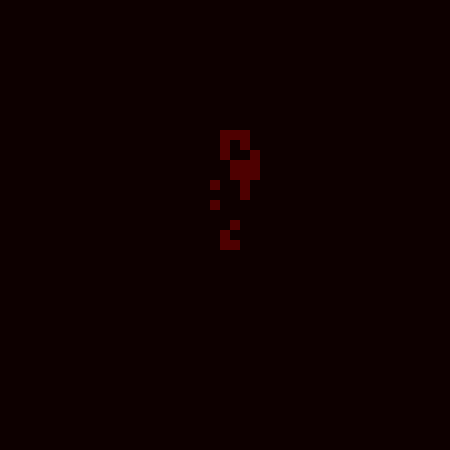
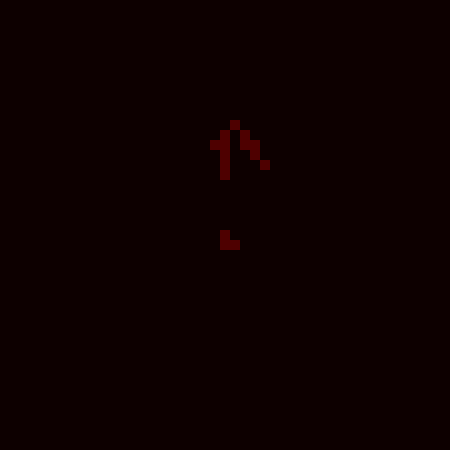
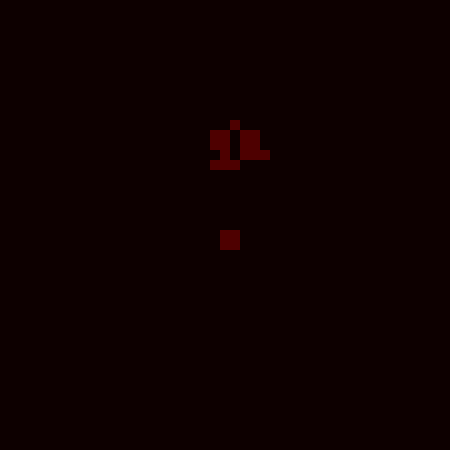
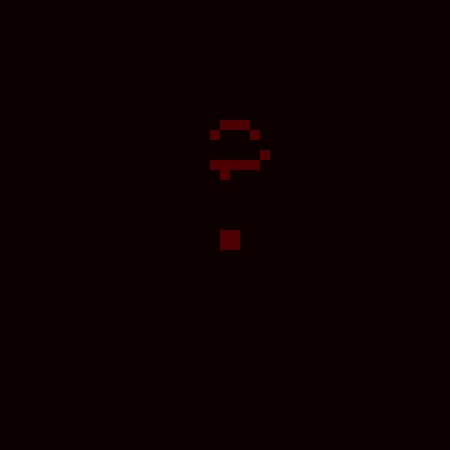
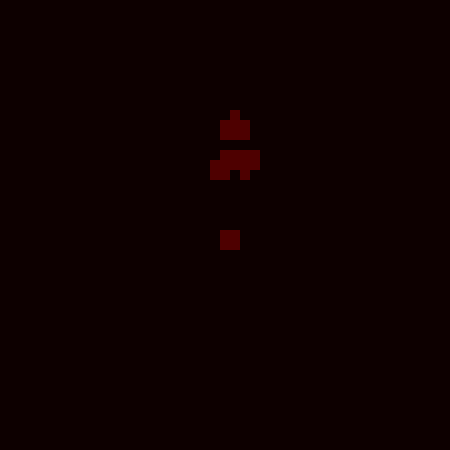
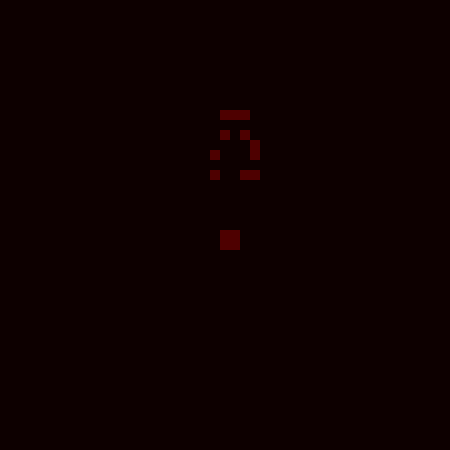
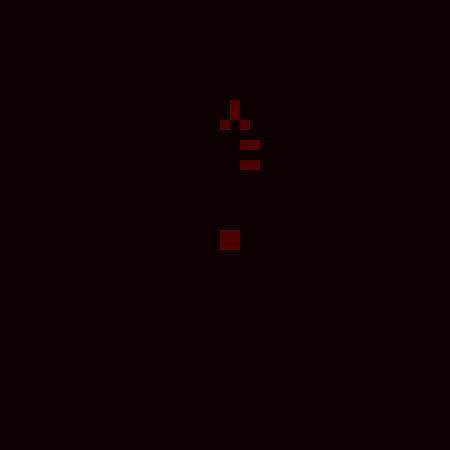
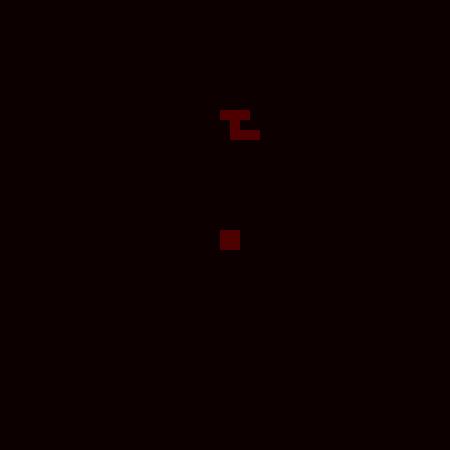
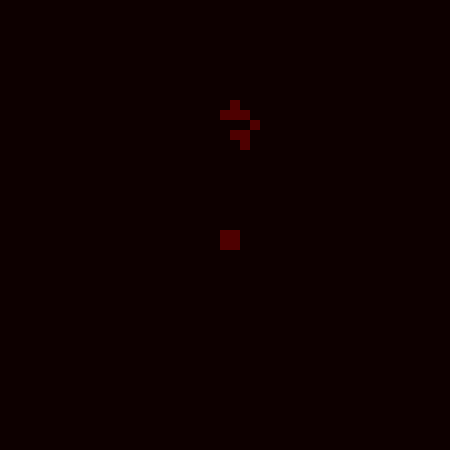
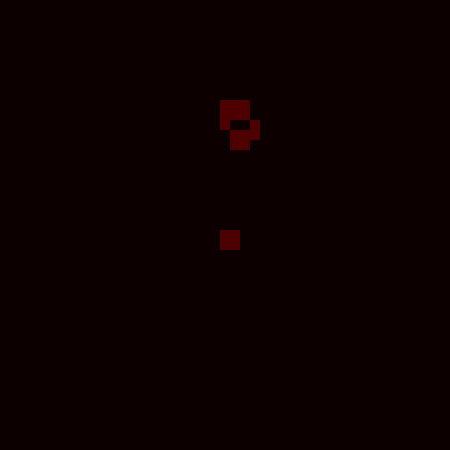
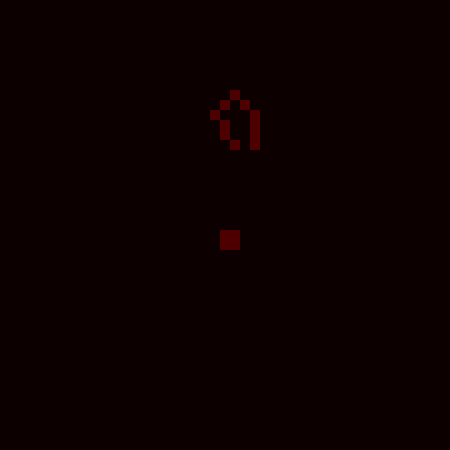
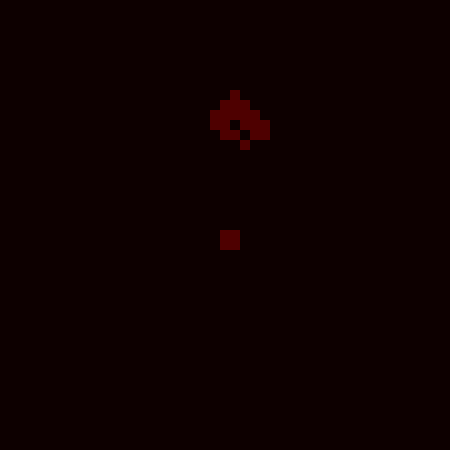
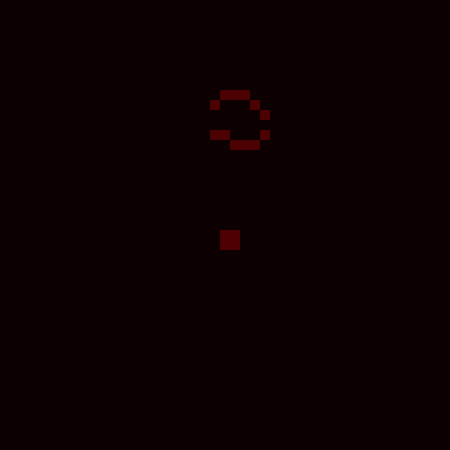
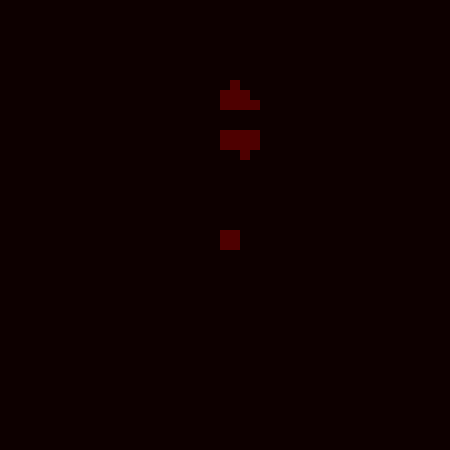
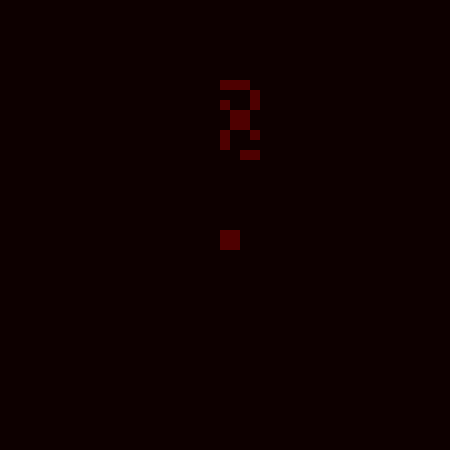
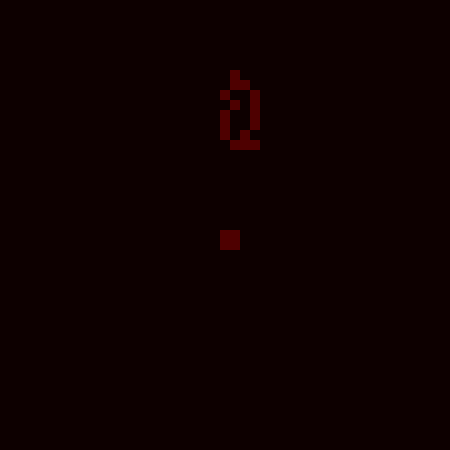
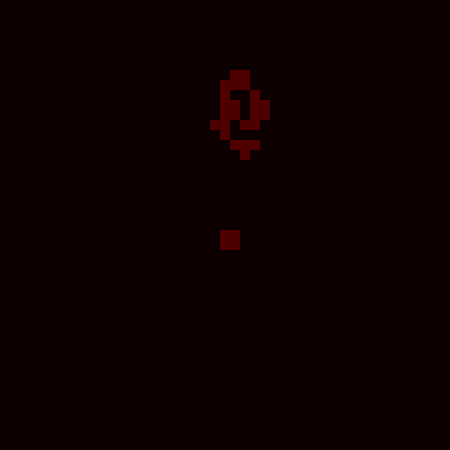
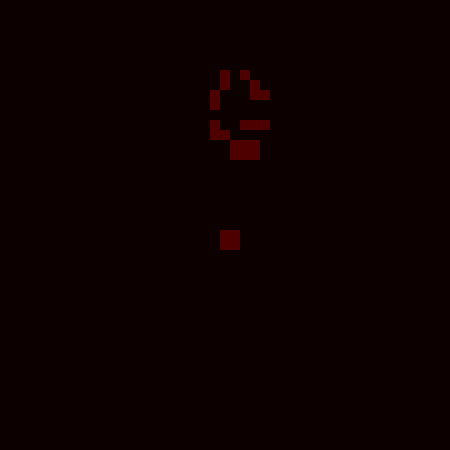
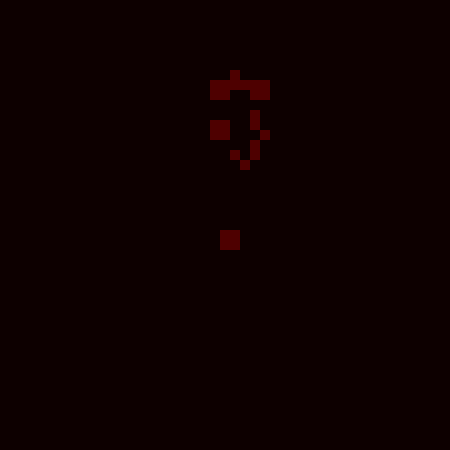
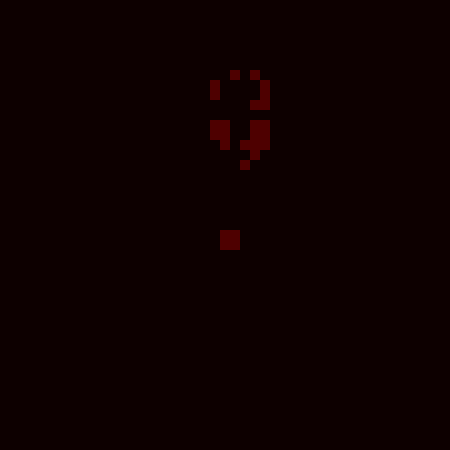
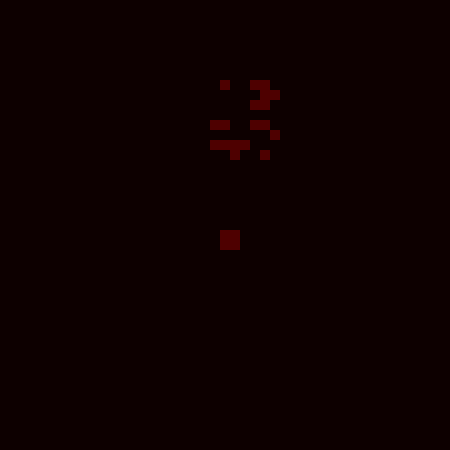
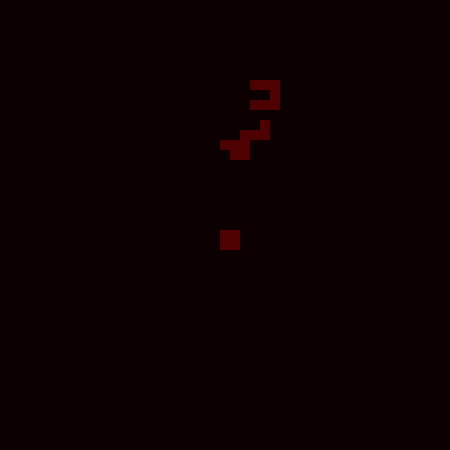
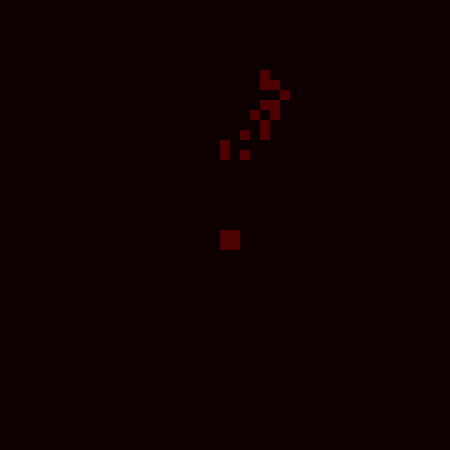
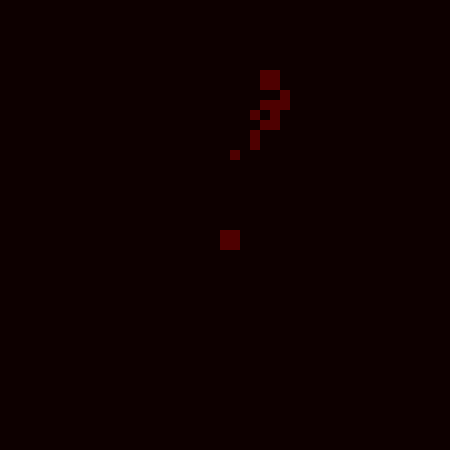
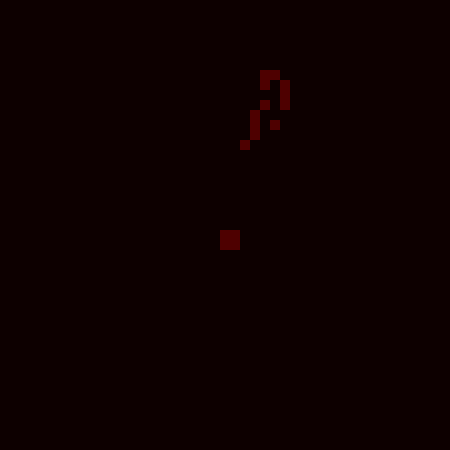
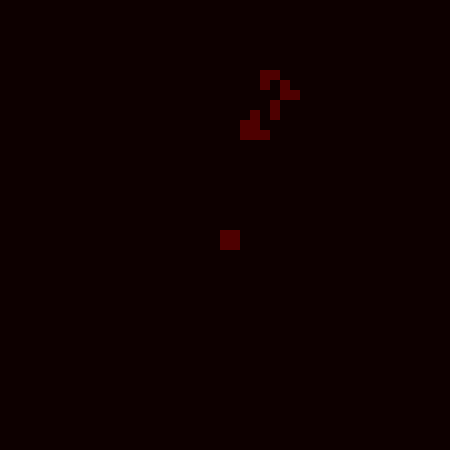
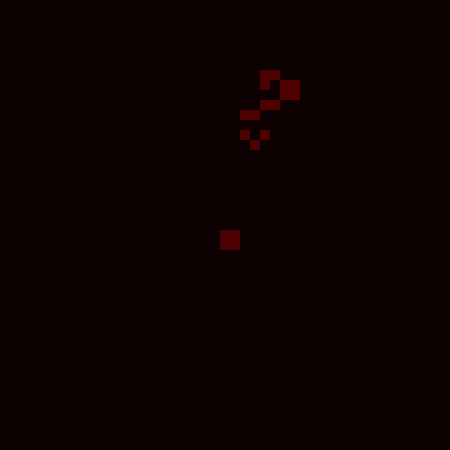
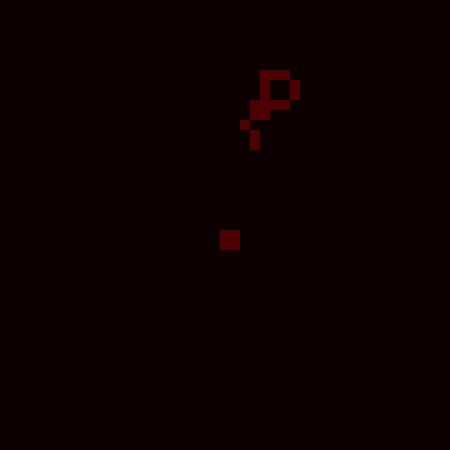
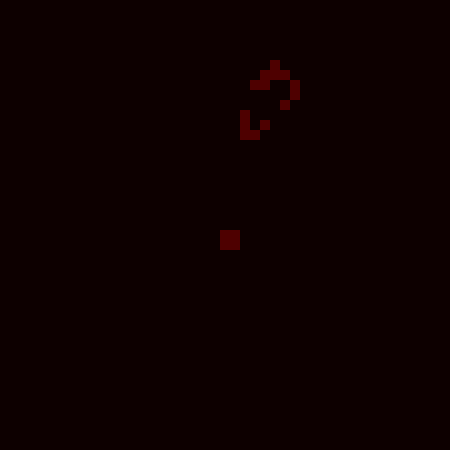
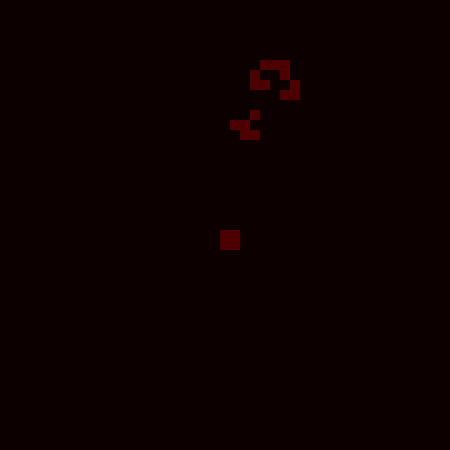
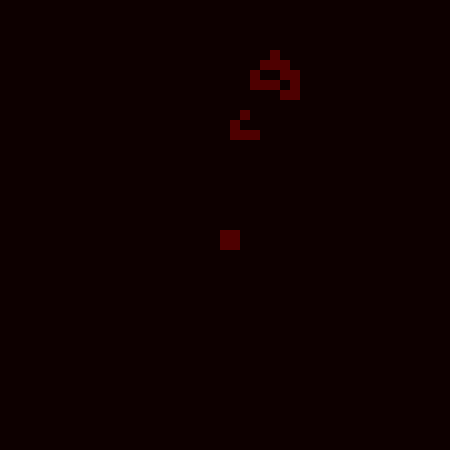
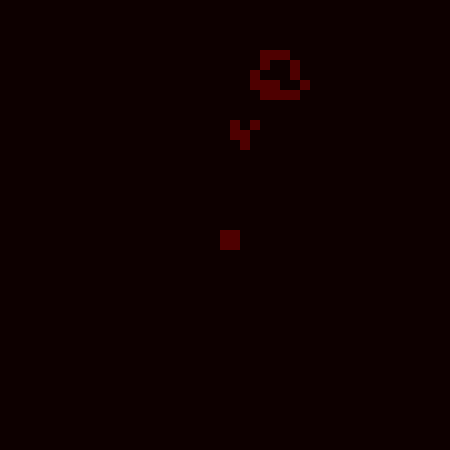
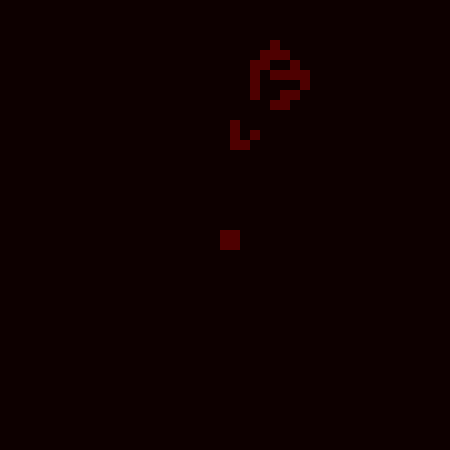
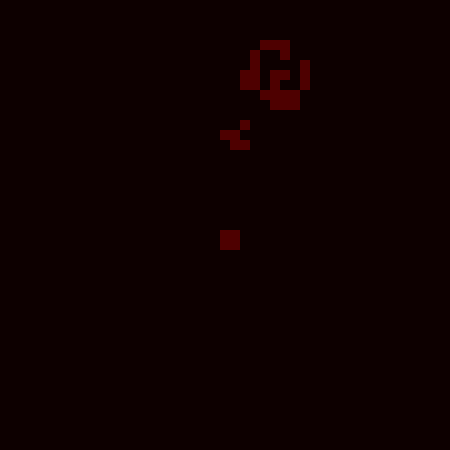
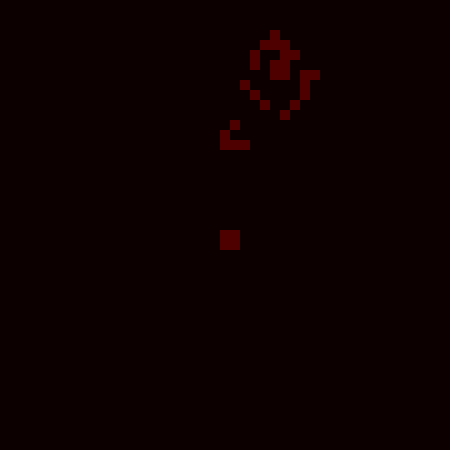
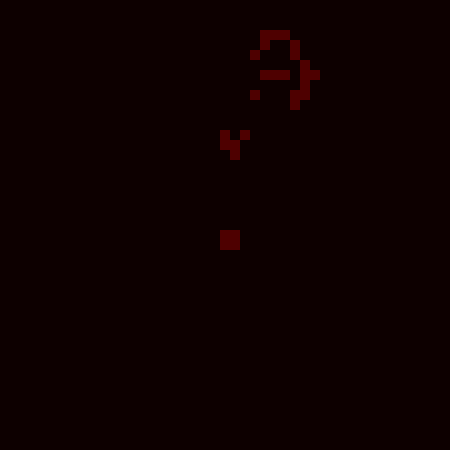
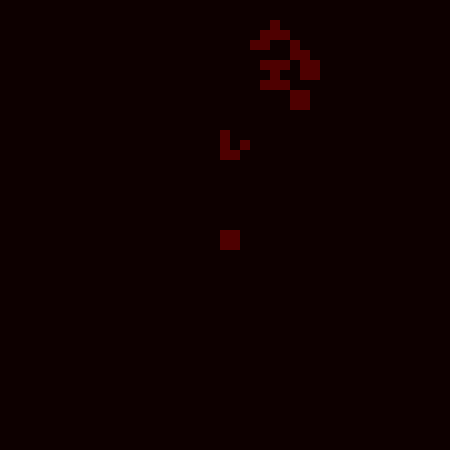
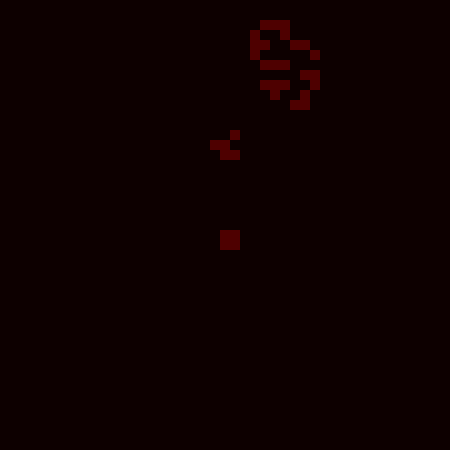
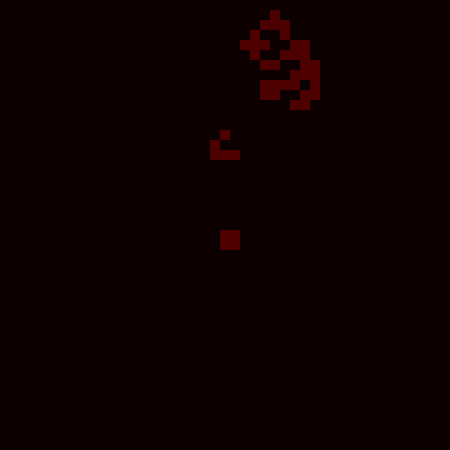
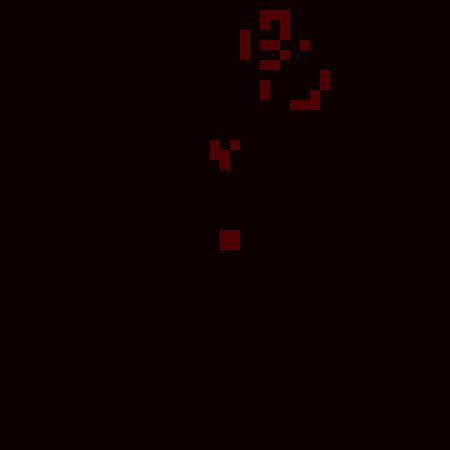
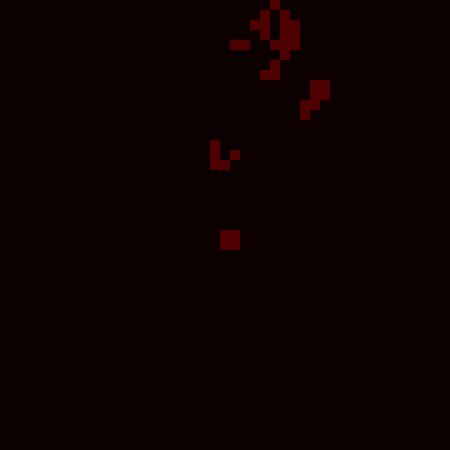
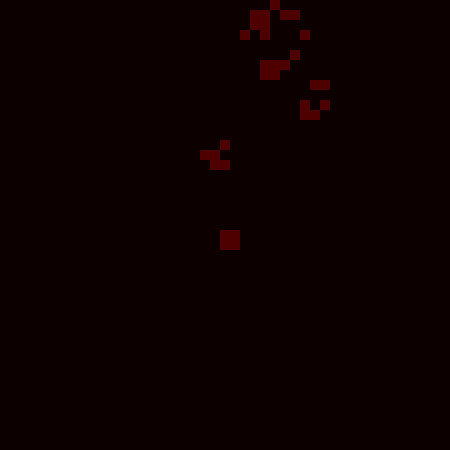
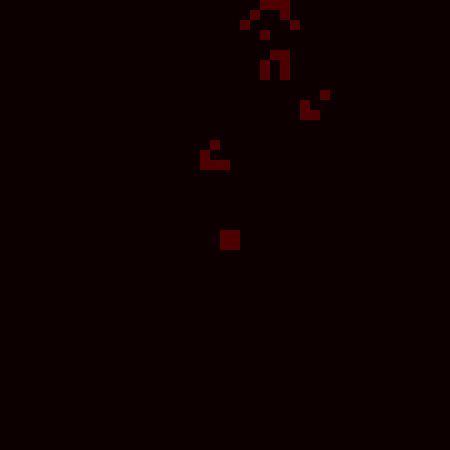
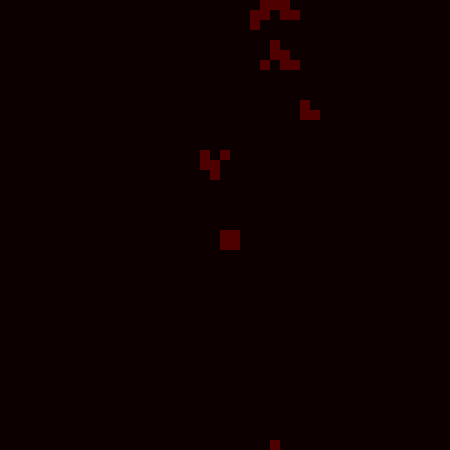
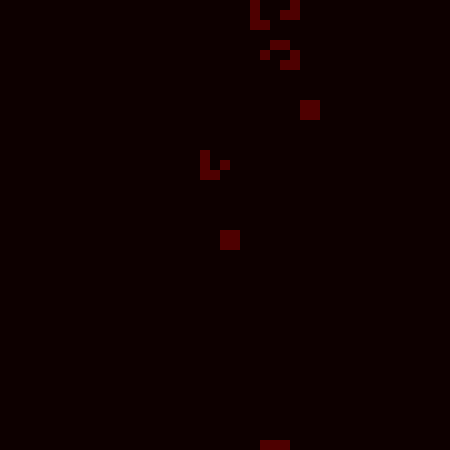
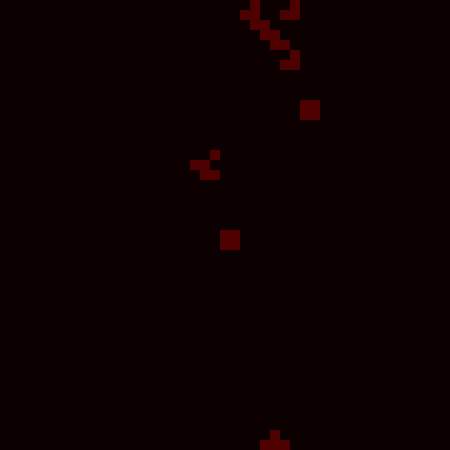
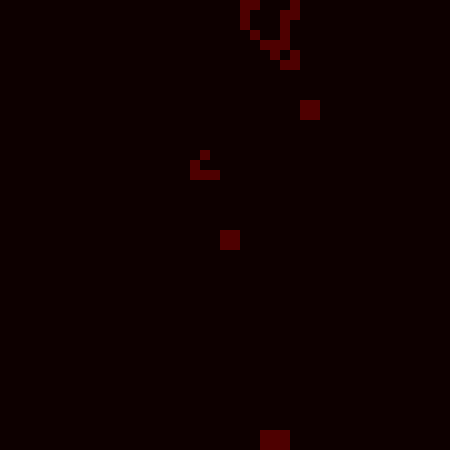
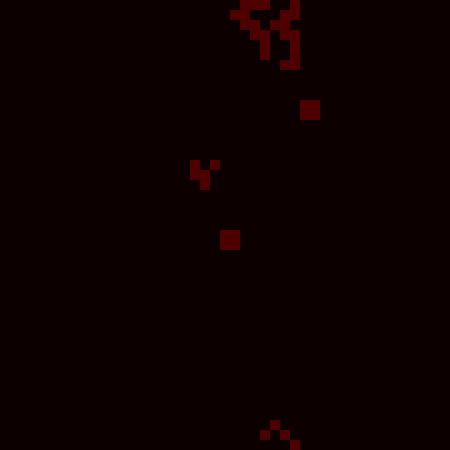
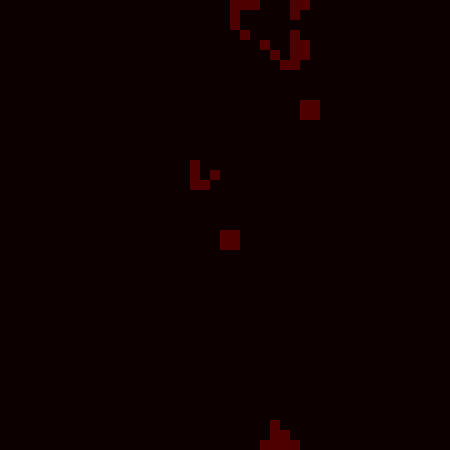
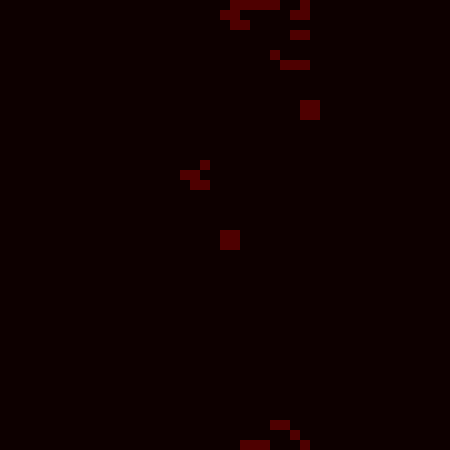
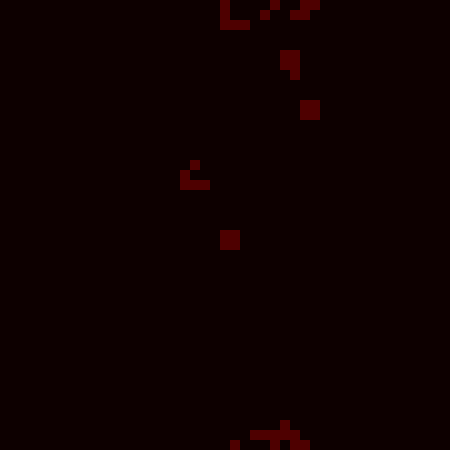
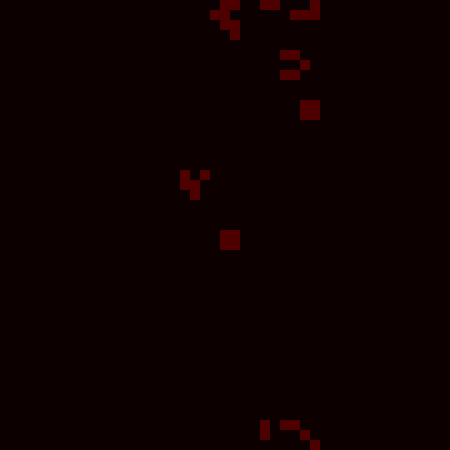
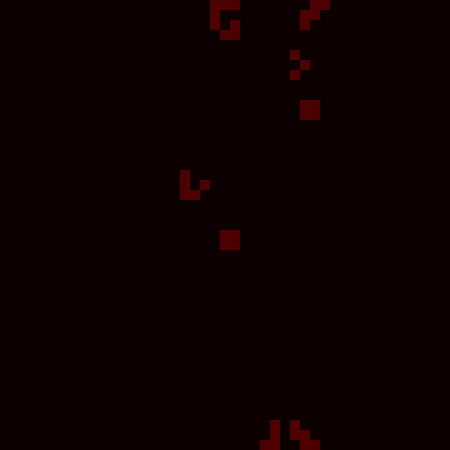
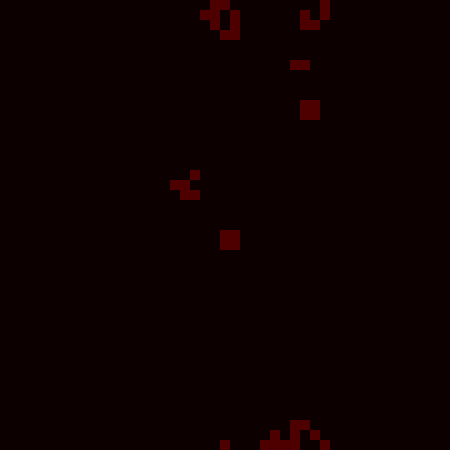
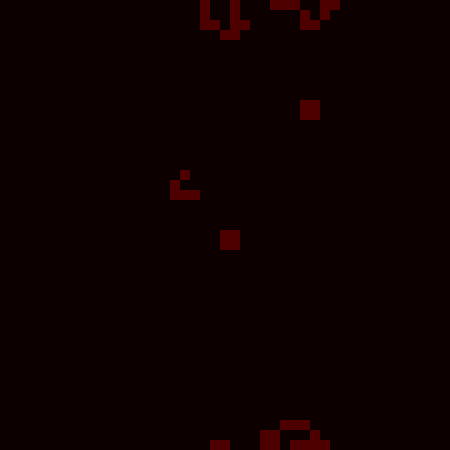
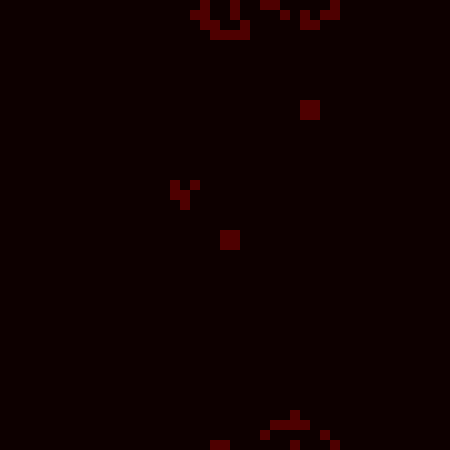
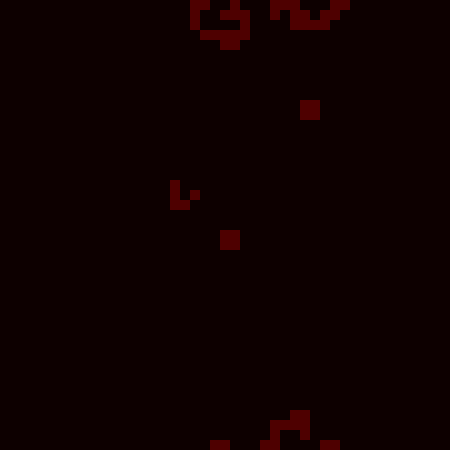
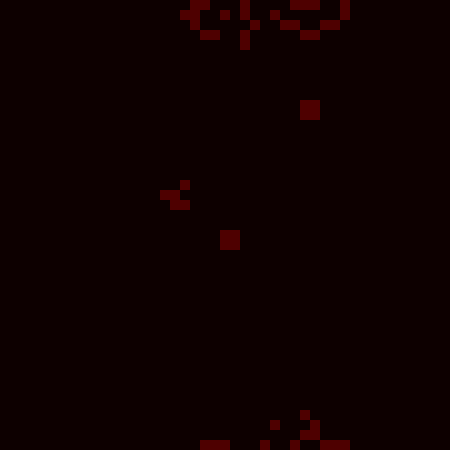
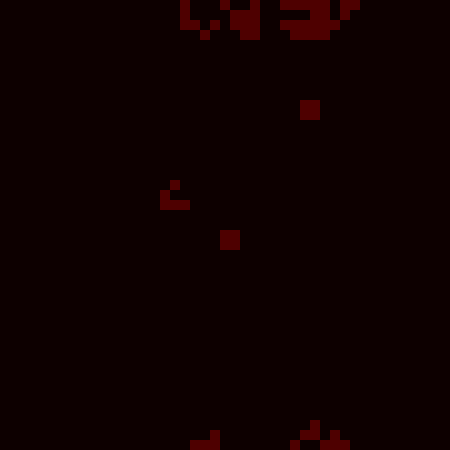
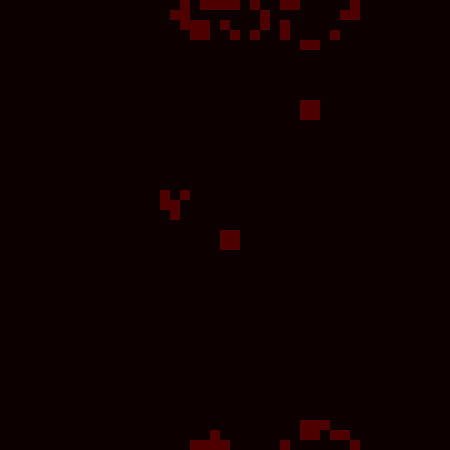
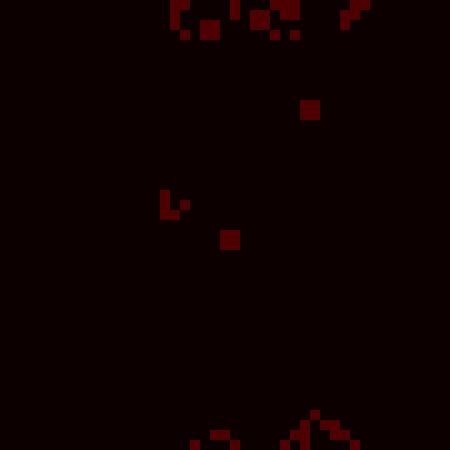
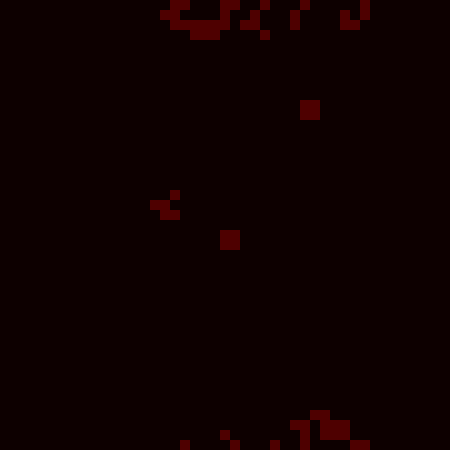
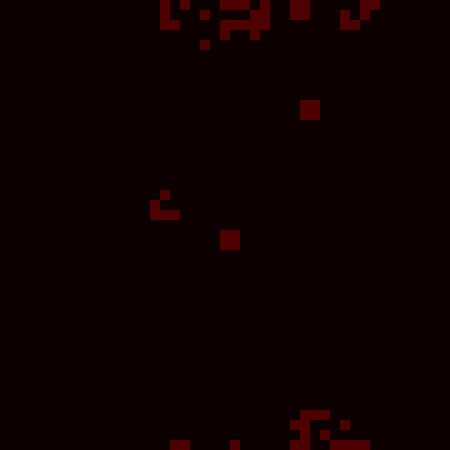
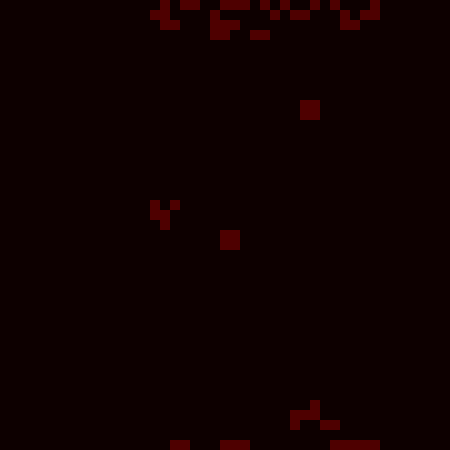
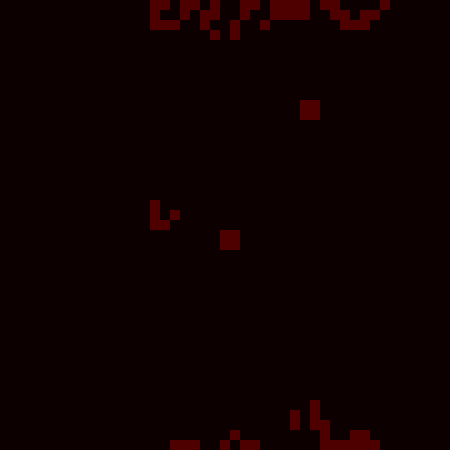
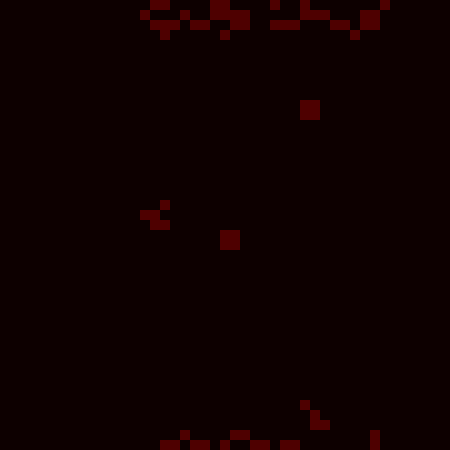
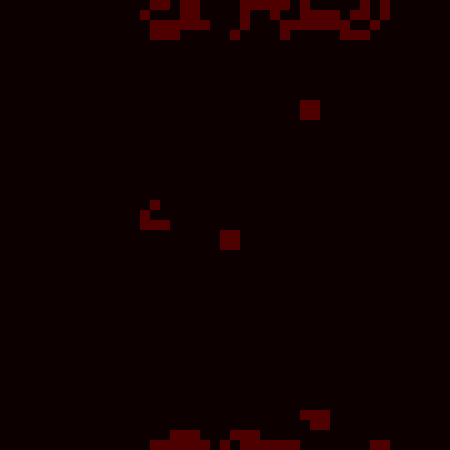
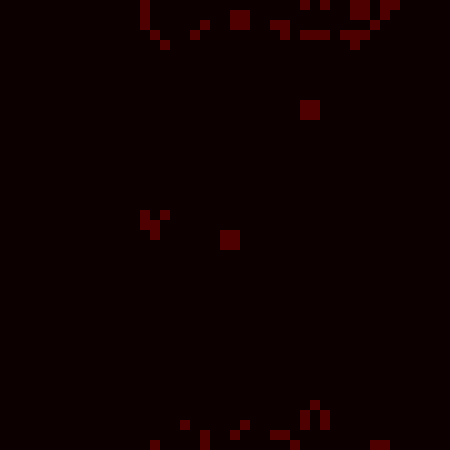
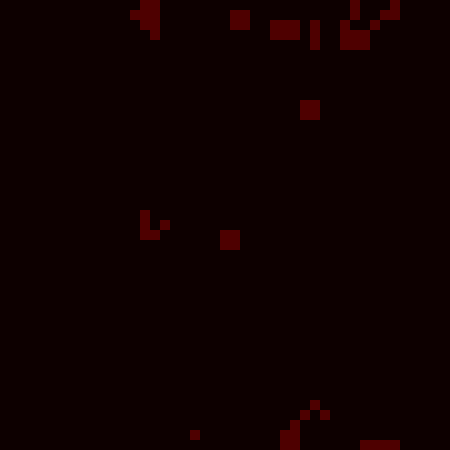
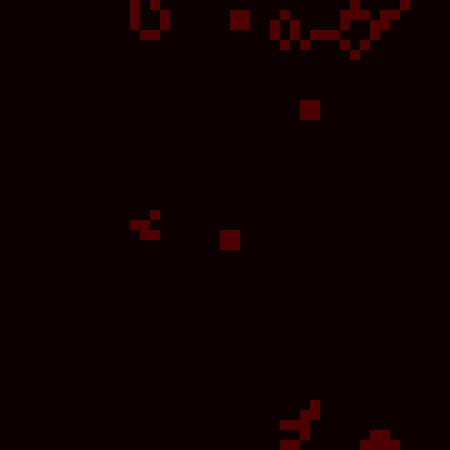
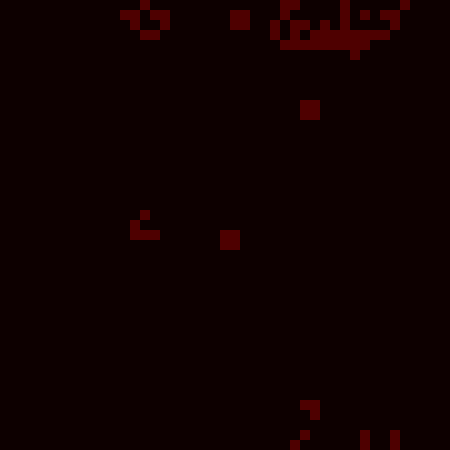
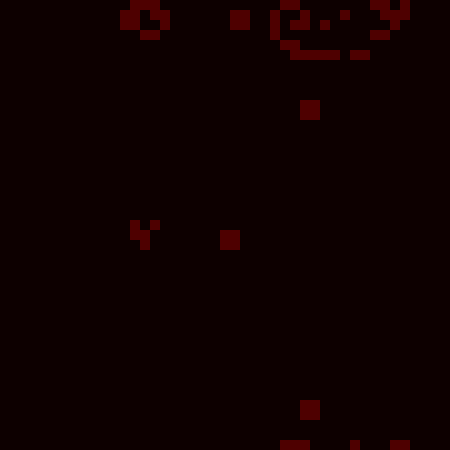
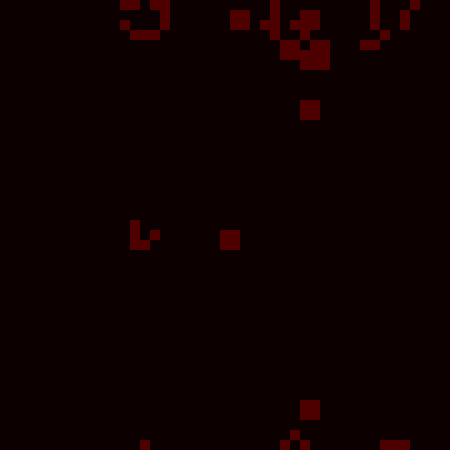
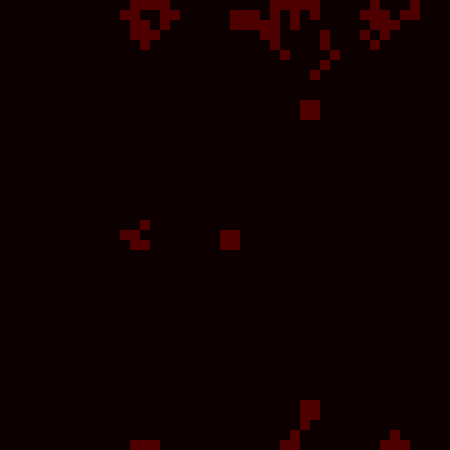
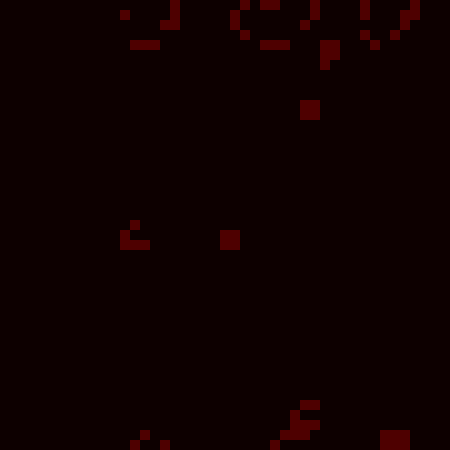
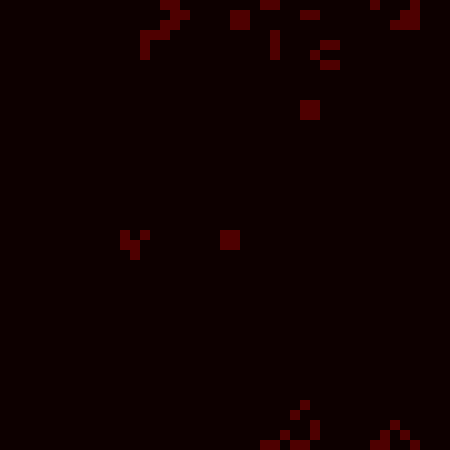
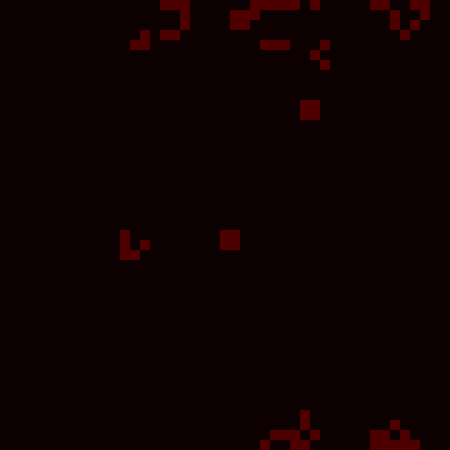
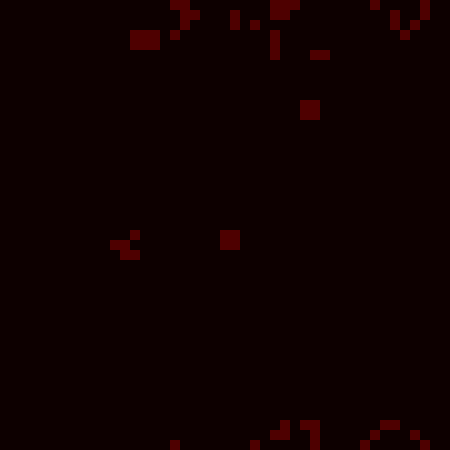
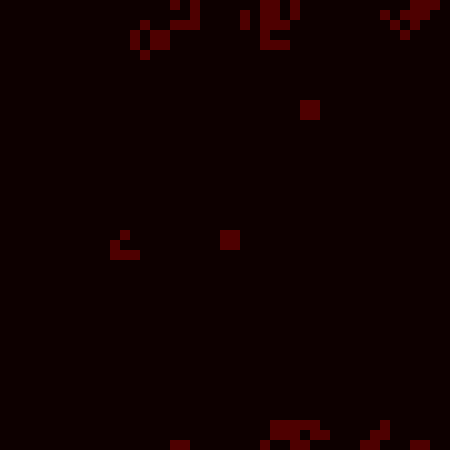
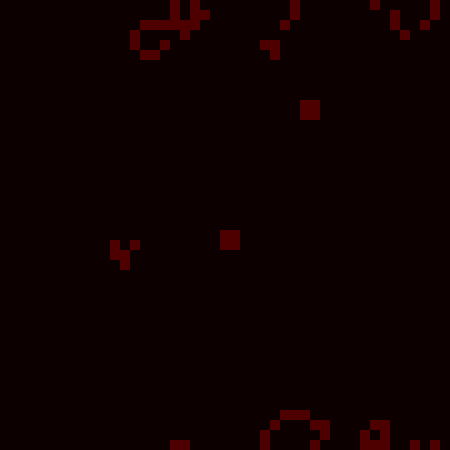
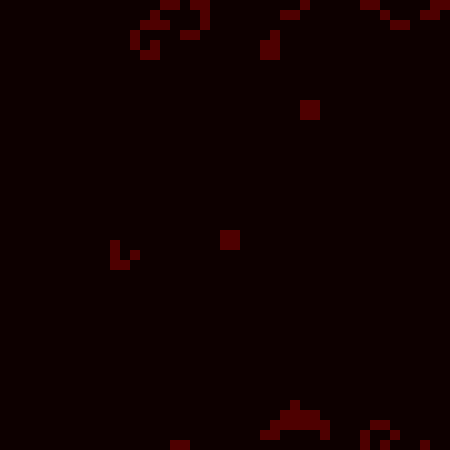

In [10]:
bottom_ind = top_inds[0]
bottom_im = generated[bottom_ind].reshape([xd,yd])
print(bottom_im)
life_animation(add_border(generated[bottom_ind].reshape([xd,yd]), border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

ModuleNotFoundError: No module named 'keras'

In [ ]:
from keras.models import Sequential

model = Sequential()